<a href="https://www.kaggle.com/code/w1ndness/data-analysis-07-lstm?scriptVersionId=109545310" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electrical-energy-load/test/1.csv
/kaggle/input/electrical-energy-load/test/3.csv
/kaggle/input/electrical-energy-load/test/.pdf
/kaggle/input/electrical-energy-load/test/2-1.csv
/kaggle/input/electrical-energy-load/test/2-2.csv
/kaggle/input/electrical-energy-load/train/1.csv
/kaggle/input/electrical-energy-load/train/3.csv
/kaggle/input/electrical-energy-load/train/2.csv


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
!nvidia-smi

Sun Oct 30 11:35:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Question 1

In [4]:
!rm -f model*

In [5]:
train_data = pd.read_csv('/kaggle/input/electrical-energy-load/train/1.csv')
test_data = pd.read_csv('/kaggle/input/electrical-energy-load/test/1.csv', encoding='gb2312')

In [6]:
train_data.head()

数据时间    总有功功率（kw）
0  2018/1/1 00:00:00  244033.7682
1  2018/1/1 00:15:00  232720.6402
2  2018/1/1 00:30:00  231685.6891
3  2018/1/1 00:45:00  227581.3317
4  2018/1/1 01:00:00  233482.4269

In [7]:
train_data.columns = ['Date', 'Power']
train_data.head()

Date        Power
0  2018/1/1 00:00:00  244033.7682
1  2018/1/1 00:15:00  232720.6402
2  2018/1/1 00:30:00  231685.6891
3  2018/1/1 00:45:00  227581.3317
4  2018/1/1 01:00:00  233482.4269

In [8]:
train_data.shape

(128156, 2)

In [9]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
grouper = pd.Grouper(key='Date', freq='15min')
train_data = train_data.groupby(grouper).first()
train_data.head()

Power
Date                            
2018-01-01 00:00:00  244033.7682
2018-01-01 00:15:00  232720.6402
2018-01-01 00:30:00  231685.6891
2018-01-01 00:45:00  227581.3317
2018-01-01 01:00:00  233482.4269

In [10]:
train_data.shape

(128544, 1)

In [11]:
train_data.isnull().sum()

Power    388
dtype: int64

In [12]:
train_data['Power'] = train_data['Power'].interpolate()
train_data.isnull().sum()

Power    0
dtype: int64

In [13]:
train_data.to_csv('15min_freq.csv')

<AxesSubplot:xlabel='Date', ylabel='Power'>

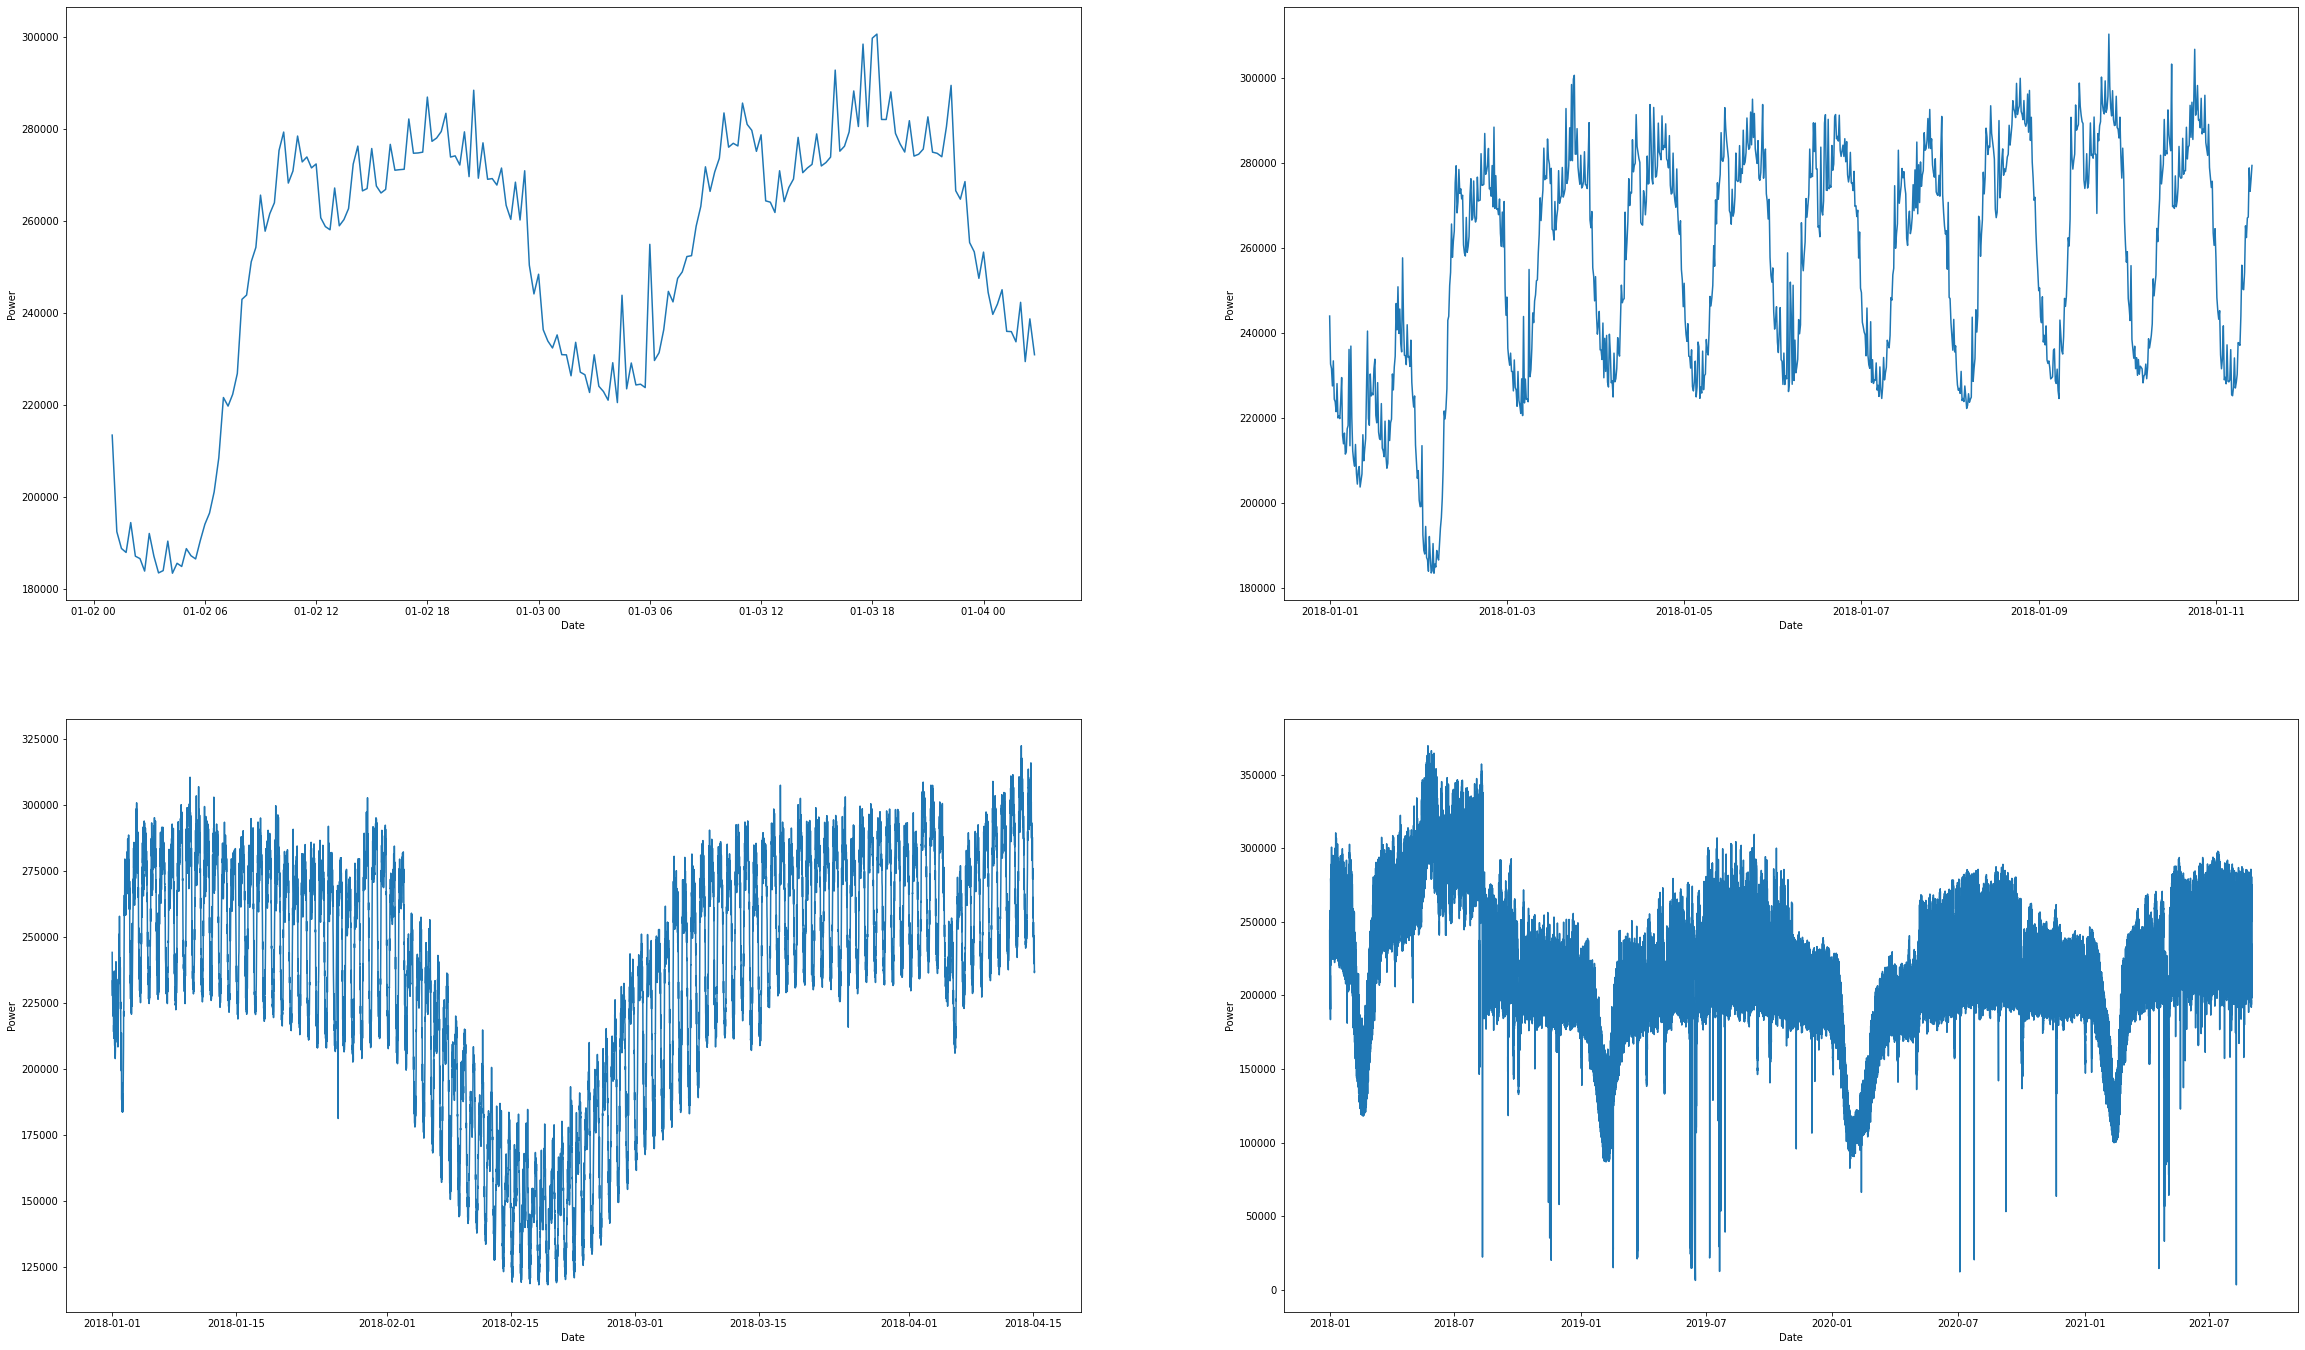

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(40, 24))
sns.lineplot(data=train_data[100:300], x='Date', y='Power', ax=ax[0][0])
sns.lineplot(data=train_data[:1000], x='Date', y='Power', ax=ax[0][1])
sns.lineplot(data=train_data[:10000], x='Date', y='Power', ax=ax[1][0])
sns.lineplot(data=train_data, x='Date', y='Power', ax=ax[1][1])

In [15]:
def split_dataset(data, train_size=.8, valid_size=.1):
    data_size = len(data)
    X_train = data[:int(data_size * train_size)].copy()
    X_valid = data[int(data_size * train_size):int(data_size * train_size) + int(data_size * valid_size)].copy()
    X_test = data[int(data_size * train_size) + int(data_size * valid_size):].copy()
    return X_train, X_valid, X_test

In [16]:
train_bin, valid_bin, test_bin = split_dataset(train_data)

In [17]:
from sklearn.preprocessing import MinMaxScaler

train_scaler = MinMaxScaler()
valid_scaler = MinMaxScaler()
test_scaler = MinMaxScaler()

train_bin = train_scaler.fit_transform(train_bin)
valid_bin = valid_scaler.fit_transform(valid_bin)
test_bin = test_scaler.fit_transform(test_bin)

In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size].ravel())
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [19]:
window_size, predict_size = 96, 1

X_train, y_train = preprocessing(train_bin, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_bin, window_size, predict_size)
X_test, y_test = preprocessing(test_bin, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [20]:
X_train.shape, X_valid.shape, X_test.shape

(torch.Size([102738, 96, 1]),
 torch.Size([12757, 96, 1]),
 torch.Size([12758, 96, 1]))

In [21]:
USE_MULTI_GPU = False

if USE_MULTI_GPU and torch.cuda.device_count() > 1:
    MULTI_GPU = True
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
    device_ids = [0, 1]
else:
    MULTI_GPU = False

num_gpus = 2 if MULTI_GPU else 1    
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [22]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [23]:
from torch import nn
from torch.nn import functional as F

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size,
                 num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_directions = 1
        self.lstm = nn.LSTM(self.input_size, self.hidden_size,
                            self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
#         self.reg = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size // 2),
#                                  nn.ReLU(),
#                                  nn.Linear(self.hidden_size // 2, self.output_size))
#         self.fc1 = nn.Linear(self.hidden_size, self.hidden_size // 2)
#         self.fc2 = nn.Linear(self.hidden_size // 2, self.hidden_size // 4)
#         self.fc3 = nn.Linear(self.hidden_size // 4, self.output_size)
    
    def forward(self, X):
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        output, _ = self.lstm(X, (h_0, c_0))
#         print(output.shape)
        o = output[:, -1, :]
#         pred = self.reg(o)
        pred = self.linear(o)
        return pred

In [24]:
from tqdm import tqdm

def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
#             if step == 0:
#                 print(y_hat, y)
            l = loss(y_hat, y)
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 100 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
#                 print(y_hat)
            l = loss(y_hat, y)
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            print('New best performance... Save new model checkpoint.')
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss


In [25]:
params = {'input_size': 1,
          'hidden_size': 64,
          'output_size': predict_size,
          'num_layers': 2, 
          'learning_rate': 0.1,
          'weight_decay': 1e-3,
          'step_size': 2,
          'gamma': 0.1,
          'epochs': 50}

In [26]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model.pth')

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


  0%|          | 0/50 [00:00<?, ?it/s]

Step 0, train loss 0.411724
Step 100, train loss 0.025099
Step 200, train loss 0.024603
Step 300, train loss 0.013739
Step 400, train loss 0.018220
Step 500, train loss 0.020469
Step 600, train loss 0.013880
Step 700, train loss 0.027449
Step 800, train loss 0.011918


  2%|▏         | 1/50 [00:09<07:21,  9.01s/it]

New best performance... Save new model checkpoint.
Epoch [1/50], train loss 0.047268, valid loss 0.022849. Now best: 0.022849
Step 0, train loss 0.012356
Step 100, train loss 0.006602
Step 200, train loss 0.006813
Step 300, train loss 0.003635
Step 400, train loss 0.002100
Step 500, train loss 0.001836
Step 600, train loss 0.002899
Step 700, train loss 0.003396
Step 800, train loss 0.014369


  4%|▍         | 2/50 [00:17<06:45,  8.45s/it]

Epoch [2/50], train loss 0.007360, valid loss 0.024553. Now best: 0.022849
Step 0, train loss 0.008707
Step 100, train loss 0.002096
Step 200, train loss 0.001580
Step 300, train loss 0.001056
Step 400, train loss 0.003146
Step 500, train loss 0.000797
Step 600, train loss 0.000932
Step 700, train loss 0.001914
Step 800, train loss 0.000677


  6%|▌         | 3/50 [00:24<06:23,  8.16s/it]

New best performance... Save new model checkpoint.
Epoch [3/50], train loss 0.001423, valid loss 0.001497. Now best: 0.001497
Step 0, train loss 0.000972
Step 100, train loss 0.001106
Step 200, train loss 0.001096
Step 300, train loss 0.001305
Step 400, train loss 0.002862
Step 500, train loss 0.000930
Step 600, train loss 0.001424
Step 700, train loss 0.001259
Step 800, train loss 0.001079


  8%|▊         | 4/50 [00:33<06:20,  8.26s/it]

Epoch [4/50], train loss 0.001286, valid loss 0.001541. Now best: 0.001497
Step 0, train loss 0.000844
Step 100, train loss 0.001917
Step 200, train loss 0.001081
Step 300, train loss 0.001089
Step 400, train loss 0.001010
Step 500, train loss 0.001415
Step 600, train loss 0.000794
Step 700, train loss 0.001816
Step 800, train loss 0.000836


 10%|█         | 5/50 [00:41<06:05,  8.13s/it]

Epoch [5/50], train loss 0.001241, valid loss 0.001618. Now best: 0.001497
Step 0, train loss 0.001027
Step 100, train loss 0.000979
Step 200, train loss 0.000996
Step 300, train loss 0.000827
Step 400, train loss 0.001263
Step 500, train loss 0.001888
Step 600, train loss 0.002148
Step 700, train loss 0.000828
Step 800, train loss 0.000849


 12%|█▏        | 6/50 [00:49<05:56,  8.09s/it]

Epoch [6/50], train loss 0.001255, valid loss 0.001561. Now best: 0.001497
Step 0, train loss 0.003097
Step 100, train loss 0.001110
Step 200, train loss 0.001061
Step 300, train loss 0.001314
Step 400, train loss 0.001234
Step 500, train loss 0.000886
Step 600, train loss 0.001073
Step 700, train loss 0.000959
Step 800, train loss 0.001885


 14%|█▍        | 7/50 [00:57<05:50,  8.14s/it]

Epoch [7/50], train loss 0.001248, valid loss 0.001571. Now best: 0.001497
Step 0, train loss 0.000933
Step 100, train loss 0.000762
Step 200, train loss 0.001193
Step 300, train loss 0.001834
Step 400, train loss 0.001196
Step 500, train loss 0.000962
Step 600, train loss 0.001122
Step 700, train loss 0.003804
Step 800, train loss 0.001347


 16%|█▌        | 8/50 [01:06<05:47,  8.27s/it]

Epoch [8/50], train loss 0.001251, valid loss 0.001586. Now best: 0.001497
Step 0, train loss 0.001392
Step 100, train loss 0.001020
Step 200, train loss 0.001224
Step 300, train loss 0.001963
Step 400, train loss 0.001222
Step 500, train loss 0.001792
Step 600, train loss 0.000756
Step 700, train loss 0.001136
Step 800, train loss 0.001232


 18%|█▊        | 9/50 [01:13<05:33,  8.12s/it]

Epoch [9/50], train loss 0.001250, valid loss 0.001571. Now best: 0.001497
Step 0, train loss 0.001072
Step 100, train loss 0.001170
Step 200, train loss 0.001207
Step 300, train loss 0.001038
Step 400, train loss 0.001026
Step 500, train loss 0.001073
Step 600, train loss 0.001229
Step 700, train loss 0.000992
Step 800, train loss 0.001096


 20%|██        | 10/50 [01:21<05:24,  8.11s/it]

Epoch [10/50], train loss 0.001250, valid loss 0.001572. Now best: 0.001497
Step 0, train loss 0.001150
Step 100, train loss 0.000916
Step 200, train loss 0.000807
Step 300, train loss 0.000642
Step 400, train loss 0.002184
Step 500, train loss 0.000899
Step 600, train loss 0.001071
Step 700, train loss 0.000875
Step 800, train loss 0.002772


 22%|██▏       | 11/50 [01:29<05:13,  8.04s/it]

Epoch [11/50], train loss 0.001250, valid loss 0.001571. Now best: 0.001497
Step 0, train loss 0.000998
Step 100, train loss 0.001030
Step 200, train loss 0.001705
Step 300, train loss 0.000987
Step 400, train loss 0.001325
Step 500, train loss 0.001181
Step 600, train loss 0.001475
Step 700, train loss 0.000790
Step 800, train loss 0.001139


 24%|██▍       | 12/50 [01:38<05:10,  8.17s/it]

Epoch [12/50], train loss 0.001250, valid loss 0.001573. Now best: 0.001497
Step 0, train loss 0.001377
Step 100, train loss 0.001141
Step 200, train loss 0.001093
Step 300, train loss 0.002769
Step 400, train loss 0.001204
Step 500, train loss 0.001060
Step 600, train loss 0.000852
Step 700, train loss 0.001280
Step 800, train loss 0.000939


 26%|██▌       | 13/50 [01:46<04:58,  8.07s/it]

Epoch [13/50], train loss 0.001250, valid loss 0.001563. Now best: 0.001497
Step 0, train loss 0.003306
Step 100, train loss 0.000890
Step 200, train loss 0.003777
Step 300, train loss 0.000772
Step 400, train loss 0.001000
Step 500, train loss 0.001407
Step 600, train loss 0.001059
Step 700, train loss 0.001132
Step 800, train loss 0.001390


 28%|██▊       | 14/50 [01:54<04:49,  8.03s/it]

Epoch [14/50], train loss 0.001250, valid loss 0.001574. Now best: 0.001497
Step 0, train loss 0.001122
Step 100, train loss 0.000773
Step 200, train loss 0.003492
Step 300, train loss 0.001000
Step 400, train loss 0.000898
Step 500, train loss 0.001634
Step 600, train loss 0.000983
Step 700, train loss 0.000885
Step 800, train loss 0.001867


 30%|███       | 15/50 [02:02<04:41,  8.04s/it]

Epoch [15/50], train loss 0.001250, valid loss 0.001574. Now best: 0.001497
Step 0, train loss 0.001155
Step 100, train loss 0.000989
Step 200, train loss 0.001144
Step 300, train loss 0.000812
Step 400, train loss 0.002214
Step 500, train loss 0.000937
Step 600, train loss 0.000987
Step 700, train loss 0.001772
Step 800, train loss 0.001017


 32%|███▏      | 16/50 [02:10<04:34,  8.08s/it]

Epoch [16/50], train loss 0.001250, valid loss 0.001573. Now best: 0.001497
Step 0, train loss 0.001508
Step 100, train loss 0.000635
Step 200, train loss 0.001087
Step 300, train loss 0.001096
Step 400, train loss 0.001194
Step 500, train loss 0.000985
Step 600, train loss 0.001257
Step 700, train loss 0.001024
Step 800, train loss 0.001005


 34%|███▍      | 17/50 [02:18<04:26,  8.08s/it]

Epoch [17/50], train loss 0.001250, valid loss 0.001576. Now best: 0.001497
Step 0, train loss 0.001321
Step 100, train loss 0.000919
Step 200, train loss 0.000819
Step 300, train loss 0.002233
Step 400, train loss 0.001889
Step 500, train loss 0.001601
Step 600, train loss 0.002149
Step 700, train loss 0.001288
Step 800, train loss 0.003300


 36%|███▌      | 18/50 [02:26<04:18,  8.06s/it]

Epoch [18/50], train loss 0.001250, valid loss 0.001576. Now best: 0.001497
Step 0, train loss 0.000959
Step 100, train loss 0.000753
Step 200, train loss 0.001001
Step 300, train loss 0.001619
Step 400, train loss 0.001438
Step 500, train loss 0.001178
Step 600, train loss 0.001390
Step 700, train loss 0.000767
Step 800, train loss 0.001011


 38%|███▊      | 19/50 [02:34<04:08,  8.03s/it]

Epoch [19/50], train loss 0.001250, valid loss 0.001574. Now best: 0.001497
Step 0, train loss 0.001226
Step 100, train loss 0.000972
Step 200, train loss 0.000967
Step 300, train loss 0.001015
Step 400, train loss 0.000806
Step 500, train loss 0.000860
Step 600, train loss 0.001253
Step 700, train loss 0.001276
Step 800, train loss 0.000945


 40%|████      | 20/50 [02:42<04:04,  8.16s/it]

Epoch [20/50], train loss 0.001250, valid loss 0.001576. Now best: 0.001497
Step 0, train loss 0.001055
Step 100, train loss 0.001235
Step 200, train loss 0.000991
Step 300, train loss 0.001506
Step 400, train loss 0.000944
Step 500, train loss 0.002561
Step 600, train loss 0.000992
Step 700, train loss 0.001262
Step 800, train loss 0.000984


 42%|████▏     | 21/50 [02:50<03:56,  8.16s/it]

Epoch [21/50], train loss 0.001250, valid loss 0.001577. Now best: 0.001497
Step 0, train loss 0.001436
Step 100, train loss 0.001154
Step 200, train loss 0.001415
Step 300, train loss 0.000789
Step 400, train loss 0.001412
Step 500, train loss 0.000987
Step 600, train loss 0.001345
Step 700, train loss 0.001008
Step 800, train loss 0.001402


 44%|████▍     | 22/50 [02:59<03:49,  8.19s/it]

Epoch [22/50], train loss 0.001249, valid loss 0.001575. Now best: 0.001497
Step 0, train loss 0.001398
Step 100, train loss 0.000984
Step 200, train loss 0.001010
Step 300, train loss 0.001089
Step 400, train loss 0.001388
Step 500, train loss 0.001677
Step 600, train loss 0.001133
Step 700, train loss 0.001219
Step 800, train loss 0.000843


 46%|████▌     | 23/50 [03:07<03:43,  8.28s/it]

Epoch [23/50], train loss 0.001246, valid loss 0.001576. Now best: 0.001497
Step 0, train loss 0.000942
Step 100, train loss 0.000872
Step 200, train loss 0.001005
Step 300, train loss 0.001930
Step 400, train loss 0.001189
Step 500, train loss 0.001771
Step 600, train loss 0.000949
Step 700, train loss 0.001003
Step 800, train loss 0.001041


 48%|████▊     | 24/50 [03:15<03:33,  8.23s/it]

Epoch [24/50], train loss 0.001250, valid loss 0.001578. Now best: 0.001497
Step 0, train loss 0.001272
Step 100, train loss 0.001408
Step 200, train loss 0.001062
Step 300, train loss 0.000827
Step 400, train loss 0.001107
Step 500, train loss 0.002517
Step 600, train loss 0.000865
Step 700, train loss 0.001025
Step 800, train loss 0.001332


 50%|█████     | 25/50 [03:23<03:23,  8.16s/it]

Epoch [25/50], train loss 0.001250, valid loss 0.001572. Now best: 0.001497
Step 0, train loss 0.000805
Step 100, train loss 0.001112
Step 200, train loss 0.000951
Step 300, train loss 0.001216
Step 400, train loss 0.001102
Step 500, train loss 0.003574
Step 600, train loss 0.000981
Step 700, train loss 0.001345
Step 800, train loss 0.001016


 52%|█████▏    | 26/50 [03:31<03:15,  8.14s/it]

Epoch [26/50], train loss 0.001250, valid loss 0.001576. Now best: 0.001497
Step 0, train loss 0.001057
Step 100, train loss 0.001230
Step 200, train loss 0.000796
Step 300, train loss 0.000828
Step 400, train loss 0.000977
Step 500, train loss 0.001085
Step 600, train loss 0.002812
Step 700, train loss 0.001504
Step 800, train loss 0.003888


 54%|█████▍    | 27/50 [03:40<03:10,  8.30s/it]

Epoch [27/50], train loss 0.001250, valid loss 0.001575. Now best: 0.001497
Step 0, train loss 0.001385
Step 100, train loss 0.000793
Step 200, train loss 0.000937
Step 300, train loss 0.001986
Step 400, train loss 0.000995
Step 500, train loss 0.000987
Step 600, train loss 0.001171
Step 700, train loss 0.000831
Step 800, train loss 0.001420


 56%|█████▌    | 28/50 [03:48<03:00,  8.20s/it]

Epoch [28/50], train loss 0.001250, valid loss 0.001571. Now best: 0.001497
Step 0, train loss 0.001176
Step 100, train loss 0.000893
Step 200, train loss 0.000853
Step 300, train loss 0.001362
Step 400, train loss 0.001411
Step 500, train loss 0.001055
Step 600, train loss 0.001319
Step 700, train loss 0.000917
Step 800, train loss 0.000752


 58%|█████▊    | 29/50 [03:56<02:52,  8.22s/it]

Epoch [29/50], train loss 0.001250, valid loss 0.001574. Now best: 0.001497
Step 0, train loss 0.001048
Step 100, train loss 0.001026
Step 200, train loss 0.001131
Step 300, train loss 0.000890
Step 400, train loss 0.001306
Step 500, train loss 0.000979
Step 600, train loss 0.000850
Step 700, train loss 0.000886
Step 800, train loss 0.001004


 60%|██████    | 30/50 [04:04<02:43,  8.18s/it]

Epoch [30/50], train loss 0.001250, valid loss 0.001576. Now best: 0.001497
Step 0, train loss 0.001029
Step 100, train loss 0.001235
Step 200, train loss 0.000967
Step 300, train loss 0.001090
Step 400, train loss 0.001191
Step 500, train loss 0.001096
Step 600, train loss 0.001081
Step 700, train loss 0.000786
Step 800, train loss 0.001819


 62%|██████▏   | 31/50 [04:13<02:38,  8.33s/it]

Epoch [31/50], train loss 0.001250, valid loss 0.001577. Now best: 0.001497
Step 0, train loss 0.002625
Step 100, train loss 0.001020
Step 200, train loss 0.000884
Step 300, train loss 0.000883
Step 400, train loss 0.001004
Step 500, train loss 0.001030
Step 600, train loss 0.002566
Step 700, train loss 0.001166
Step 800, train loss 0.000799


 64%|██████▍   | 32/50 [04:21<02:26,  8.13s/it]

Epoch [32/50], train loss 0.001249, valid loss 0.001577. Now best: 0.001497
Step 0, train loss 0.001049
Step 100, train loss 0.001113
Step 200, train loss 0.002050
Step 300, train loss 0.005852
Step 400, train loss 0.002117
Step 500, train loss 0.001109
Step 600, train loss 0.001017
Step 700, train loss 0.001196
Step 800, train loss 0.001231


 66%|██████▌   | 33/50 [04:29<02:17,  8.10s/it]

Epoch [33/50], train loss 0.001250, valid loss 0.001545. Now best: 0.001497
Step 0, train loss 0.001074
Step 100, train loss 0.000900
Step 200, train loss 0.001398
Step 300, train loss 0.001041
Step 400, train loss 0.001043
Step 500, train loss 0.001246
Step 600, train loss 0.001831
Step 700, train loss 0.003030
Step 800, train loss 0.000755


 68%|██████▊   | 34/50 [04:37<02:09,  8.11s/it]

Epoch [34/50], train loss 0.001250, valid loss 0.001577. Now best: 0.001497
Step 0, train loss 0.000765
Step 100, train loss 0.000972
Step 200, train loss 0.000951
Step 300, train loss 0.001137
Step 400, train loss 0.000767
Step 500, train loss 0.001780
Step 600, train loss 0.002563
Step 700, train loss 0.001465
Step 800, train loss 0.000942


 70%|███████   | 35/50 [04:46<02:04,  8.30s/it]

Epoch [35/50], train loss 0.001250, valid loss 0.001573. Now best: 0.001497
Step 0, train loss 0.001151
Step 100, train loss 0.000920
Step 200, train loss 0.000992
Step 300, train loss 0.000912
Step 400, train loss 0.001991
Step 500, train loss 0.001156
Step 600, train loss 0.001151
Step 700, train loss 0.001195
Step 800, train loss 0.000990


 72%|███████▏  | 36/50 [04:54<01:54,  8.20s/it]

Epoch [36/50], train loss 0.001250, valid loss 0.001572. Now best: 0.001497
Step 0, train loss 0.000663
Step 100, train loss 0.000837
Step 200, train loss 0.000965
Step 300, train loss 0.001110
Step 400, train loss 0.001035
Step 500, train loss 0.001391
Step 600, train loss 0.001453
Step 700, train loss 0.000942
Step 800, train loss 0.001080


 74%|███████▍  | 37/50 [05:02<01:46,  8.22s/it]

Epoch [37/50], train loss 0.001250, valid loss 0.001574. Now best: 0.001497
Step 0, train loss 0.000795
Step 100, train loss 0.001037
Step 200, train loss 0.000954
Step 300, train loss 0.000817
Step 400, train loss 0.000934
Step 500, train loss 0.000970
Step 600, train loss 0.000834
Step 700, train loss 0.001549
Step 800, train loss 0.001304


 76%|███████▌  | 38/50 [05:10<01:37,  8.15s/it]

Epoch [38/50], train loss 0.001249, valid loss 0.001575. Now best: 0.001497
Step 0, train loss 0.000893
Step 100, train loss 0.001105
Step 200, train loss 0.001147
Step 300, train loss 0.000938
Step 400, train loss 0.001183
Step 500, train loss 0.001228
Step 600, train loss 0.000764
Step 700, train loss 0.001131
Step 800, train loss 0.001179


 78%|███████▊  | 39/50 [05:18<01:31,  8.29s/it]

Epoch [39/50], train loss 0.001250, valid loss 0.001573. Now best: 0.001497
Step 0, train loss 0.001208
Step 100, train loss 0.001080
Step 200, train loss 0.001000
Step 300, train loss 0.001418
Step 400, train loss 0.000788
Step 500, train loss 0.001287
Step 600, train loss 0.001214
Step 700, train loss 0.001430
Step 800, train loss 0.001077


 80%|████████  | 40/50 [05:26<01:21,  8.16s/it]

Epoch [40/50], train loss 0.001250, valid loss 0.001575. Now best: 0.001497
Step 0, train loss 0.001046
Step 100, train loss 0.001191
Step 200, train loss 0.001050
Step 300, train loss 0.000870
Step 400, train loss 0.002263
Step 500, train loss 0.000797
Step 600, train loss 0.001224
Step 700, train loss 0.002088
Step 800, train loss 0.001054


 82%|████████▏ | 41/50 [05:34<01:12,  8.09s/it]

Epoch [41/50], train loss 0.001250, valid loss 0.001576. Now best: 0.001497
Step 0, train loss 0.000801
Step 100, train loss 0.001244
Step 200, train loss 0.001382
Step 300, train loss 0.001234
Step 400, train loss 0.001157
Step 500, train loss 0.001141
Step 600, train loss 0.001274
Step 700, train loss 0.001644
Step 800, train loss 0.001183


 84%|████████▍ | 42/50 [05:42<01:04,  8.08s/it]

Epoch [42/50], train loss 0.001248, valid loss 0.001574. Now best: 0.001497
Step 0, train loss 0.000973
Step 100, train loss 0.000867
Step 200, train loss 0.000895
Step 300, train loss 0.000831
Step 400, train loss 0.000866
Step 500, train loss 0.001040
Step 600, train loss 0.001150
Step 700, train loss 0.001894
Step 800, train loss 0.000978


 86%|████████▌ | 43/50 [05:51<00:57,  8.28s/it]

Epoch [43/50], train loss 0.001250, valid loss 0.001576. Now best: 0.001497
Step 0, train loss 0.000986
Step 100, train loss 0.001052
Step 200, train loss 0.001166
Step 300, train loss 0.001051
Step 400, train loss 0.001195
Step 500, train loss 0.000963
Step 600, train loss 0.000821
Step 700, train loss 0.000966
Step 800, train loss 0.000780


 88%|████████▊ | 44/50 [05:59<00:48,  8.15s/it]

Epoch [44/50], train loss 0.001247, valid loss 0.001572. Now best: 0.001497
Step 0, train loss 0.001053
Step 100, train loss 0.001446
Step 200, train loss 0.001380
Step 300, train loss 0.002613
Step 400, train loss 0.000917
Step 500, train loss 0.001886
Step 600, train loss 0.002320
Step 700, train loss 0.000829
Step 800, train loss 0.001179


 90%|█████████ | 45/50 [06:07<00:40,  8.14s/it]

Epoch [45/50], train loss 0.001250, valid loss 0.001575. Now best: 0.001497
Step 0, train loss 0.001262
Step 100, train loss 0.002124
Step 200, train loss 0.001335
Step 300, train loss 0.000934
Step 400, train loss 0.002914
Step 500, train loss 0.000934
Step 600, train loss 0.001783
Step 700, train loss 0.001070
Step 800, train loss 0.000964


 92%|█████████▏| 46/50 [06:15<00:32,  8.18s/it]

Epoch [46/50], train loss 0.001250, valid loss 0.001574. Now best: 0.001497
Step 0, train loss 0.001384
Step 100, train loss 0.001086
Step 200, train loss 0.001243
Step 300, train loss 0.001679
Step 400, train loss 0.002312
Step 500, train loss 0.000970
Step 600, train loss 0.001034
Step 700, train loss 0.000981
Step 800, train loss 0.002333


 94%|█████████▍| 47/50 [06:24<00:24,  8.30s/it]

Epoch [47/50], train loss 0.001250, valid loss 0.001574. Now best: 0.001497
Step 0, train loss 0.000661
Step 100, train loss 0.001187
Step 200, train loss 0.001176
Step 300, train loss 0.001016
Step 400, train loss 0.000933
Step 500, train loss 0.000858
Step 600, train loss 0.000836
Step 700, train loss 0.001183
Step 800, train loss 0.001153


 96%|█████████▌| 48/50 [06:32<00:16,  8.18s/it]

Epoch [48/50], train loss 0.001250, valid loss 0.001575. Now best: 0.001497
Step 0, train loss 0.001017
Step 100, train loss 0.000997
Step 200, train loss 0.001349
Step 300, train loss 0.002540
Step 400, train loss 0.000938
Step 500, train loss 0.000858
Step 600, train loss 0.001423
Step 700, train loss 0.001246
Step 800, train loss 0.000974


 98%|█████████▊| 49/50 [06:40<00:08,  8.12s/it]

Epoch [49/50], train loss 0.001247, valid loss 0.001572. Now best: 0.001497
Step 0, train loss 0.000808
Step 100, train loss 0.000876
Step 200, train loss 0.002071
Step 300, train loss 0.001309
Step 400, train loss 0.001032
Step 500, train loss 0.001298
Step 600, train loss 0.001290
Step 700, train loss 0.000872
Step 800, train loss 0.001012


100%|██████████| 50/50 [06:48<00:00,  8.17s/it]

Epoch [50/50], train loss 0.001250, valid loss 0.001574. Now best: 0.001497


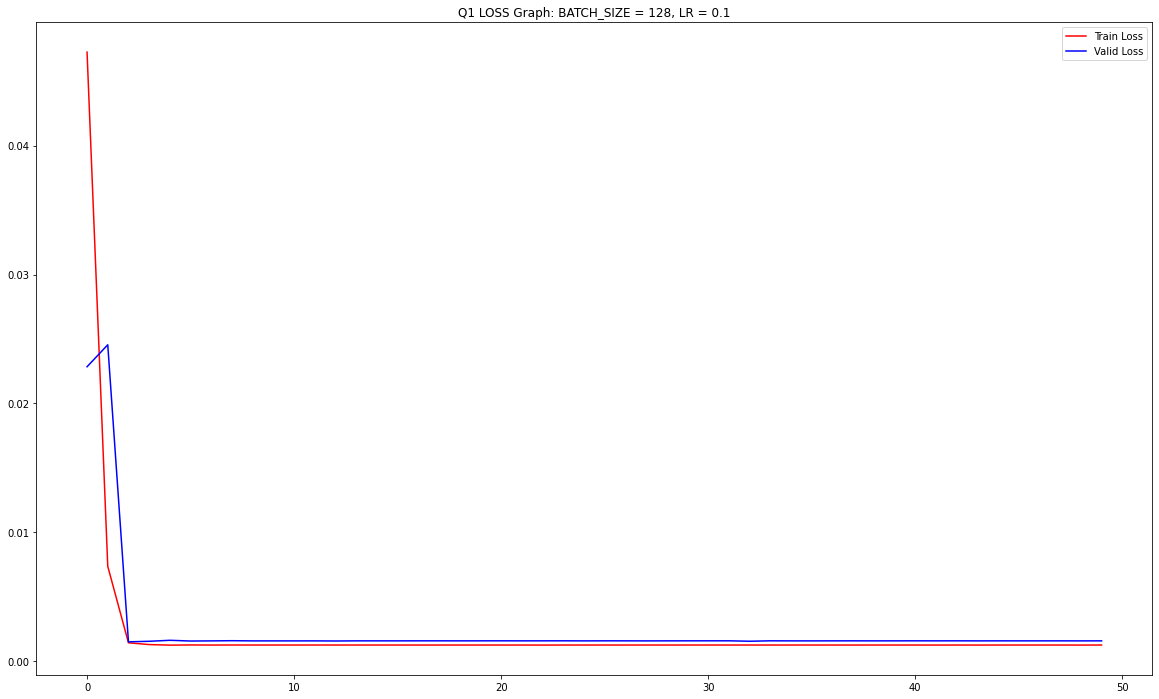

In [27]:
x = np.arange(len(train_loss))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss, color='r', label='Train Loss')
plt.plot(x, valid_loss, color='b', label='Valid Loss')
plt.title(f"Q1 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [28]:
def mape(truths, preds):
    return np.mean(np.abs((truths - preds) / truths)) * 100

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

In [29]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    truths, preds = [], []
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        for each in y:
            truths.append(each.cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            for each in y_hat:
                preds.append(each.cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    truths = test_scaler.inverse_transform(truths)
    preds = test_scaler.inverse_transform(preds)
    print('MAPE:', mape(truths, preds))
    print('MAE:', MAE(truths, preds))
    print('MSE:', MSE(truths, preds))
    print('R2 Score:', r2_score(truths, preds))
    
    return truths, preds

In [30]:
truths, preds = test(params, test_loader, 'model.pth')

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


100%|██████████| 99/99 [00:01<00:00, 98.17it/s] 

MAPE: 5.268349125981331
MAE: 10297.624
MSE: 190067630.0
R2 Score: 0.766958621277085


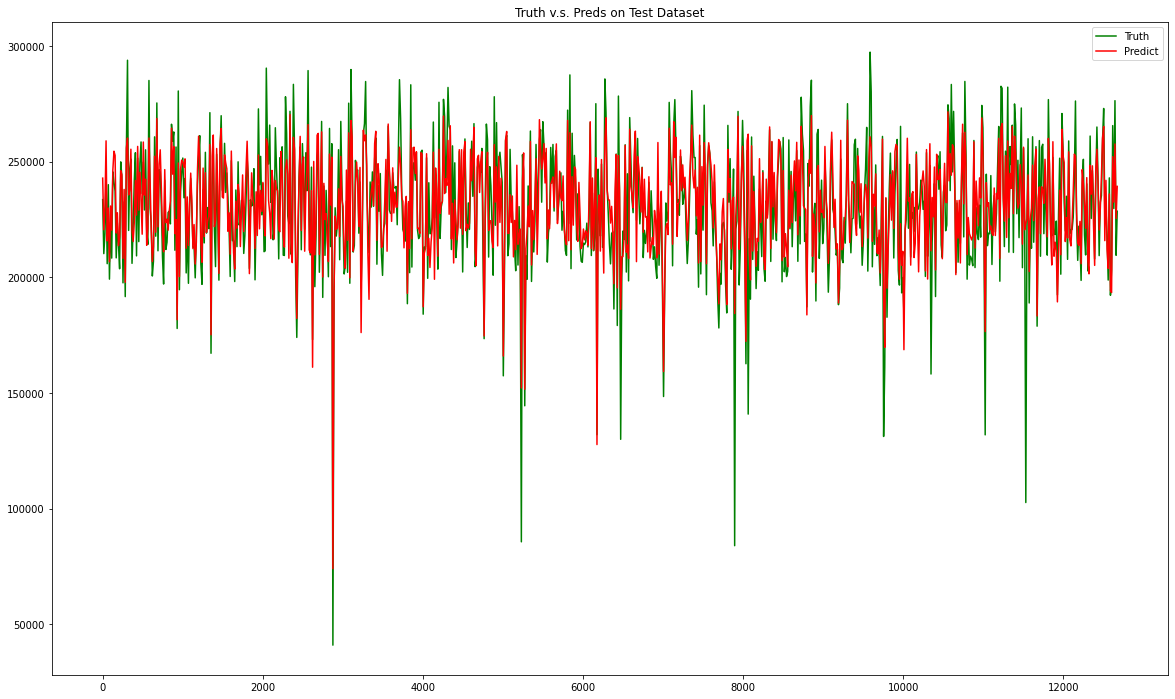

In [31]:
from scipy.interpolate import make_interp_spline

x = [i for i in range(1, len(truths) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths)(x_smth)
preds_smth = make_interp_spline(x, preds)(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Truth v.s. Preds on Test Dataset')
plt.show()

# Question 2

In [32]:
df = pd.read_csv('15min_freq.csv')
df.head()

Date        Power
0  2018-01-01 00:00:00  244033.7682
1  2018-01-01 00:15:00  232720.6402
2  2018-01-01 00:30:00  231685.6891
3  2018-01-01 00:45:00  227581.3317
4  2018-01-01 01:00:00  233482.4269

In [33]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour
df['Minute'] = df['Date'].dt.minute
df['Tick'] = df['Hour'] * 4 + df['Minute'] // 15
df.drop(columns=['Date'], inplace=True)
df.head()

Power  Year  Month  Day  Hour  Minute  Tick
0  244033.7682  2018      1    1     0       0     0
1  232720.6402  2018      1    1     0      15     1
2  231685.6891  2018      1    1     0      30     2
3  227581.3317  2018      1    1     0      45     3
4  233482.4269  2018      1    1     1       0     4

In [34]:
groups = df.groupby(['Year', 'Month', 'Day'], as_index=False)
columns = ['Power', 'Year', 'Month', 'Day', 'Hour', 'Minute']
data_daily_max = pd.DataFrame(columns=columns)
data_daily_min = pd.DataFrame(columns=columns)
for group in groups:
    _, meta = group
    max_row = meta[meta['Power'] == meta['Power'].max()]
    min_row = meta[meta['Power'] == meta['Power'].min()]
    data_daily_max = pd.concat([data_daily_max, max_row], ignore_index=True)
    data_daily_min = pd.concat([data_daily_min, min_row], ignore_index=True)

In [35]:
data_daily_max.head()

Power  Year Month Day Hour Minute  Tick
0  257733.9648  2018     1   1   19     45  79.0
1  288502.5947  2018     1   2   20     30  82.0
2  300698.5858  2018     1   3   18     15  73.0
3  293806.5077  2018     1   4   14     45  59.0
4  295075.2147  2018     1   5   18     30  74.0

In [36]:
data_daily_min.head()

Power  Year Month Day Hour Minute  Tick
0  203793.5753  2018     1   1    8     15  33.0
1  183505.2648  2018     1   2    4     15  17.0
2  220601.5301  2018     1   3    4     15  17.0
3  224981.5866  2018     1   4    4     45  19.0
4  224667.8170  2018     1   5    4     15  17.0

Text(0.5, 1.0, 'Daily Power Max & Min')

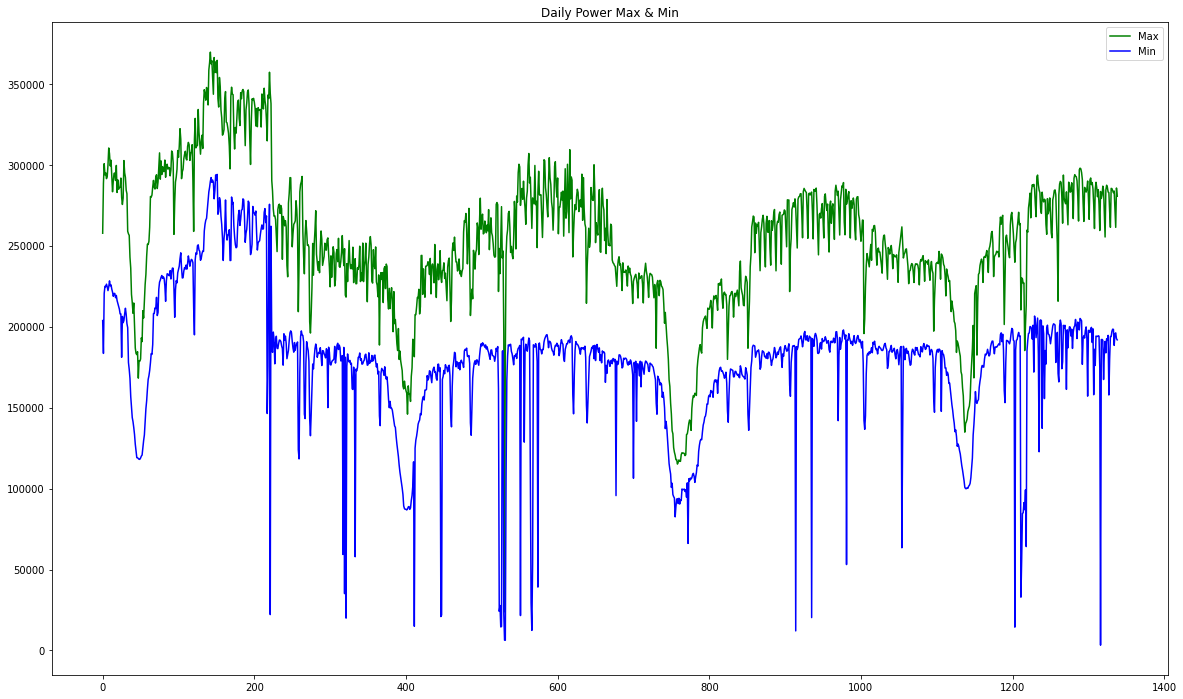

In [37]:
plt.figure(figsize=(20, 12))
x = np.arange(len(data_daily_max))
plt.plot(x, data_daily_max['Power'], c='g', label='Max')
plt.plot(x, data_daily_min['Power'], c='b', label='Min')
plt.legend()
plt.title('Daily Power Max & Min')

Text(0.5, 1.0, 'Daily Max and Min Time (As Tick)')

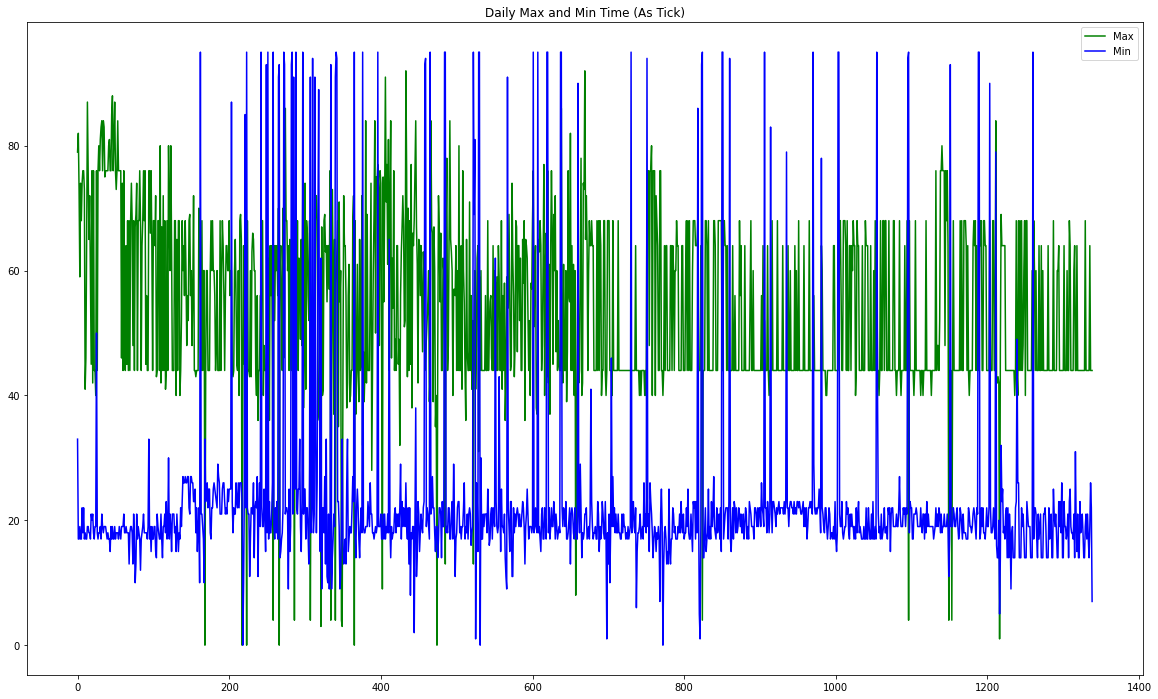

In [38]:
plt.figure(figsize=(20, 12))
x = np.arange(len(data_daily_max))
plt.plot(x, data_daily_max['Tick'], c='g', label='Max')
plt.plot(x, data_daily_min['Tick'], c='b', label='Min')
plt.legend()
plt.title('Daily Max and Min Time (As Tick)')

In [39]:
data_daily_max['Date'] = pd.to_datetime(data_daily_max[['Year', 'Month', 'Day']])
data_daily_min['Date'] = pd.to_datetime(data_daily_min[['Year', 'Month', 'Day']])

In [40]:
weather_data = pd.read_csv('../input/electrical-energy-load/train/3.csv')
weather_data.head()

日期   天气状况 最高温度 最低温度    白天风力风向    夜晚风力风向
0  2018年1月1日  多云/多云  22℃  12℃  无持续风向<3级  无持续风向<3级
1  2018年1月1日  多云/多云  22℃  12℃  无持续风向<3级  无持续风向<3级
2  2018年1月2日  多云/多云  22℃  15℃  无持续风向<3级  无持续风向<3级
3  2018年1月3日   多云/阴  23℃  15℃  无持续风向<3级  无持续风向<3级
4  2018年1月4日  多云/小雨  21℃  16℃  无持续风向<3级  无持续风向<3级

In [41]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345 entries, 0 to 1344
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   日期      1345 non-null   object
 1   天气状况    1345 non-null   object
 2   最高温度    1345 non-null   object
 3   最低温度    1345 non-null   object
 4   白天风力风向  1345 non-null   object
 5   夜晚风力风向  1345 non-null   object
dtypes: object(6)
memory usage: 63.2+ KB


In [42]:
weather_data.columns = ['Date', 'Weather', 'HighTemp', 'LowTemp', 'DayWind', 'NightWind']
weather_data['Date'] = weather_data['Date'].apply(lambda x: x.replace('年', '-'))
weather_data['Date'] = weather_data['Date'].apply(lambda x: x.replace('月', '-'))
weather_data['Date'] = weather_data['Date'].apply(lambda x: x.replace('日', '-'))
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
weather_data.head()

Date Weather HighTemp LowTemp   DayWind NightWind
0 2018-01-01   多云/多云      22℃     12℃  无持续风向<3级  无持续风向<3级
1 2018-01-01   多云/多云      22℃     12℃  无持续风向<3级  无持续风向<3级
2 2018-01-02   多云/多云      22℃     15℃  无持续风向<3级  无持续风向<3级
3 2018-01-03    多云/阴      23℃     15℃  无持续风向<3级  无持续风向<3级
4 2018-01-04   多云/小雨      21℃     16℃  无持续风向<3级  无持续风向<3级

In [43]:
weather_data['HighTemp'] = weather_data['HighTemp'].apply(lambda x: int(x[:-1]))
weather_data['LowTemp'] = weather_data['LowTemp'].apply(lambda x: int(x[:-1]))
weather_data['HighTemp'] = weather_data['HighTemp'].astype('int32')
weather_data['LowTemp'] = weather_data['LowTemp'].astype('int32')
weather_data.head()

Date Weather  HighTemp  LowTemp   DayWind NightWind
0 2018-01-01   多云/多云        22       12  无持续风向<3级  无持续风向<3级
1 2018-01-01   多云/多云        22       12  无持续风向<3级  无持续风向<3级
2 2018-01-02   多云/多云        22       15  无持续风向<3级  无持续风向<3级
3 2018-01-03    多云/阴        23       15  无持续风向<3级  无持续风向<3级
4 2018-01-04   多云/小雨        21       16  无持续风向<3级  无持续风向<3级

In [44]:
weather_data['Weather1'] = weather_data['Weather'].apply(lambda x: x.split('/')[0])
weather_data['Weather2'] = weather_data['Weather'].apply(lambda x: x.split('/')[1])
weather_data.drop(columns=['Weather'], inplace=True)
weather_data['Weather1'].value_counts(), weather_data['Weather2'].value_counts()

(多云       447
 雷阵雨      213
 阴        172
 晴        158
 阵雨        96
 中雨        87
 小雨        78
 大雨        52
 暴雨        14
 中到大雨      10
 小雨-中雨      8
 中雨-大雨      4
 雾          2
 小到中雨       2
 晴间多云       1
 大到暴雨       1
 Name: Weather1, dtype: int64,
 多云       574
 阴        187
 晴        142
 雷阵雨      131
 阵雨       103
 小雨        77
 中雨        68
 大雨        33
 暴雨         8
 小到中雨       7
 大到暴雨       4
 雾          3
 中到大雨       3
 中雨-大雨      2
 小雨-中雨      2
 局部多云       1
 Name: Weather2, dtype: int64)

In [45]:
from sklearn.preprocessing import OneHotEncoder

weather_encoder = OneHotEncoder(handle_unknown='ignore')
weather_encoder.fit(weather_data[['Weather1', 'Weather2']].values)
mat = weather_encoder.transform(weather_data[['Weather1', 'Weather2']].values).toarray()
feature_labels = np.array(weather_encoder.categories_).ravel()

columns = []
for col in ['Weather1', 'Weather2']:
    for val in weather_data[col].unique():
        columns.append('{}_{}'.format(col, val))
        
onehot_codes = pd.DataFrame(data=mat, columns=columns, dtype=int)
weather_data = pd.concat([weather_data, onehot_codes], axis=1)
weather_data.head()

Date  HighTemp  LowTemp   DayWind NightWind Weather1 Weather2  \
0 2018-01-01        22       12  无持续风向<3级  无持续风向<3级       多云       多云   
1 2018-01-01        22       12  无持续风向<3级  无持续风向<3级       多云       多云   
2 2018-01-02        22       15  无持续风向<3级  无持续风向<3级       多云       多云   
3 2018-01-03        23       15  无持续风向<3级  无持续风向<3级       多云        阴   
4 2018-01-04        21       16  无持续风向<3级  无持续风向<3级       多云       小雨   

   Weather1_多云  Weather1_阴  Weather1_小雨-中雨  ...  Weather2_晴  Weather2_局部多云  \
0            0           0               0  ...           0              0   
1            0           0               0  ...           0              0   
2            0           0               0  ...           0              0   
3            0           0               0  ...           0              0   
4            0           0               0  ...           0              1   

   Weather2_阵雨  Weather2_雾  Weather2_雷阵雨  Weather2_大雨  Weather2_暴雨  \
0            0           0             0            0            0   
1            0           0             0            0            0   
2            0           0             0            0            0   
3            0           0             0            0            1   
4            0           0             0            0            0   

   Weather2_中到大雨  Weather2_小到中雨  Weather2_大到暴雨  
0              0              0              0  
1              0              0              0  
2              0              0              0  
3              0              0              0  
4              0              0              0  

[5 rows x 39 columns]

In [46]:
wind_encoder = OneHotEncoder(handle_unknown='ignore')
wind_encoder.fit(weather_data[['DayWind', 'NightWind']].values)
mat = wind_encoder.transform(weather_data[['DayWind', 'NightWind']].values).toarray()
feature_labels = np.array(wind_encoder.categories_).ravel()

columns = []
for col in ['DayWind', 'NightWind']:
    for val in weather_data[col].unique():
        columns.append('{}_{}'.format(col, val))

onehot_codes = pd.DataFrame(data=mat, columns=columns, dtype=int)
weather_data = pd.concat([weather_data, onehot_codes], axis=1)
weather_data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


Date  HighTemp  LowTemp   DayWind NightWind Weather1 Weather2  \
0 2018-01-01        22       12  无持续风向<3级  无持续风向<3级       多云       多云   
1 2018-01-01        22       12  无持续风向<3级  无持续风向<3级       多云       多云   
2 2018-01-02        22       15  无持续风向<3级  无持续风向<3级       多云       多云   
3 2018-01-03        23       15  无持续风向<3级  无持续风向<3级       多云        阴   
4 2018-01-04        21       16  无持续风向<3级  无持续风向<3级       多云       小雨   

   Weather1_多云  Weather1_阴  Weather1_小雨-中雨  ...  NightWind_北风3-4级  \
0            0           0               0  ...                 0   
1            0           0               0  ...                 0   
2            0           0               0  ...                 0   
3            0           0               0  ...                 0   
4            0           0               0  ...                 0   

   NightWind_北风4-5级  NightWind_南风3-4级  NightWind_南风1-2级  NightWind_东南风1-2级  \
0                 0                 0                 0                  0   
1                 0                 0                 0                  0   
2                 0                 0                 0                  0   
3                 0                 0                 0                  0   
4                 0                 0                 0                  0   

   NightWind_西南风3-4级  NightWind_东风1-2级  NightWind_北风1-2级  NightWind_东北风1-2级  \
0                  0                 1                 0                  0   
1                  0                 1                 0                  0   
2                  0                 1                 0                  0   
3                  0                 1                 0                  0   
4                  0                 1                 0                  0   

   NightWind_西南风1-2级  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 90 columns]

In [47]:
weather_data.shape

(1345, 90)

In [48]:
weather_data.drop(columns=['DayWind', 'NightWind', 'Weather1', 'Weather2'], inplace=True)
weather_data = weather_data.drop_duplicates(subset=['Date']).reset_index()
weather_data.shape

(1339, 87)

In [49]:
daily_max_data = pd.merge(data_daily_max, weather_data, on='Date')
daily_min_data = pd.merge(data_daily_min, weather_data, on='Date')

In [50]:
daily_max_data.index = daily_max_data['Date']
daily_min_data.index = daily_min_data['Date']
daily_max_data.drop(columns=['Date', 'index', 'Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)
daily_min_data.drop(columns=['Date', 'index', 'Year', 'Month', 'Day', 'Hour', 'Minute'], inplace=True)

In [51]:
daily_max_data.head()

Power  Tick  HighTemp  LowTemp  Weather1_多云  Weather1_阴  \
Date                                                                        
2018-01-01  257733.9648  79.0        22       12            0           0   
2018-01-02  288502.5947  82.0        22       15            0           0   
2018-01-03  300698.5858  73.0        23       15            0           0   
2018-01-04  293806.5077  59.0        21       16            0           0   
2018-01-05  295075.2147  74.0        19       13            0           0   

            Weather1_小雨-中雨  Weather1_大雨  Weather1_中雨  Weather1_小雨  ...  \
Date                                                               ...   
2018-01-01               0            1            0            0  ...   
2018-01-02               0            1            0            0  ...   
2018-01-03               0            1            0            0  ...   
2018-01-04               0            1            0            0  ...   
2018-01-05               0            0            0            0  ...   

            NightWind_北风3-4级  NightWind_北风4-5级  NightWind_南风3-4级  \
Date                                                               
2018-01-01                 0                 0                 0   
2018-01-02                 0                 0                 0   
2018-01-03                 0                 0                 0   
2018-01-04                 0                 0                 0   
2018-01-05                 0                 0                 0   

            NightWind_南风1-2级  NightWind_东南风1-2级  NightWind_西南风3-4级  \
Date                                                                 
2018-01-01                 0                  0                  0   
2018-01-02                 0                  0                  0   
2018-01-03                 0                  0                  0   
2018-01-04                 0                  0                  0   
2018-01-05                 0                  0                  0   

            NightWind_东风1-2级  NightWind_北风1-2级  NightWind_东北风1-2级  \
Date                                                                
2018-01-01                 1                 0                  0   
2018-01-02                 1                 0                  0   
2018-01-03                 1                 0                  0   
2018-01-04                 1                 0                  0   
2018-01-05                 1                 0                  0   

            NightWind_西南风1-2级  
Date                           
2018-01-01                  0  
2018-01-02                  0  
2018-01-03                  0  
2018-01-04                  0  
2018-01-05                  0  

[5 rows x 87 columns]

In [52]:
daily_max_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1339 entries, 2018-01-01 to 2021-08-31
Data columns (total 87 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Power                1339 non-null   float64
 1   Tick                 1339 non-null   float64
 2   HighTemp             1339 non-null   int32  
 3   LowTemp              1339 non-null   int32  
 4   Weather1_多云          1339 non-null   int64  
 5   Weather1_阴           1339 non-null   int64  
 6   Weather1_小雨-中雨       1339 non-null   int64  
 7   Weather1_大雨          1339 non-null   int64  
 8   Weather1_中雨          1339 non-null   int64  
 9   Weather1_小雨          1339 non-null   int64  
 10  Weather1_晴           1339 non-null   int64  
 11  Weather1_雷阵雨         1339 non-null   int64  
 12  Weather1_雾           1339 non-null   int64  
 13  Weather1_阵雨          1339 non-null   int64  
 14  Weather1_中雨-大雨       1339 non-null   int64  
 15  Weather1_晴间多云       

In [53]:
# from sklearn.feature_selection import VarianceThreshold

# daily_max_data = daily_max_data.values
# daily_min_data = daily_min_data.values

# max_selector = VarianceThreshold(threshold=0.16)
# daily_max_data = np.concatenate([daily_max_data[:, :2], max_selector.fit_transform(daily_max_data[:, 2:])], axis=1)

# min_selector = VarianceThreshold(threshold=0.16)
# daily_min_data = np.concatenate([daily_min_data[:, :2], min_selector.fit_transform(daily_min_data[:, 2:])], axis=1)

In [54]:
daily_max_data

Power  Tick  HighTemp  LowTemp  Weather1_多云  Weather1_阴  \
Date                                                                        
2018-01-01  257733.9648  79.0        22       12            0           0   
2018-01-02  288502.5947  82.0        22       15            0           0   
2018-01-03  300698.5858  73.0        23       15            0           0   
2018-01-04  293806.5077  59.0        21       16            0           0   
2018-01-05  295075.2147  74.0        19       13            0           0   
...                 ...   ...       ...      ...          ...         ...   
2021-08-27  283786.5080  44.0        35       26            0           0   
2021-08-28  272522.5991  64.0        33       26            0           0   
2021-08-29  261364.9171  44.0        32       25            0           0   
2021-08-30  285669.1430  44.0        34       26            0           0   
2021-08-31  280565.9749  44.0        32       26            0           0   

            Weather1_小雨-中雨  Weather1_大雨  Weather1_中雨  Weather1_小雨  ...  \
Date                                                               ...   
2018-01-01               0            1            0            0  ...   
2018-01-02               0            1            0            0  ...   
2018-01-03               0            1            0            0  ...   
2018-01-04               0            1            0            0  ...   
2018-01-05               0            0            0            0  ...   
...                    ...          ...          ...          ...  ...   
2021-08-27               0            0            0            0  ...   
2021-08-28               0            0            0            0  ...   
2021-08-29               0            0            0            0  ...   
2021-08-30               0            0            0            0  ...   
2021-08-31               0            0            0            0  ...   

            NightWind_北风3-4级  NightWind_北风4-5级  NightWind_南风3-4级  \
Date                                                               
2018-01-01                 0                 0                 0   
2018-01-02                 0                 0                 0   
2018-01-03                 0                 0                 0   
2018-01-04                 0                 0                 0   
2018-01-05                 0                 0                 0   
...                      ...               ...               ...   
2021-08-27                 0                 0                 0   
2021-08-28                 0                 0                 0   
2021-08-29                 0                 0                 0   
2021-08-30                 0                 0                 0   
2021-08-31                 0                 0                 0   

            NightWind_南风1-2级  NightWind_东南风1-2级  NightWind_西南风3-4级  \
Date                                                                 
2018-01-01                 0                  0                  0   
2018-01-02                 0                  0                  0   
2018-01-03                 0                  0                  0   
2018-01-04                 0                  0                  0   
2018-01-05                 0                  0                  0   
...                      ...                ...                ...   
2021-08-27                 0                  0                  0   
2021-08-28                 0                  0                  0   
2021-08-29                 0                  0                  0   
2021-08-30                 0                  0                  0   
2021-08-31                 0                  0                  0   

            NightWind_东风1-2级  NightWind_北风1-2级  NightWind_东北风1-2级  \
Date                                                                
2018-01-01                 1                 0                  0   
2018-01-02                 1                 0    

In [55]:
from scipy.signal import savgol_filter as SGFilt

train_bin_max, valid_bin_max, test_bin_max = split_dataset(daily_max_data, .7, .1)
train_bin_min, valid_bin_min, test_bin_min = split_dataset(daily_min_data, .7, .1)

w, p = 7, 3
train_bin_max['Power'] = SGFilt(train_bin_max['Power'], w, p)
train_bin_max['Tick'] = SGFilt(train_bin_max['Tick'], w, p)
train_bin_min['Power'] = SGFilt(train_bin_min['Power'], w, p)
train_bin_min['Tick'] = SGFilt(train_bin_min['Tick'], w, p)

In [56]:
test_max_power_range = [test_bin_max['Power'].min(), test_bin_max['Power'].max()]
test_max_tick_range = [test_bin_max['Tick'].min(), test_bin_max['Tick'].max()]

test_min_power_range = [test_bin_min['Power'].min(), test_bin_min['Power'].max()]
test_min_tick_range = [test_bin_min['Tick'].min(), test_bin_min['Tick'].max()]

In [57]:
def scaling(data):
    scaler = MinMaxScaler()
    return scaler, scaler.fit_transform(data)

In [58]:
train_max_scaler, train_max = scaling(train_bin_max)
train_min_scaler, train_min = scaling(train_bin_min)
valid_max_scaler, valid_max = scaling(valid_bin_max)
valid_min_scaler, valid_min = scaling(valid_bin_min)
test_max_scaler, test_max = scaling(test_bin_max)
test_min_scaler, test_min = scaling(test_bin_min)

Now daily max data on: train_max, valid_max, test_max

Now daily min data on: train_min, valid_min, test_min


## 2.1 For Daily Max

### 2.1.1 multi-output LSTM Regression Trail

In [59]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size, :2].reshape(2, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [60]:
window_size, predict_size = 14, 1

X_train, y_train = preprocessing(train_max, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_max, window_size, predict_size)
X_test, y_test = preprocessing(test_max, window_size, predict_size)

In [61]:
X_train.shape

torch.Size([922, 14, 87])

In [62]:
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [63]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [64]:
print('Train set:', X_train.shape, y_train.shape)
print('Valid set:', X_valid.shape, y_valid.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: torch.Size([922, 14, 87]) torch.Size([922, 2, 1])
Valid set: torch.Size([118, 14, 87]) torch.Size([118, 2, 1])
Test set: torch.Size([254, 14, 87]) torch.Size([254, 2, 1])


In [65]:
class LSTM_multi(nn.Module):
    def __init__(self, input_size, hidden_size,
                 num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_directions = 1
        self.lstm = nn.LSTM(self.input_size, self.hidden_size,
                            self.num_layers, batch_first=True)
#         self.reg_pred = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size // 2),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 2, self.hidden_size // 4),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 4, self.output_size))
#         self.reg_time = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size // 2),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 2, self.hidden_size // 4),
#                                       nn.ReLU(),
#                                       nn.Linear(self.hidden_size // 4, self.output_size))
        self.linear_pred = nn.Linear(self.hidden_size, self.output_size)
        self.linear_time = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, X):
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        output, _ = self.lstm(X, (h_0, c_0))
        o = output[:, -1, :]
        pred, time = self.linear_pred(o), self.linear_time(o)
#         pred, time = self.reg_pred(o), self.reg_time(o)
        preds = torch.stack([pred, time], dim=0)
        return preds

In [66]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 512,
          'output_size': predict_size,
          'num_outputs': 2,
          'num_layers': 20, 
          'learning_rate': 0.5,
          'weight_decay': 1e-2,
          'step_size': 10,
          'gamma': 0.1,
          'epochs': 100}

In [67]:
def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    num_outputs = params['num_outputs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 10 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss

In [68]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_max.pth')

LSTM_multi(
  (lstm): LSTM(87, 512, num_layers=20, batch_first=True)
  (linear_pred): Linear(in_features=512, out_features=1, bias=True)
  (linear_time): Linear(in_features=512, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0, train loss 0.272332
Step 10, train loss 144.228241
Step 20, train loss 218.752014
Step 30, train loss 125.137100
Step 40, train loss 292.849548
Step 50, train loss 165.003998


  1%|          | 1/100 [00:03<05:48,  3.52s/it]

Epoch [1/100], train loss 187.702318, valid loss 248.110018. Now best: 248.110018
Step 0, train loss 121.303680
Step 10, train loss 144.752014
Step 20, train loss 153.489563
Step 30, train loss 172.688568
Step 40, train loss 134.042114
Step 50, train loss 121.891739


  2%|▏         | 2/100 [00:07<05:56,  3.64s/it]

Epoch [2/100], train loss 195.898117, valid loss 213.640069. Now best: 213.640069
Step 0, train loss 100.085869
Step 10, train loss 194.133530
Step 20, train loss 259.132874
Step 30, train loss 80.948639
Step 40, train loss 126.280968
Step 50, train loss 265.227234


  3%|▎         | 3/100 [00:10<05:52,  3.63s/it]

Epoch [3/100], train loss 173.819608, valid loss 139.770193. Now best: 139.770193
Step 0, train loss 124.431786
Step 10, train loss 117.955475
Step 20, train loss 75.721542
Step 30, train loss 38.895069
Step 40, train loss 71.943382
Step 50, train loss 128.811310


  4%|▍         | 4/100 [00:14<05:48,  3.63s/it]

Epoch [4/100], train loss 116.058980, valid loss 121.262901. Now best: 121.262901
Step 0, train loss 68.137527
Step 10, train loss 110.882057
Step 20, train loss 155.473480
Step 30, train loss 38.327274
Step 40, train loss 97.107300
Step 50, train loss 194.825806


  5%|▌         | 5/100 [00:18<05:47,  3.66s/it]

Epoch [5/100], train loss 113.268499, valid loss 91.425986. Now best: 91.425986
Step 0, train loss 90.818878
Step 10, train loss 130.212250
Step 20, train loss 124.863678
Step 30, train loss 214.704773
Step 40, train loss 156.854355
Step 50, train loss 162.110718


  6%|▌         | 6/100 [00:21<05:27,  3.49s/it]

Epoch [6/100], train loss 140.280958, valid loss 127.943130. Now best: 91.425986
Step 0, train loss 190.346252
Step 10, train loss 144.542892
Step 20, train loss 169.252777
Step 30, train loss 279.659698
Step 40, train loss 314.784363
Step 50, train loss 145.579285


  7%|▋         | 7/100 [00:24<05:12,  3.36s/it]

Epoch [7/100], train loss 180.145411, valid loss 166.944965. Now best: 91.425986
Step 0, train loss 203.371887
Step 10, train loss 176.816986
Step 20, train loss 226.013763
Step 30, train loss 281.709259
Step 40, train loss 194.884613
Step 50, train loss 60.399387


  8%|▊         | 8/100 [00:27<05:00,  3.27s/it]

Epoch [8/100], train loss 188.918719, valid loss 206.158842. Now best: 91.425986
Step 0, train loss 260.594727
Step 10, train loss 226.687164
Step 20, train loss 100.303024
Step 30, train loss 158.063904
Step 40, train loss 175.960876
Step 50, train loss 215.242371


  9%|▉         | 9/100 [00:30<04:52,  3.21s/it]

Epoch [9/100], train loss 190.422311, valid loss 246.748668. Now best: 91.425986
Step 0, train loss 231.327744
Step 10, train loss 160.803009
Step 20, train loss 377.868652
Step 30, train loss 213.031158
Step 40, train loss 257.582642
Step 50, train loss 173.199646


 10%|█         | 10/100 [00:33<04:45,  3.17s/it]

Epoch [10/100], train loss 216.137214, valid loss 204.839450. Now best: 91.425986
Step 0, train loss 171.087128
Step 10, train loss 309.238525
Step 20, train loss 173.815277
Step 30, train loss 161.562012
Step 40, train loss 155.971222
Step 50, train loss 111.499702


 11%|█         | 11/100 [00:36<04:39,  3.14s/it]

Epoch [11/100], train loss 170.202034, valid loss 125.770062. Now best: 91.425986
Step 0, train loss 104.279259
Step 10, train loss 96.134377
Step 20, train loss 71.884659
Step 30, train loss 112.671158
Step 40, train loss 134.071686
Step 50, train loss 46.248306


 12%|█▏        | 12/100 [00:40<04:51,  3.31s/it]

Epoch [12/100], train loss 82.069062, valid loss 57.282904. Now best: 57.282904
Step 0, train loss 53.398842
Step 10, train loss 61.018517
Step 20, train loss 42.264008
Step 30, train loss 45.435230
Step 40, train loss 34.496445
Step 50, train loss 36.568401


 13%|█▎        | 13/100 [00:44<04:57,  3.42s/it]

Epoch [13/100], train loss 40.913198, valid loss 27.859434. Now best: 27.859434
Step 0, train loss 32.099930
Step 10, train loss 15.561420
Step 20, train loss 15.619967
Step 30, train loss 13.579258
Step 40, train loss 17.256729
Step 50, train loss 14.050916


 14%|█▍        | 14/100 [00:47<04:59,  3.49s/it]

Epoch [14/100], train loss 19.918571, valid loss 14.671369. Now best: 14.671369
Step 0, train loss 17.583324
Step 10, train loss 13.084242
Step 20, train loss 13.076508
Step 30, train loss 13.348547
Step 40, train loss 9.515314
Step 50, train loss 6.243622


 15%|█▌        | 15/100 [00:51<05:01,  3.55s/it]

Epoch [15/100], train loss 10.812805, valid loss 5.762725. Now best: 5.762725
Step 0, train loss 3.835357
Step 10, train loss 5.104251
Step 20, train loss 4.758965
Step 30, train loss 3.250170
Step 40, train loss 5.098682
Step 50, train loss 5.358694


 16%|█▌        | 16/100 [00:55<05:02,  3.60s/it]

Epoch [16/100], train loss 5.103664, valid loss 3.610195. Now best: 3.610195
Step 0, train loss 3.333800
Step 10, train loss 3.468844
Step 20, train loss 2.529312
Step 30, train loss 1.065314
Step 40, train loss 1.765788
Step 50, train loss 2.348459


 17%|█▋        | 17/100 [00:58<04:59,  3.61s/it]

Epoch [17/100], train loss 2.389796, valid loss 1.781837. Now best: 1.781837
Step 0, train loss 1.782500
Step 10, train loss 1.229976
Step 20, train loss 0.465202
Step 30, train loss 1.529500
Step 40, train loss 1.659538
Step 50, train loss 0.761469


 18%|█▊        | 18/100 [01:02<04:56,  3.62s/it]

Epoch [18/100], train loss 1.276206, valid loss 1.127390. Now best: 1.127390
Step 0, train loss 0.564613
Step 10, train loss 0.737823
Step 20, train loss 1.197553
Step 30, train loss 0.477627
Step 40, train loss 0.263261
Step 50, train loss 0.426873


 19%|█▉        | 19/100 [01:06<04:53,  3.63s/it]

Epoch [19/100], train loss 0.664971, valid loss 0.518036. Now best: 0.518036
Step 0, train loss 0.562505
Step 10, train loss 0.389941
Step 20, train loss 0.360259
Step 30, train loss 0.337585
Step 40, train loss 0.240303
Step 50, train loss 0.244220


 20%|██        | 20/100 [01:09<04:50,  3.63s/it]

Epoch [20/100], train loss 0.325242, valid loss 0.261880. Now best: 0.261880
Step 0, train loss 0.102456
Step 10, train loss 0.306378
Step 20, train loss 0.463483
Step 30, train loss 0.230120
Step 40, train loss 0.193723
Step 50, train loss 0.346978


 21%|██        | 21/100 [01:12<04:34,  3.48s/it]

Epoch [21/100], train loss 0.207950, valid loss 0.298785. Now best: 0.261880
Step 0, train loss 0.230777
Step 10, train loss 0.096281
Step 20, train loss 0.137299
Step 30, train loss 0.216673
Step 40, train loss 0.150147
Step 50, train loss 0.161832


 22%|██▏       | 22/100 [01:15<04:21,  3.36s/it]

Epoch [22/100], train loss 0.181933, valid loss 0.286788. Now best: 0.261880
Step 0, train loss 0.134490
Step 10, train loss 0.108755
Step 20, train loss 0.289456
Step 30, train loss 0.178933
Step 40, train loss 0.085755
Step 50, train loss 0.172298


 23%|██▎       | 23/100 [01:19<04:11,  3.27s/it]

Epoch [23/100], train loss 0.169540, valid loss 0.281065. Now best: 0.261880
Step 0, train loss 0.207787
Step 10, train loss 0.202045
Step 20, train loss 0.121213
Step 30, train loss 0.155639
Step 40, train loss 0.163136
Step 50, train loss 0.134427


 24%|██▍       | 24/100 [01:22<04:16,  3.38s/it]

Epoch [24/100], train loss 0.155340, valid loss 0.208102. Now best: 0.208102
Step 0, train loss 0.137329
Step 10, train loss 0.104127
Step 20, train loss 0.158142
Step 30, train loss 0.154715
Step 40, train loss 0.141326
Step 50, train loss 0.163255


 25%|██▌       | 25/100 [01:25<04:10,  3.34s/it]

Epoch [25/100], train loss 0.145544, valid loss 0.225622. Now best: 0.208102
Step 0, train loss 0.079278
Step 10, train loss 0.125349
Step 20, train loss 0.138344
Step 30, train loss 0.109997
Step 40, train loss 0.154298
Step 50, train loss 0.102894


 26%|██▌       | 26/100 [01:29<04:13,  3.42s/it]

Epoch [26/100], train loss 0.132567, valid loss 0.200570. Now best: 0.200570
Step 0, train loss 0.103874
Step 10, train loss 0.135050
Step 20, train loss 0.187649
Step 30, train loss 0.091346
Step 40, train loss 0.190398
Step 50, train loss 0.156215


 27%|██▋       | 27/100 [01:32<04:02,  3.32s/it]

Epoch [27/100], train loss 0.125695, valid loss 0.200998. Now best: 0.200570
Step 0, train loss 0.122366
Step 10, train loss 0.065051
Step 20, train loss 0.119703
Step 30, train loss 0.098130
Step 40, train loss 0.197957
Step 50, train loss 0.085188


 28%|██▊       | 28/100 [01:36<04:06,  3.42s/it]

Epoch [28/100], train loss 0.103120, valid loss 0.166583. Now best: 0.166583
Step 0, train loss 0.103790
Step 10, train loss 0.075531
Step 20, train loss 0.080898
Step 30, train loss 0.132238
Step 40, train loss 0.073221
Step 50, train loss 0.110539


 29%|██▉       | 29/100 [01:39<04:06,  3.48s/it]

Epoch [29/100], train loss 0.100780, valid loss 0.166483. Now best: 0.166483
Step 0, train loss 0.094401
Step 10, train loss 0.087670
Step 20, train loss 0.183682
Step 30, train loss 0.139560
Step 40, train loss 0.137445
Step 50, train loss 0.097135


 30%|███       | 30/100 [01:43<04:06,  3.52s/it]

Epoch [30/100], train loss 0.102589, valid loss 0.162134. Now best: 0.162134
Step 0, train loss 0.118741
Step 10, train loss 0.110799
Step 20, train loss 0.092779
Step 30, train loss 0.065323
Step 40, train loss 0.085310
Step 50, train loss 0.062065


 31%|███       | 31/100 [01:46<03:54,  3.40s/it]

Epoch [31/100], train loss 0.090546, valid loss 0.162317. Now best: 0.162134
Step 0, train loss 0.078914
Step 10, train loss 0.118723
Step 20, train loss 0.074545
Step 30, train loss 0.102529
Step 40, train loss 0.065153
Step 50, train loss 0.117994


 32%|███▏      | 32/100 [01:50<03:55,  3.46s/it]

Epoch [32/100], train loss 0.082165, valid loss 0.155693. Now best: 0.155693
Step 0, train loss 0.088935
Step 10, train loss 0.123426
Step 20, train loss 0.081178
Step 30, train loss 0.111400
Step 40, train loss 0.056861
Step 50, train loss 0.070573


 33%|███▎      | 33/100 [01:53<03:44,  3.35s/it]

Epoch [33/100], train loss 0.086025, valid loss 0.165551. Now best: 0.155693
Step 0, train loss 0.095359
Step 10, train loss 0.109095
Step 20, train loss 0.099702
Step 30, train loss 0.110541
Step 40, train loss 0.116371
Step 50, train loss 0.103654


 34%|███▍      | 34/100 [01:56<03:42,  3.38s/it]

Epoch [34/100], train loss 0.090591, valid loss 0.188878. Now best: 0.155693
Step 0, train loss 0.070103
Step 10, train loss 0.081410
Step 20, train loss 0.120777
Step 30, train loss 0.080292
Step 40, train loss 0.050935
Step 50, train loss 0.105996


 35%|███▌      | 35/100 [01:59<03:33,  3.29s/it]

Epoch [35/100], train loss 0.082346, valid loss 0.160945. Now best: 0.155693
Step 0, train loss 0.152222
Step 10, train loss 0.078295
Step 20, train loss 0.124614
Step 30, train loss 0.060148
Step 40, train loss 0.102600
Step 50, train loss 0.078877


 36%|███▌      | 36/100 [02:02<03:26,  3.23s/it]

Epoch [36/100], train loss 0.089099, valid loss 0.165469. Now best: 0.155693
Step 0, train loss 0.063557
Step 10, train loss 0.085106
Step 20, train loss 0.105964
Step 30, train loss 0.083683
Step 40, train loss 0.128586
Step 50, train loss 0.131046


 37%|███▋      | 37/100 [02:05<03:20,  3.18s/it]

Epoch [37/100], train loss 0.086243, valid loss 0.157436. Now best: 0.155693
Step 0, train loss 0.086870
Step 10, train loss 0.121718
Step 20, train loss 0.058073
Step 30, train loss 0.081959
Step 40, train loss 0.085740
Step 50, train loss 0.100953


 38%|███▊      | 38/100 [02:09<03:15,  3.16s/it]

Epoch [38/100], train loss 0.078184, valid loss 0.163653. Now best: 0.155693
Step 0, train loss 0.056028
Step 10, train loss 0.042664
Step 20, train loss 0.085924
Step 30, train loss 0.094363
Step 40, train loss 0.080101
Step 50, train loss 0.076036


 39%|███▉      | 39/100 [02:12<03:20,  3.29s/it]

Epoch [39/100], train loss 0.075592, valid loss 0.132449. Now best: 0.132449
Step 0, train loss 0.103119
Step 10, train loss 0.110195
Step 20, train loss 0.072650
Step 30, train loss 0.080981
Step 40, train loss 0.068922
Step 50, train loss 0.080810


 40%|████      | 40/100 [02:15<03:13,  3.22s/it]

Epoch [40/100], train loss 0.087056, valid loss 0.144885. Now best: 0.132449
Step 0, train loss 0.076607
Step 10, train loss 0.101816
Step 20, train loss 0.111031
Step 30, train loss 0.060854
Step 40, train loss 0.065598
Step 50, train loss 0.073623


 41%|████      | 41/100 [02:18<03:08,  3.19s/it]

Epoch [41/100], train loss 0.085891, valid loss 0.153469. Now best: 0.132449
Step 0, train loss 0.074659
Step 10, train loss 0.070880
Step 20, train loss 0.120372
Step 30, train loss 0.090296
Step 40, train loss 0.030982
Step 50, train loss 0.052783


 42%|████▏     | 42/100 [02:21<03:02,  3.15s/it]

Epoch [42/100], train loss 0.077452, valid loss 0.151145. Now best: 0.132449
Step 0, train loss 0.091480
Step 10, train loss 0.074607
Step 20, train loss 0.069303
Step 30, train loss 0.096777
Step 40, train loss 0.055016
Step 50, train loss 0.094085


 43%|████▎     | 43/100 [02:24<02:57,  3.12s/it]

Epoch [43/100], train loss 0.084222, valid loss 0.155051. Now best: 0.132449
Step 0, train loss 0.115576
Step 10, train loss 0.076383
Step 20, train loss 0.055004
Step 30, train loss 0.091276
Step 40, train loss 0.139053
Step 50, train loss 0.068508


 44%|████▍     | 44/100 [02:28<02:56,  3.15s/it]

Epoch [44/100], train loss 0.085348, valid loss 0.141861. Now best: 0.132449
Step 0, train loss 0.093166
Step 10, train loss 0.069747
Step 20, train loss 0.118439
Step 30, train loss 0.056311
Step 40, train loss 0.100316
Step 50, train loss 0.110820


 45%|████▌     | 45/100 [02:31<02:52,  3.14s/it]

Epoch [45/100], train loss 0.087764, valid loss 0.148778. Now best: 0.132449
Step 0, train loss 0.049172
Step 10, train loss 0.059344
Step 20, train loss 0.079249
Step 30, train loss 0.085799
Step 40, train loss 0.077232
Step 50, train loss 0.077740


 46%|████▌     | 46/100 [02:34<02:48,  3.12s/it]

Epoch [46/100], train loss 0.081245, valid loss 0.139357. Now best: 0.132449
Step 0, train loss 0.077116
Step 10, train loss 0.093845
Step 20, train loss 0.063972
Step 30, train loss 0.091693
Step 40, train loss 0.088528
Step 50, train loss 0.074520


 47%|████▋     | 47/100 [02:37<02:44,  3.10s/it]

Epoch [47/100], train loss 0.080923, valid loss 0.158801. Now best: 0.132449
Step 0, train loss 0.084856
Step 10, train loss 0.124218
Step 20, train loss 0.062210
Step 30, train loss 0.089555
Step 40, train loss 0.168211
Step 50, train loss 0.081608


 48%|████▊     | 48/100 [02:40<02:42,  3.12s/it]

Epoch [48/100], train loss 0.082051, valid loss 0.166616. Now best: 0.132449
Step 0, train loss 0.063937
Step 10, train loss 0.061597
Step 20, train loss 0.062553
Step 30, train loss 0.056572
Step 40, train loss 0.063027
Step 50, train loss 0.081123


 49%|████▉     | 49/100 [02:43<02:38,  3.10s/it]

Epoch [49/100], train loss 0.082078, valid loss 0.151110. Now best: 0.132449
Step 0, train loss 0.134685
Step 10, train loss 0.085757
Step 20, train loss 0.048478
Step 30, train loss 0.111100
Step 40, train loss 0.046442
Step 50, train loss 0.057677


 50%|█████     | 50/100 [02:46<02:34,  3.09s/it]

Epoch [50/100], train loss 0.084216, valid loss 0.159933. Now best: 0.132449
Step 0, train loss 0.070243
Step 10, train loss 0.078180
Step 20, train loss 0.095080
Step 30, train loss 0.109019
Step 40, train loss 0.099984
Step 50, train loss 0.037438


 51%|█████     | 51/100 [02:49<02:30,  3.08s/it]

Epoch [51/100], train loss 0.078982, valid loss 0.165149. Now best: 0.132449
Step 0, train loss 0.103719
Step 10, train loss 0.138508
Step 20, train loss 0.118013
Step 30, train loss 0.099408
Step 40, train loss 0.111589
Step 50, train loss 0.065314


 52%|█████▏    | 52/100 [02:52<02:27,  3.08s/it]

Epoch [52/100], train loss 0.084659, valid loss 0.163121. Now best: 0.132449
Step 0, train loss 0.115713
Step 10, train loss 0.070009
Step 20, train loss 0.078181
Step 30, train loss 0.072157
Step 40, train loss 0.054684
Step 50, train loss 0.047166


 53%|█████▎    | 53/100 [02:55<02:24,  3.07s/it]

Epoch [53/100], train loss 0.082621, valid loss 0.163487. Now best: 0.132449
Step 0, train loss 0.055941
Step 10, train loss 0.071214
Step 20, train loss 0.109263
Step 30, train loss 0.050848
Step 40, train loss 0.094119
Step 50, train loss 0.053444


 54%|█████▍    | 54/100 [02:59<02:22,  3.09s/it]

Epoch [54/100], train loss 0.083924, valid loss 0.151671. Now best: 0.132449
Step 0, train loss 0.107166
Step 10, train loss 0.086769
Step 20, train loss 0.072078
Step 30, train loss 0.095746
Step 40, train loss 0.061186
Step 50, train loss 0.096679


 55%|█████▌    | 55/100 [03:02<02:21,  3.15s/it]

Epoch [55/100], train loss 0.088046, valid loss 0.154011. Now best: 0.132449
Step 0, train loss 0.055920
Step 10, train loss 0.141616
Step 20, train loss 0.110742
Step 30, train loss 0.069716
Step 40, train loss 0.054847
Step 50, train loss 0.099022


 56%|█████▌    | 56/100 [03:05<02:18,  3.14s/it]

Epoch [56/100], train loss 0.075291, valid loss 0.151076. Now best: 0.132449
Step 0, train loss 0.086377
Step 10, train loss 0.062913
Step 20, train loss 0.057903
Step 30, train loss 0.099787
Step 40, train loss 0.090820
Step 50, train loss 0.074567


 57%|█████▋    | 57/100 [03:08<02:13,  3.11s/it]

Epoch [57/100], train loss 0.077940, valid loss 0.167478. Now best: 0.132449
Step 0, train loss 0.076385
Step 10, train loss 0.101315
Step 20, train loss 0.058931
Step 30, train loss 0.068930
Step 40, train loss 0.094488
Step 50, train loss 0.157161


 58%|█████▊    | 58/100 [03:11<02:10,  3.10s/it]

Epoch [58/100], train loss 0.080168, valid loss 0.152083. Now best: 0.132449
Step 0, train loss 0.041660
Step 10, train loss 0.076660
Step 20, train loss 0.079889
Step 30, train loss 0.039811
Step 40, train loss 0.100928
Step 50, train loss 0.103356


 59%|█████▉    | 59/100 [03:14<02:07,  3.10s/it]

Epoch [59/100], train loss 0.076788, valid loss 0.147124. Now best: 0.132449
Step 0, train loss 0.083969
Step 10, train loss 0.101896
Step 20, train loss 0.102567
Step 30, train loss 0.070496
Step 40, train loss 0.099572
Step 50, train loss 0.068645


 60%|██████    | 60/100 [03:17<02:03,  3.09s/it]

Epoch [60/100], train loss 0.076483, valid loss 0.154753. Now best: 0.132449
Step 0, train loss 0.066841
Step 10, train loss 0.137062
Step 20, train loss 0.076368
Step 30, train loss 0.067431
Step 40, train loss 0.086171
Step 50, train loss 0.074466


 61%|██████    | 61/100 [03:20<02:00,  3.09s/it]

Epoch [61/100], train loss 0.083931, valid loss 0.159075. Now best: 0.132449
Step 0, train loss 0.096527
Step 10, train loss 0.088850
Step 20, train loss 0.062727
Step 30, train loss 0.054864
Step 40, train loss 0.092288
Step 50, train loss 0.072444


 62%|██████▏   | 62/100 [03:23<01:57,  3.08s/it]

Epoch [62/100], train loss 0.083409, valid loss 0.152604. Now best: 0.132449
Step 0, train loss 0.058475
Step 10, train loss 0.062713
Step 20, train loss 0.087927
Step 30, train loss 0.068119
Step 40, train loss 0.119896
Step 50, train loss 0.058178


 63%|██████▎   | 63/100 [03:27<01:54,  3.10s/it]

Epoch [63/100], train loss 0.083289, valid loss 0.156976. Now best: 0.132449
Step 0, train loss 0.100395
Step 10, train loss 0.101758
Step 20, train loss 0.071906
Step 30, train loss 0.084642
Step 40, train loss 0.068661
Step 50, train loss 0.070253


 64%|██████▍   | 64/100 [03:30<01:51,  3.08s/it]

Epoch [64/100], train loss 0.081685, valid loss 0.161231. Now best: 0.132449
Step 0, train loss 0.125498
Step 10, train loss 0.068701
Step 20, train loss 0.083184
Step 30, train loss 0.058859
Step 40, train loss 0.101245
Step 50, train loss 0.062738


 65%|██████▌   | 65/100 [03:33<01:48,  3.10s/it]

Epoch [65/100], train loss 0.082380, valid loss 0.173562. Now best: 0.132449
Step 0, train loss 0.058472
Step 10, train loss 0.064377
Step 20, train loss 0.114022
Step 30, train loss 0.121702
Step 40, train loss 0.067014
Step 50, train loss 0.071899


 66%|██████▌   | 66/100 [03:36<01:45,  3.10s/it]

Epoch [66/100], train loss 0.082514, valid loss 0.183039. Now best: 0.132449
Step 0, train loss 0.062733
Step 10, train loss 0.071023
Step 20, train loss 0.075428
Step 30, train loss 0.054859
Step 40, train loss 0.100380
Step 50, train loss 0.073132


 67%|██████▋   | 67/100 [03:39<01:41,  3.09s/it]

Epoch [67/100], train loss 0.076997, valid loss 0.158275. Now best: 0.132449
Step 0, train loss 0.133200
Step 10, train loss 0.096787
Step 20, train loss 0.081692
Step 30, train loss 0.083978
Step 40, train loss 0.074413
Step 50, train loss 0.100515


 68%|██████▊   | 68/100 [03:42<01:38,  3.08s/it]

Epoch [68/100], train loss 0.080145, valid loss 0.165727. Now best: 0.132449
Step 0, train loss 0.072339
Step 10, train loss 0.078731
Step 20, train loss 0.073405
Step 30, train loss 0.060097
Step 40, train loss 0.077807
Step 50, train loss 0.088276


 69%|██████▉   | 69/100 [03:45<01:35,  3.07s/it]

Epoch [69/100], train loss 0.075627, valid loss 0.149540. Now best: 0.132449
Step 0, train loss 0.072587
Step 10, train loss 0.037826
Step 20, train loss 0.091349
Step 30, train loss 0.073640
Step 40, train loss 0.078713
Step 50, train loss 0.088011


 70%|███████   | 70/100 [03:48<01:32,  3.08s/it]

Epoch [70/100], train loss 0.081377, valid loss 0.157163. Now best: 0.132449
Step 0, train loss 0.053282
Step 10, train loss 0.089519
Step 20, train loss 0.048521
Step 30, train loss 0.068395
Step 40, train loss 0.105928
Step 50, train loss 0.082006


 71%|███████   | 71/100 [03:51<01:29,  3.07s/it]

Epoch [71/100], train loss 0.079156, valid loss 0.151056. Now best: 0.132449
Step 0, train loss 0.116228
Step 10, train loss 0.089438
Step 20, train loss 0.115663
Step 30, train loss 0.079617
Step 40, train loss 0.069893
Step 50, train loss 0.031948


 72%|███████▏  | 72/100 [03:54<01:25,  3.07s/it]

Epoch [72/100], train loss 0.082052, valid loss 0.170413. Now best: 0.132449
Step 0, train loss 0.099373
Step 10, train loss 0.090219
Step 20, train loss 0.062844
Step 30, train loss 0.071605
Step 40, train loss 0.078502
Step 50, train loss 0.103164


 73%|███████▎  | 73/100 [03:57<01:23,  3.08s/it]

Epoch [73/100], train loss 0.081955, valid loss 0.155343. Now best: 0.132449
Step 0, train loss 0.065436
Step 10, train loss 0.054241
Step 20, train loss 0.162557
Step 30, train loss 0.088114
Step 40, train loss 0.057034
Step 50, train loss 0.094963


 74%|███████▍  | 74/100 [04:00<01:19,  3.07s/it]

Epoch [74/100], train loss 0.079246, valid loss 0.164822. Now best: 0.132449
Step 0, train loss 0.071129
Step 10, train loss 0.073005
Step 20, train loss 0.066989
Step 30, train loss 0.088868
Step 40, train loss 0.056955
Step 50, train loss 0.073829


 75%|███████▌  | 75/100 [04:04<01:17,  3.11s/it]

Epoch [75/100], train loss 0.080158, valid loss 0.140262. Now best: 0.132449
Step 0, train loss 0.089907
Step 10, train loss 0.103428
Step 20, train loss 0.062780
Step 30, train loss 0.074836
Step 40, train loss 0.066650
Step 50, train loss 0.091260


 76%|███████▌  | 76/100 [04:07<01:14,  3.09s/it]

Epoch [76/100], train loss 0.078428, valid loss 0.141229. Now best: 0.132449
Step 0, train loss 0.092716
Step 10, train loss 0.094543
Step 20, train loss 0.096600
Step 30, train loss 0.088993
Step 40, train loss 0.197439
Step 50, train loss 0.067723


 77%|███████▋  | 77/100 [04:10<01:11,  3.09s/it]

Epoch [77/100], train loss 0.084779, valid loss 0.157256. Now best: 0.132449
Step 0, train loss 0.105587
Step 10, train loss 0.066639
Step 20, train loss 0.148665
Step 30, train loss 0.055891
Step 40, train loss 0.116903
Step 50, train loss 0.053778


 78%|███████▊  | 78/100 [04:13<01:07,  3.09s/it]

Epoch [78/100], train loss 0.084176, valid loss 0.151599. Now best: 0.132449
Step 0, train loss 0.082573
Step 10, train loss 0.076573
Step 20, train loss 0.069977
Step 30, train loss 0.058833
Step 40, train loss 0.099904
Step 50, train loss 0.075954


 79%|███████▉  | 79/100 [04:16<01:04,  3.08s/it]

Epoch [79/100], train loss 0.087757, valid loss 0.138213. Now best: 0.132449
Step 0, train loss 0.052504
Step 10, train loss 0.092665
Step 20, train loss 0.079210
Step 30, train loss 0.147018
Step 40, train loss 0.083629
Step 50, train loss 0.074387


 80%|████████  | 80/100 [04:19<01:02,  3.11s/it]

Epoch [80/100], train loss 0.082481, valid loss 0.175913. Now best: 0.132449
Step 0, train loss 0.052934
Step 10, train loss 0.103284
Step 20, train loss 0.036249
Step 30, train loss 0.099396
Step 40, train loss 0.084749
Step 50, train loss 0.048556


 81%|████████  | 81/100 [04:22<00:58,  3.10s/it]

Epoch [81/100], train loss 0.079685, valid loss 0.168889. Now best: 0.132449
Step 0, train loss 0.118217
Step 10, train loss 0.073117
Step 20, train loss 0.049929
Step 30, train loss 0.119747
Step 40, train loss 0.068392
Step 50, train loss 0.091878


 82%|████████▏ | 82/100 [04:25<00:55,  3.09s/it]

Epoch [82/100], train loss 0.081642, valid loss 0.160074. Now best: 0.132449
Step 0, train loss 0.078775
Step 10, train loss 0.101317
Step 20, train loss 0.108363
Step 30, train loss 0.106527
Step 40, train loss 0.116155
Step 50, train loss 0.066454


 83%|████████▎ | 83/100 [04:28<00:52,  3.08s/it]

Epoch [83/100], train loss 0.079981, valid loss 0.151207. Now best: 0.132449
Step 0, train loss 0.086373
Step 10, train loss 0.042563
Step 20, train loss 0.079374
Step 30, train loss 0.120067
Step 40, train loss 0.092083
Step 50, train loss 0.065029


 84%|████████▍ | 84/100 [04:31<00:49,  3.09s/it]

Epoch [84/100], train loss 0.086341, valid loss 0.147821. Now best: 0.132449
Step 0, train loss 0.057405
Step 10, train loss 0.059547
Step 20, train loss 0.088610
Step 30, train loss 0.064689
Step 40, train loss 0.039278
Step 50, train loss 0.056697


 85%|████████▌ | 85/100 [04:35<00:47,  3.14s/it]

Epoch [85/100], train loss 0.083691, valid loss 0.159877. Now best: 0.132449
Step 0, train loss 0.113707
Step 10, train loss 0.124207
Step 20, train loss 0.048682
Step 30, train loss 0.069904
Step 40, train loss 0.087778
Step 50, train loss 0.055101


 86%|████████▌ | 86/100 [04:38<00:43,  3.12s/it]

Epoch [86/100], train loss 0.077291, valid loss 0.156740. Now best: 0.132449
Step 0, train loss 0.084533
Step 10, train loss 0.080295
Step 20, train loss 0.097031
Step 30, train loss 0.103648
Step 40, train loss 0.067773
Step 50, train loss 0.064712


 87%|████████▋ | 87/100 [04:41<00:40,  3.14s/it]

Epoch [87/100], train loss 0.079106, valid loss 0.153486. Now best: 0.132449
Step 0, train loss 0.096877
Step 10, train loss 0.056518
Step 20, train loss 0.049171
Step 30, train loss 0.087578
Step 40, train loss 0.039805
Step 50, train loss 0.100398


 88%|████████▊ | 88/100 [04:44<00:37,  3.13s/it]

Epoch [88/100], train loss 0.078305, valid loss 0.156290. Now best: 0.132449
Step 0, train loss 0.067708
Step 10, train loss 0.073852
Step 20, train loss 0.088082
Step 30, train loss 0.068013
Step 40, train loss 0.076262
Step 50, train loss 0.108818


 89%|████████▉ | 89/100 [04:47<00:34,  3.11s/it]

Epoch [89/100], train loss 0.082029, valid loss 0.149704. Now best: 0.132449
Step 0, train loss 0.087663
Step 10, train loss 0.045138
Step 20, train loss 0.073611
Step 30, train loss 0.061947
Step 40, train loss 0.051086
Step 50, train loss 0.109155


 90%|█████████ | 90/100 [04:50<00:30,  3.10s/it]

Epoch [90/100], train loss 0.078836, valid loss 0.157804. Now best: 0.132449
Step 0, train loss 0.062560
Step 10, train loss 0.054816
Step 20, train loss 0.073349
Step 30, train loss 0.059333
Step 40, train loss 0.047509
Step 50, train loss 0.107481


 91%|█████████ | 91/100 [04:53<00:27,  3.09s/it]

Epoch [91/100], train loss 0.083197, valid loss 0.163896. Now best: 0.132449
Step 0, train loss 0.072892
Step 10, train loss 0.067585
Step 20, train loss 0.124565
Step 30, train loss 0.057122
Step 40, train loss 0.122603
Step 50, train loss 0.084564


 92%|█████████▏| 92/100 [04:56<00:24,  3.08s/it]

Epoch [92/100], train loss 0.082183, valid loss 0.160071. Now best: 0.132449
Step 0, train loss 0.070712
Step 10, train loss 0.064404
Step 20, train loss 0.061330
Step 30, train loss 0.062456
Step 40, train loss 0.052691
Step 50, train loss 0.064509


 93%|█████████▎| 93/100 [04:59<00:21,  3.08s/it]

Epoch [93/100], train loss 0.078434, valid loss 0.153613. Now best: 0.132449
Step 0, train loss 0.063732
Step 10, train loss 0.073280
Step 20, train loss 0.078393
Step 30, train loss 0.077804
Step 40, train loss 0.075593
Step 50, train loss 0.078997


 94%|█████████▍| 94/100 [05:02<00:18,  3.07s/it]

Epoch [94/100], train loss 0.085393, valid loss 0.165972. Now best: 0.132449
Step 0, train loss 0.085570
Step 10, train loss 0.103582
Step 20, train loss 0.090687
Step 30, train loss 0.106431
Step 40, train loss 0.078981
Step 50, train loss 0.084189


 95%|█████████▌| 95/100 [05:06<00:15,  3.14s/it]

Epoch [95/100], train loss 0.080431, valid loss 0.156935. Now best: 0.132449
Step 0, train loss 0.101880
Step 10, train loss 0.068030
Step 20, train loss 0.090030
Step 30, train loss 0.084366
Step 40, train loss 0.080072
Step 50, train loss 0.107082


 96%|█████████▌| 96/100 [05:09<00:12,  3.13s/it]

Epoch [96/100], train loss 0.085450, valid loss 0.173621. Now best: 0.132449
Step 0, train loss 0.062590
Step 10, train loss 0.120824
Step 20, train loss 0.075344
Step 30, train loss 0.087928
Step 40, train loss 0.059879
Step 50, train loss 0.092569


 97%|█████████▋| 97/100 [05:12<00:09,  3.11s/it]

Epoch [97/100], train loss 0.079323, valid loss 0.159851. Now best: 0.132449
Step 0, train loss 0.087744
Step 10, train loss 0.119207
Step 20, train loss 0.063421
Step 30, train loss 0.121267
Step 40, train loss 0.093112
Step 50, train loss 0.083580


 98%|█████████▊| 98/100 [05:15<00:06,  3.11s/it]

Epoch [98/100], train loss 0.082168, valid loss 0.170112. Now best: 0.132449
Step 0, train loss 0.075970
Step 10, train loss 0.098833
Step 20, train loss 0.056724
Step 30, train loss 0.059944
Step 40, train loss 0.088147
Step 50, train loss 0.129755


 99%|█████████▉| 99/100 [05:18<00:03,  3.09s/it]

Epoch [99/100], train loss 0.078614, valid loss 0.153360. Now best: 0.132449
Step 0, train loss 0.106999
Step 10, train loss 0.078077
Step 20, train loss 0.045800
Step 30, train loss 0.063673
Step 40, train loss 0.073367
Step 50, train loss 0.051218


100%|██████████| 100/100 [05:21<00:00,  3.22s/it]

Epoch [100/100], train loss 0.082564, valid loss 0.162151. Now best: 0.132449


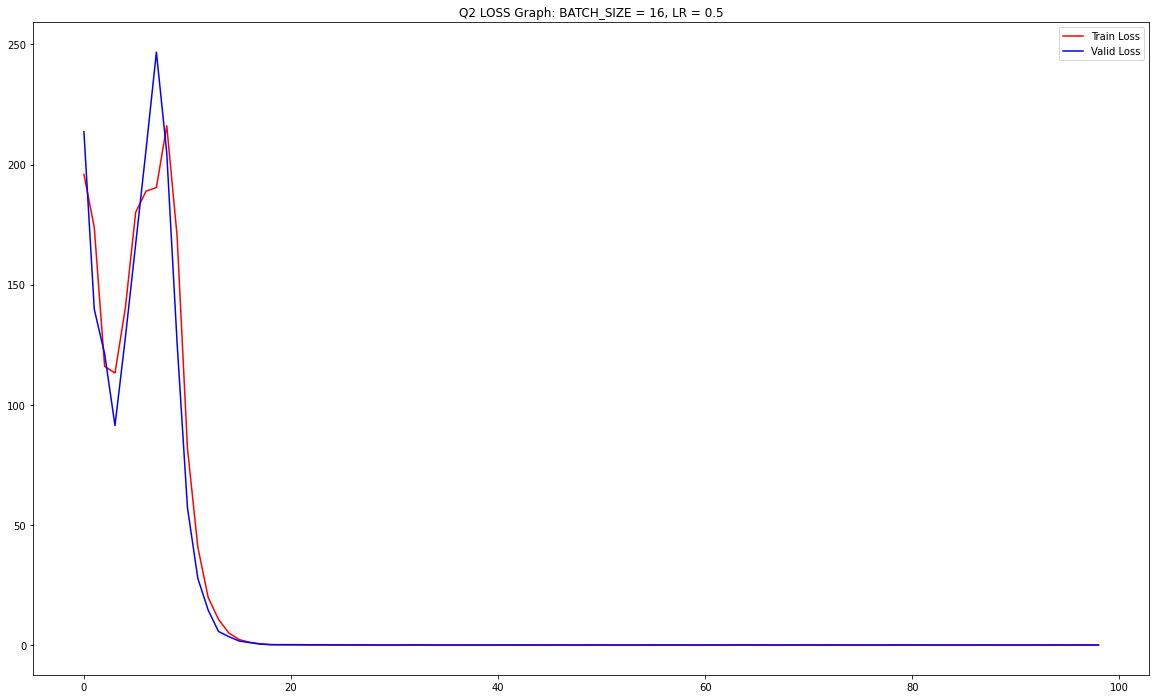

In [69]:
x = np.arange(len(train_loss[1:]))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss[1:], color='r', label='Train Loss')
plt.plot(x, valid_loss[1:], color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [70]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    num_outputs = params['num_outputs']
    truths, preds = [[], []], [[], []]
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        for k in range(num_outputs):
            truths[k].extend(y[:, k, :].view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            for k in range(num_outputs):
                preds[k].extend(y_hat[k, :, :].view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    for vals in [truths, preds]:
        vals[0] = vals[0] * (test_max_power_range[1] - test_max_power_range[0]) + test_max_power_range[0]
        vals[1] = vals[1] * (test_max_tick_range[1] - test_max_tick_range[0]) + test_max_tick_range[0]
    scores = pd.DataFrame(columns=['MAPE', 'MAE', 'MSE', 'R2 Score'])
    for k in range(num_outputs):
        scores.loc[k, 'MAPE'] = mape(truths[k], preds[k])
        scores.loc[k, 'MAE'] = MAE(truths[k], preds[k])
        scores.loc[k, 'MSE'] = MSE(truths[k], preds[k])
        scores.loc[k, 'R2 Score'] = r2_score(truths[k], preds[k])
    return truths, preds, scores

In [71]:
truths, preds, scores = test(params, test_loader, 'model_max.pth')

LSTM_multi(
  (lstm): LSTM(87, 512, num_layers=20, batch_first=True)
  (linear_pred): Linear(in_features=512, out_features=1, bias=True)
  (linear_time): Linear(in_features=512, out_features=1, bias=True)
)


100%|██████████| 15/15 [00:00<00:00, 38.08it/s]


In [72]:
scores

MAPE           MAE           MSE  R2 Score
0  17.934901  43963.746094  3022152704.0 -1.284154
1  60.227859      19.90028    606.044128 -2.995473

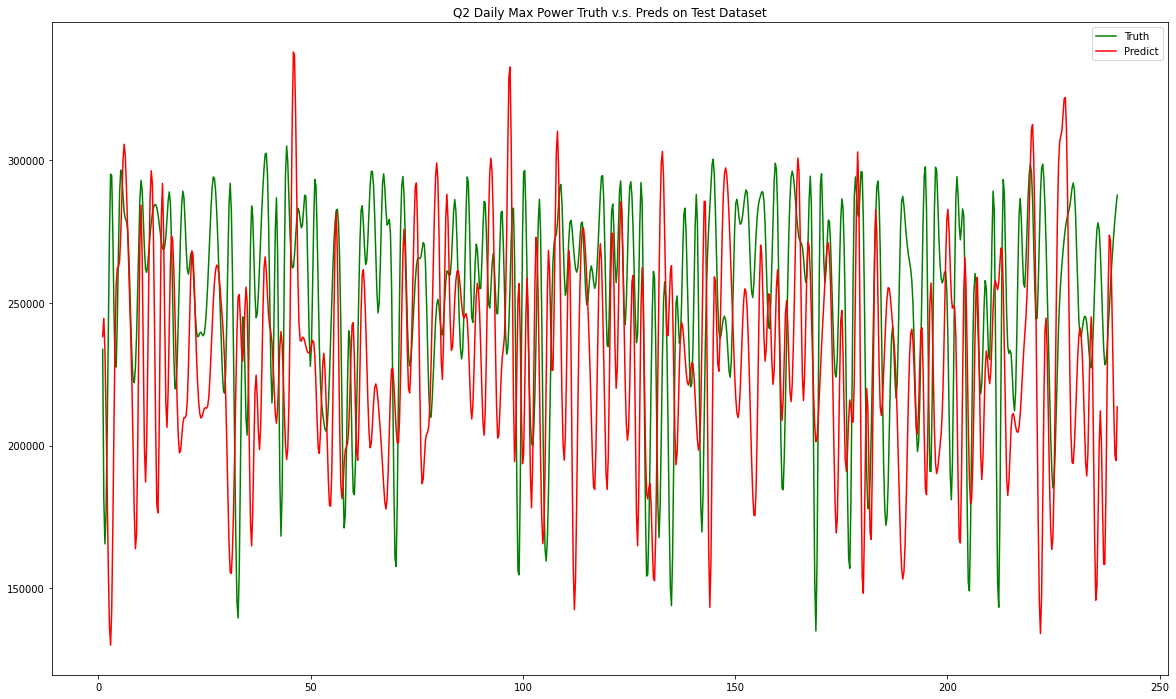

In [73]:
x = [i for i in range(1, len(truths[0]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[0])(x_smth)
preds_smth = make_interp_spline(x, preds[0])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Power Truth v.s. Preds on Test Dataset')
plt.show()

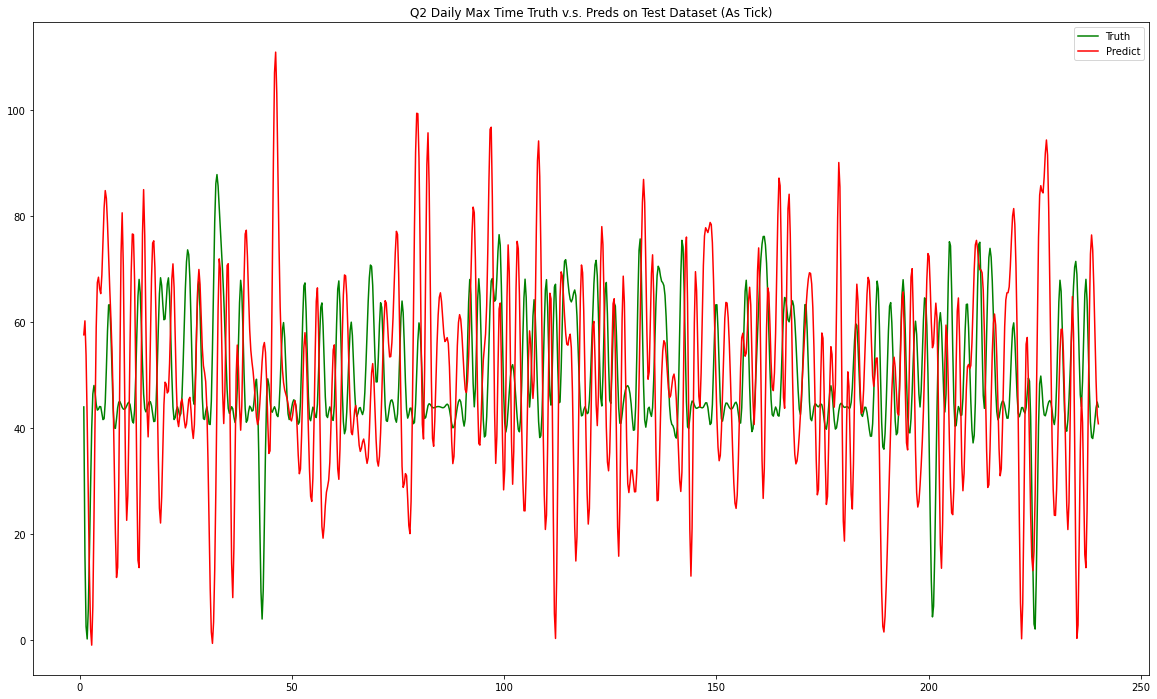

In [74]:
x = [i for i in range(1, len(truths[1]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[1])(x_smth)
preds_smth = make_interp_spline(x, preds[1])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Time Truth v.s. Preds on Test Dataset (As Tick)')
plt.show()

### 2.1.2 single-output LSTM and train twice Trail

#### 2.1.2.1 Train Model for Power

In [75]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size, :1].reshape(1, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [76]:
window_size, predict_size = 7, 1

X_train, y_train = preprocessing(train_max, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_max, window_size, predict_size)
X_test, y_test = preprocessing(test_max, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [77]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [78]:
def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
#             if step == 0:
#                 print(y_hat, y)
            l = loss(y_hat, y)
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 100 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
#                 print(y_hat)
            l = loss(y_hat, y)
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            print('New best performance... Save new model checkpoint.')
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss

In [79]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 128,
          'output_size': predict_size,
          'num_layers': 5, 
          'learning_rate': 0.5,
          'weight_decay': 1e-2,
          'step_size': 2,
          'gamma': 0.1,
          'epochs': 100}

In [80]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_max_1.pth')

LSTM(
  (lstm): LSTM(87, 128, num_layers=5, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0, train loss 0.341283


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<01:01,  1.61it/s]

New best performance... Save new model checkpoint.
Epoch [1/100], train loss 24.939729, valid loss 13.403693. Now best: 13.403693
Step 0, train loss 11.401331


  2%|▏         | 2/100 [00:01<01:00,  1.62it/s]

New best performance... Save new model checkpoint.
Epoch [2/100], train loss 4.781270, valid loss 1.254329. Now best: 1.254329
Step 0, train loss 0.755225


  3%|▎         | 3/100 [00:01<01:00,  1.61it/s]

New best performance... Save new model checkpoint.
Epoch [3/100], train loss 0.646666, valid loss 0.425609. Now best: 0.425609
Step 0, train loss 0.301328


  4%|▍         | 4/100 [00:02<00:59,  1.61it/s]

New best performance... Save new model checkpoint.
Epoch [4/100], train loss 0.292808, valid loss 0.295346. Now best: 0.295346
Step 0, train loss 0.210358


  5%|▌         | 5/100 [00:03<00:58,  1.61it/s]

New best performance... Save new model checkpoint.
Epoch [5/100], train loss 0.194241, valid loss 0.178886. Now best: 0.178886
Step 0, train loss 0.127213


  6%|▌         | 6/100 [00:03<00:57,  1.62it/s]

New best performance... Save new model checkpoint.
Epoch [6/100], train loss 0.182562, valid loss 0.157505. Now best: 0.157505
Step 0, train loss 0.211860


  7%|▋         | 7/100 [00:04<00:57,  1.63it/s]

Epoch [7/100], train loss 0.180264, valid loss 0.221864. Now best: 0.157505
Step 0, train loss 0.234522


  8%|▊         | 8/100 [00:04<00:56,  1.62it/s]

New best performance... Save new model checkpoint.
Epoch [8/100], train loss 0.184594, valid loss 0.153688. Now best: 0.153688
Step 0, train loss 0.130397


  9%|▉         | 9/100 [00:05<00:56,  1.62it/s]

Epoch [9/100], train loss 0.172788, valid loss 0.187656. Now best: 0.153688
Step 0, train loss 0.257156


 10%|█         | 10/100 [00:06<00:55,  1.63it/s]

Epoch [10/100], train loss 0.167494, valid loss 0.233969. Now best: 0.153688
Step 0, train loss 0.156784


 11%|█         | 11/100 [00:06<00:54,  1.63it/s]

Epoch [11/100], train loss 0.183320, valid loss 0.178111. Now best: 0.153688
Step 0, train loss 0.189024


 12%|█▏        | 12/100 [00:07<00:54,  1.60it/s]

Epoch [12/100], train loss 0.175258, valid loss 0.186918. Now best: 0.153688
Step 0, train loss 0.118111


 13%|█▎        | 13/100 [00:08<00:54,  1.60it/s]

Epoch [13/100], train loss 0.178211, valid loss 0.161232. Now best: 0.153688
Step 0, train loss 0.146424


 14%|█▍        | 14/100 [00:08<00:53,  1.62it/s]

Epoch [14/100], train loss 0.183780, valid loss 0.233030. Now best: 0.153688
Step 0, train loss 0.160139


 15%|█▌        | 15/100 [00:09<00:58,  1.44it/s]

Epoch [15/100], train loss 0.186376, valid loss 0.176766. Now best: 0.153688
Step 0, train loss 0.119001


 16%|█▌        | 16/100 [00:10<00:56,  1.49it/s]

Epoch [16/100], train loss 0.176836, valid loss 0.226449. Now best: 0.153688
Step 0, train loss 0.101364


 17%|█▋        | 17/100 [00:11<01:01,  1.34it/s]

Epoch [17/100], train loss 0.161908, valid loss 0.167547. Now best: 0.153688
Step 0, train loss 0.403153


 18%|█▊        | 18/100 [00:11<01:02,  1.31it/s]

Epoch [18/100], train loss 0.183818, valid loss 0.191833. Now best: 0.153688
Step 0, train loss 0.144227


 19%|█▉        | 19/100 [00:12<00:58,  1.39it/s]

Epoch [19/100], train loss 0.173620, valid loss 0.254965. Now best: 0.153688
Step 0, train loss 0.278289


 20%|██        | 20/100 [00:13<00:54,  1.46it/s]

Epoch [20/100], train loss 0.172830, valid loss 0.190988. Now best: 0.153688
Step 0, train loss 0.102267


 21%|██        | 21/100 [00:13<00:52,  1.51it/s]

Epoch [21/100], train loss 0.177651, valid loss 0.184643. Now best: 0.153688
Step 0, train loss 0.118396


 22%|██▏       | 22/100 [00:14<00:50,  1.54it/s]

Epoch [22/100], train loss 0.167042, valid loss 0.187179. Now best: 0.153688
Step 0, train loss 0.118047


 23%|██▎       | 23/100 [00:14<00:49,  1.57it/s]

Epoch [23/100], train loss 0.168837, valid loss 0.192997. Now best: 0.153688
Step 0, train loss 0.185619


 24%|██▍       | 24/100 [00:15<00:48,  1.58it/s]

Epoch [24/100], train loss 0.177972, valid loss 0.223281. Now best: 0.153688
Step 0, train loss 0.100590


 25%|██▌       | 25/100 [00:16<00:47,  1.59it/s]

Epoch [25/100], train loss 0.162027, valid loss 0.228880. Now best: 0.153688
Step 0, train loss 0.200066


 26%|██▌       | 26/100 [00:16<00:46,  1.59it/s]

Epoch [26/100], train loss 0.170654, valid loss 0.192452. Now best: 0.153688
Step 0, train loss 0.127111


 27%|██▋       | 27/100 [00:17<00:46,  1.57it/s]

Epoch [27/100], train loss 0.165504, valid loss 0.176216. Now best: 0.153688
Step 0, train loss 0.171634


 28%|██▊       | 28/100 [00:18<00:45,  1.57it/s]

Epoch [28/100], train loss 0.180102, valid loss 0.185194. Now best: 0.153688
Step 0, train loss 0.150824


 29%|██▉       | 29/100 [00:18<00:44,  1.59it/s]

Epoch [29/100], train loss 0.165210, valid loss 0.169665. Now best: 0.153688
Step 0, train loss 0.194269


 30%|███       | 30/100 [00:19<00:43,  1.60it/s]

Epoch [30/100], train loss 0.172182, valid loss 0.206364. Now best: 0.153688
Step 0, train loss 0.112284


 31%|███       | 31/100 [00:20<00:44,  1.54it/s]

New best performance... Save new model checkpoint.
Epoch [31/100], train loss 0.175141, valid loss 0.143074. Now best: 0.143074
Step 0, train loss 0.167337


 32%|███▏      | 32/100 [00:20<00:46,  1.45it/s]

Epoch [32/100], train loss 0.185497, valid loss 0.167078. Now best: 0.143074
Step 0, train loss 0.098163


 33%|███▎      | 33/100 [00:21<00:44,  1.51it/s]

Epoch [33/100], train loss 0.171347, valid loss 0.210810. Now best: 0.143074
Step 0, train loss 0.174396


 34%|███▍      | 34/100 [00:22<00:43,  1.53it/s]

New best performance... Save new model checkpoint.
Epoch [34/100], train loss 0.172814, valid loss 0.133156. Now best: 0.133156
Step 0, train loss 0.180957


 35%|███▌      | 35/100 [00:22<00:42,  1.53it/s]

Epoch [35/100], train loss 0.174996, valid loss 0.197246. Now best: 0.133156
Step 0, train loss 0.260876


 36%|███▌      | 36/100 [00:23<00:41,  1.55it/s]

Epoch [36/100], train loss 0.167611, valid loss 0.179310. Now best: 0.133156
Step 0, train loss 0.180814


 37%|███▋      | 37/100 [00:23<00:40,  1.57it/s]

Epoch [37/100], train loss 0.168366, valid loss 0.250623. Now best: 0.133156
Step 0, train loss 0.165452


 38%|███▊      | 38/100 [00:24<00:38,  1.60it/s]

Epoch [38/100], train loss 0.175689, valid loss 0.183984. Now best: 0.133156
Step 0, train loss 0.161296


 39%|███▉      | 39/100 [00:25<00:37,  1.61it/s]

Epoch [39/100], train loss 0.170806, valid loss 0.150418. Now best: 0.133156
Step 0, train loss 0.176838


 40%|████      | 40/100 [00:25<00:36,  1.62it/s]

Epoch [40/100], train loss 0.181980, valid loss 0.180647. Now best: 0.133156
Step 0, train loss 0.130428


 41%|████      | 41/100 [00:26<00:36,  1.62it/s]

Epoch [41/100], train loss 0.175519, valid loss 0.205830. Now best: 0.133156
Step 0, train loss 0.128886


 42%|████▏     | 42/100 [00:26<00:35,  1.62it/s]

Epoch [42/100], train loss 0.172458, valid loss 0.165075. Now best: 0.133156
Step 0, train loss 0.081146


 43%|████▎     | 43/100 [00:27<00:35,  1.62it/s]

Epoch [43/100], train loss 0.171675, valid loss 0.210441. Now best: 0.133156
Step 0, train loss 0.245151


 44%|████▍     | 44/100 [00:28<00:34,  1.62it/s]

Epoch [44/100], train loss 0.166400, valid loss 0.217816. Now best: 0.133156
Step 0, train loss 0.099861


 45%|████▌     | 45/100 [00:28<00:34,  1.62it/s]

Epoch [45/100], train loss 0.152437, valid loss 0.187976. Now best: 0.133156
Step 0, train loss 0.115640


 46%|████▌     | 46/100 [00:29<00:33,  1.61it/s]

Epoch [46/100], train loss 0.186241, valid loss 0.194286. Now best: 0.133156
Step 0, train loss 0.139911


 47%|████▋     | 47/100 [00:30<00:32,  1.61it/s]

Epoch [47/100], train loss 0.175428, valid loss 0.201147. Now best: 0.133156
Step 0, train loss 0.074134


 48%|████▊     | 48/100 [00:30<00:33,  1.56it/s]

Epoch [48/100], train loss 0.169744, valid loss 0.179865. Now best: 0.133156
Step 0, train loss 0.148450


 49%|████▉     | 49/100 [00:31<00:35,  1.43it/s]

Epoch [49/100], train loss 0.164049, valid loss 0.183142. Now best: 0.133156
Step 0, train loss 0.161520


 50%|█████     | 50/100 [00:32<00:33,  1.48it/s]

Epoch [50/100], train loss 0.189738, valid loss 0.143783. Now best: 0.133156
Step 0, train loss 0.186210


 51%|█████     | 51/100 [00:32<00:32,  1.51it/s]

Epoch [51/100], train loss 0.165647, valid loss 0.179626. Now best: 0.133156
Step 0, train loss 0.155403


 52%|█████▏    | 52/100 [00:33<00:31,  1.54it/s]

Epoch [52/100], train loss 0.155267, valid loss 0.179872. Now best: 0.133156
Step 0, train loss 0.182548


 53%|█████▎    | 53/100 [00:34<00:30,  1.55it/s]

Epoch [53/100], train loss 0.168177, valid loss 0.194569. Now best: 0.133156
Step 0, train loss 0.146226


 54%|█████▍    | 54/100 [00:34<00:29,  1.56it/s]

Epoch [54/100], train loss 0.174854, valid loss 0.232820. Now best: 0.133156
Step 0, train loss 0.169377


 55%|█████▌    | 55/100 [00:35<00:28,  1.57it/s]

Epoch [55/100], train loss 0.167383, valid loss 0.185405. Now best: 0.133156
Step 0, train loss 0.159863


 56%|█████▌    | 56/100 [00:36<00:28,  1.57it/s]

Epoch [56/100], train loss 0.155393, valid loss 0.202706. Now best: 0.133156
Step 0, train loss 0.141924


 57%|█████▋    | 57/100 [00:36<00:27,  1.56it/s]

Epoch [57/100], train loss 0.186427, valid loss 0.175283. Now best: 0.133156
Step 0, train loss 0.158015


 58%|█████▊    | 58/100 [00:37<00:27,  1.55it/s]

Epoch [58/100], train loss 0.163218, valid loss 0.173968. Now best: 0.133156
Step 0, train loss 0.110675


 59%|█████▉    | 59/100 [00:37<00:26,  1.55it/s]

Epoch [59/100], train loss 0.179757, valid loss 0.191547. Now best: 0.133156
Step 0, train loss 0.313606


 60%|██████    | 60/100 [00:38<00:25,  1.56it/s]

Epoch [60/100], train loss 0.177821, valid loss 0.197964. Now best: 0.133156
Step 0, train loss 0.157284


 61%|██████    | 61/100 [00:39<00:24,  1.58it/s]

Epoch [61/100], train loss 0.168799, valid loss 0.171210. Now best: 0.133156
Step 0, train loss 0.158820


 62%|██████▏   | 62/100 [00:39<00:23,  1.59it/s]

Epoch [62/100], train loss 0.176002, valid loss 0.219786. Now best: 0.133156
Step 0, train loss 0.194018


 63%|██████▎   | 63/100 [00:40<00:23,  1.59it/s]

Epoch [63/100], train loss 0.169583, valid loss 0.163435. Now best: 0.133156
Step 0, train loss 0.207022


 64%|██████▍   | 64/100 [00:41<00:22,  1.60it/s]

Epoch [64/100], train loss 0.174337, valid loss 0.167434. Now best: 0.133156
Step 0, train loss 0.075203


 65%|██████▌   | 65/100 [00:41<00:22,  1.59it/s]

Epoch [65/100], train loss 0.191315, valid loss 0.225722. Now best: 0.133156
Step 0, train loss 0.281073


 66%|██████▌   | 66/100 [00:42<00:26,  1.28it/s]

Epoch [66/100], train loss 0.171107, valid loss 0.202494. Now best: 0.133156
Step 0, train loss 0.320359


 67%|██████▋   | 67/100 [00:43<00:26,  1.24it/s]

Epoch [67/100], train loss 0.163077, valid loss 0.194912. Now best: 0.133156
Step 0, train loss 0.191781


 68%|██████▊   | 68/100 [00:44<00:24,  1.32it/s]

Epoch [68/100], train loss 0.156407, valid loss 0.221699. Now best: 0.133156
Step 0, train loss 0.070355


 69%|██████▉   | 69/100 [00:44<00:22,  1.40it/s]

Epoch [69/100], train loss 0.162568, valid loss 0.213369. Now best: 0.133156
Step 0, train loss 0.180472


 70%|███████   | 70/100 [00:45<00:20,  1.46it/s]

Epoch [70/100], train loss 0.174521, valid loss 0.191893. Now best: 0.133156
Step 0, train loss 0.092657


 71%|███████   | 71/100 [00:46<00:19,  1.49it/s]

Epoch [71/100], train loss 0.167499, valid loss 0.226968. Now best: 0.133156
Step 0, train loss 0.126052


 72%|███████▏  | 72/100 [00:46<00:18,  1.53it/s]

Epoch [72/100], train loss 0.173151, valid loss 0.148046. Now best: 0.133156
Step 0, train loss 0.150799


 73%|███████▎  | 73/100 [00:47<00:17,  1.53it/s]

Epoch [73/100], train loss 0.172512, valid loss 0.157063. Now best: 0.133156
Step 0, train loss 0.354548


 74%|███████▍  | 74/100 [00:48<00:16,  1.54it/s]

Epoch [74/100], train loss 0.181685, valid loss 0.169833. Now best: 0.133156
Step 0, train loss 0.078424


 75%|███████▌  | 75/100 [00:48<00:16,  1.56it/s]

Epoch [75/100], train loss 0.174889, valid loss 0.148915. Now best: 0.133156
Step 0, train loss 0.176798


 76%|███████▌  | 76/100 [00:49<00:15,  1.56it/s]

Epoch [76/100], train loss 0.169990, valid loss 0.151284. Now best: 0.133156
Step 0, train loss 0.206537


 77%|███████▋  | 77/100 [00:50<00:14,  1.58it/s]

Epoch [77/100], train loss 0.161388, valid loss 0.180008. Now best: 0.133156
Step 0, train loss 0.119482


 78%|███████▊  | 78/100 [00:50<00:13,  1.59it/s]

Epoch [78/100], train loss 0.168673, valid loss 0.221036. Now best: 0.133156
Step 0, train loss 0.140054


 79%|███████▉  | 79/100 [00:51<00:13,  1.60it/s]

Epoch [79/100], train loss 0.173056, valid loss 0.183554. Now best: 0.133156
Step 0, train loss 0.189277


 80%|████████  | 80/100 [00:51<00:12,  1.60it/s]

Epoch [80/100], train loss 0.187414, valid loss 0.203331. Now best: 0.133156
Step 0, train loss 0.139710


 81%|████████  | 81/100 [00:52<00:11,  1.60it/s]

Epoch [81/100], train loss 0.177845, valid loss 0.228141. Now best: 0.133156
Step 0, train loss 0.164206


 82%|████████▏ | 82/100 [00:53<00:12,  1.44it/s]

Epoch [82/100], train loss 0.175819, valid loss 0.181656. Now best: 0.133156
Step 0, train loss 0.087533


 83%|████████▎ | 83/100 [00:54<00:11,  1.42it/s]

Epoch [83/100], train loss 0.175804, valid loss 0.186257. Now best: 0.133156
Step 0, train loss 0.107796


 84%|████████▍ | 84/100 [00:54<00:10,  1.47it/s]

Epoch [84/100], train loss 0.169707, valid loss 0.196566. Now best: 0.133156
Step 0, train loss 0.115754


 85%|████████▌ | 85/100 [00:55<00:10,  1.50it/s]

Epoch [85/100], train loss 0.180769, valid loss 0.229529. Now best: 0.133156
Step 0, train loss 0.218466


 86%|████████▌ | 86/100 [00:55<00:09,  1.54it/s]

Epoch [86/100], train loss 0.163595, valid loss 0.135427. Now best: 0.133156
Step 0, train loss 0.234794


 87%|████████▋ | 87/100 [00:56<00:08,  1.55it/s]

Epoch [87/100], train loss 0.171604, valid loss 0.191759. Now best: 0.133156
Step 0, train loss 0.186127


 88%|████████▊ | 88/100 [00:57<00:07,  1.57it/s]

Epoch [88/100], train loss 0.167347, valid loss 0.202744. Now best: 0.133156
Step 0, train loss 0.165235


 89%|████████▉ | 89/100 [00:57<00:06,  1.58it/s]

Epoch [89/100], train loss 0.171148, valid loss 0.143355. Now best: 0.133156
Step 0, train loss 0.232631


 90%|█████████ | 90/100 [00:58<00:06,  1.58it/s]

Epoch [90/100], train loss 0.150022, valid loss 0.174495. Now best: 0.133156
Step 0, train loss 0.158149


 91%|█████████ | 91/100 [00:59<00:05,  1.58it/s]

Epoch [91/100], train loss 0.166093, valid loss 0.184454. Now best: 0.133156
Step 0, train loss 0.092268


 92%|█████████▏| 92/100 [00:59<00:05,  1.59it/s]

Epoch [92/100], train loss 0.158721, valid loss 0.195235. Now best: 0.133156
Step 0, train loss 0.111122


 93%|█████████▎| 93/100 [01:00<00:04,  1.59it/s]

Epoch [93/100], train loss 0.156315, valid loss 0.209580. Now best: 0.133156
Step 0, train loss 0.185266


 94%|█████████▍| 94/100 [01:01<00:03,  1.53it/s]

Epoch [94/100], train loss 0.172172, valid loss 0.181954. Now best: 0.133156
Step 0, train loss 0.204468


 95%|█████████▌| 95/100 [01:01<00:03,  1.55it/s]

Epoch [95/100], train loss 0.178045, valid loss 0.197890. Now best: 0.133156
Step 0, train loss 0.206868


 96%|█████████▌| 96/100 [01:02<00:02,  1.56it/s]

Epoch [96/100], train loss 0.169438, valid loss 0.254555. Now best: 0.133156
Step 0, train loss 0.196919


 97%|█████████▋| 97/100 [01:02<00:01,  1.57it/s]

Epoch [97/100], train loss 0.182598, valid loss 0.169308. Now best: 0.133156
Step 0, train loss 0.174413


 98%|█████████▊| 98/100 [01:03<00:01,  1.59it/s]

Epoch [98/100], train loss 0.169323, valid loss 0.204177. Now best: 0.133156
Step 0, train loss 0.098902


 99%|█████████▉| 99/100 [01:04<00:00,  1.49it/s]

Epoch [99/100], train loss 0.164265, valid loss 0.203282. Now best: 0.133156
Step 0, train loss 0.112853


100%|██████████| 100/100 [01:05<00:00,  1.54it/s]

Epoch [100/100], train loss 0.173681, valid loss 0.200383. Now best: 0.133156


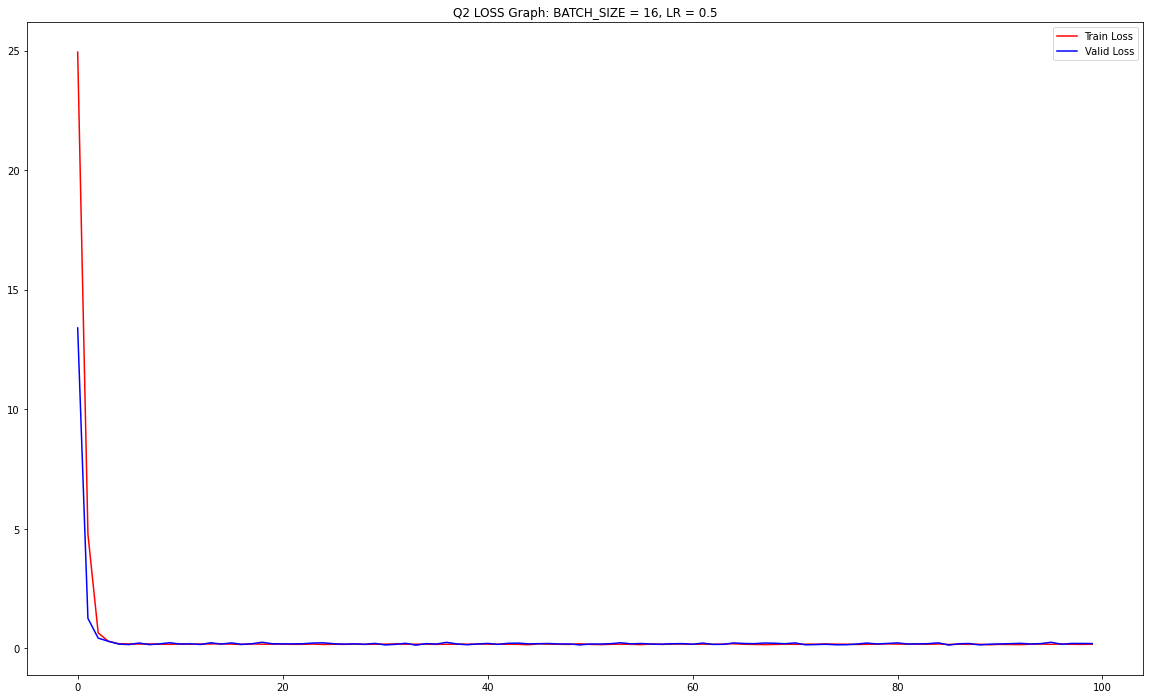

In [81]:
x = np.arange(len(train_loss))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss, color='r', label='Train Loss')
plt.plot(x, valid_loss, color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [82]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    truths, preds = [], []
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        truths.extend(y.view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            preds.extend(y_hat.view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    truths = truths * (test_max_power_range[1] - test_max_power_range[0]) + test_max_power_range[0]
    preds = preds * (test_max_power_range[1] - test_max_power_range[0]) + test_max_power_range[0]
    print('MAPE:', mape(truths, preds))
    print('MAE:', MAE(truths, preds))
    print('MSE:', MSE(truths, preds))
    print('R2 Score:', r2_score(truths, preds))
    
    return truths, preds

In [83]:
truths, preds = test(params, test_loader, 'model_max_1.pth')

LSTM(
  (lstm): LSTM(87, 128, num_layers=5, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


100%|██████████| 16/16 [00:00<00:00, 104.27it/s]

MAPE: 24.643532931804657
MAE: 59966.24
MSE: 5366543400.0
R2 Score: -2.938622407732738


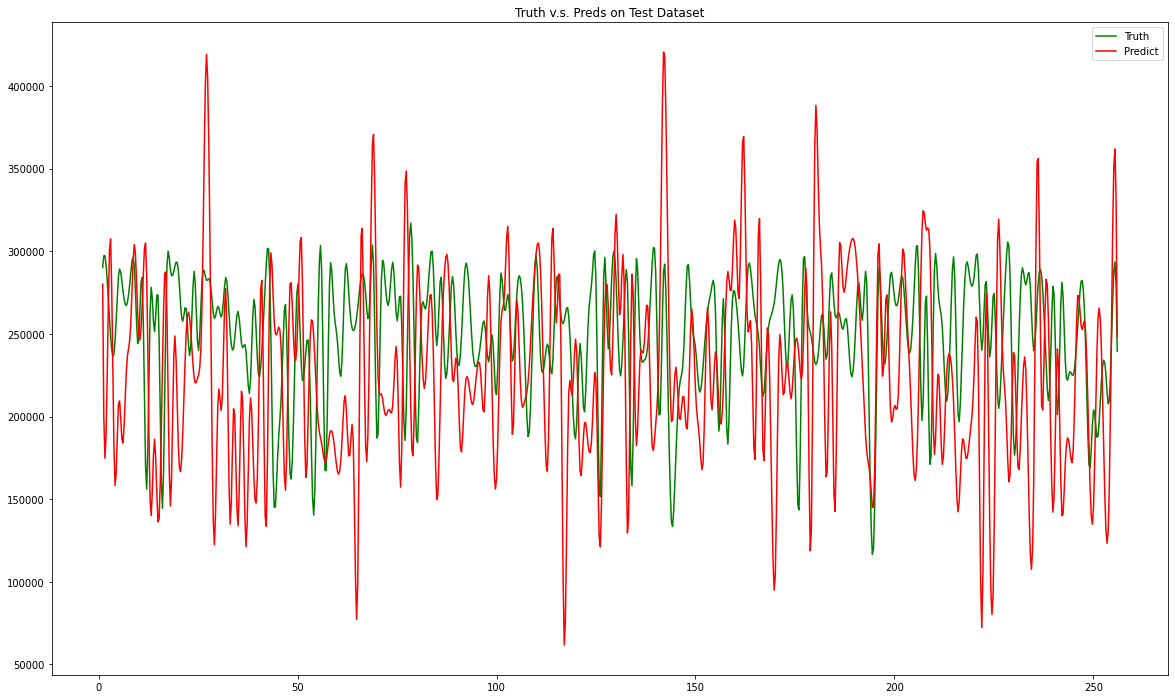

In [84]:
x = [i for i in range(1, len(truths) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths)(x_smth)
preds_smth = make_interp_spline(x, preds)(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Truth v.s. Preds on Test Dataset')
plt.show()

#### 2.1.2.2 Train Model for Tick

In [85]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size, 1:2].reshape(1, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [86]:
window_size, predict_size = 7, 1

X_train, y_train = preprocessing(train_max, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_max, window_size, predict_size)
X_test, y_test = preprocessing(test_max, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [87]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [88]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 32,
          'output_size': predict_size,
          'num_layers': 5, 
          'learning_rate': 0.5,
          'weight_decay': 1e-3,
          'step_size': 2,
          'gamma': 0.1,
          'epochs': 100}

In [89]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_max_2.pth')

LSTM(
  (lstm): LSTM(87, 32, num_layers=5, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0, train loss 0.359135


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:00<00:59,  1.67it/s]

New best performance... Save new model checkpoint.
Epoch [1/100], train loss 2.219980, valid loss 0.334543. Now best: 0.334543
Step 0, train loss 0.115472


  2%|▏         | 2/100 [00:01<00:58,  1.67it/s]

New best performance... Save new model checkpoint.
Epoch [2/100], train loss 0.129750, valid loss 0.278484. Now best: 0.278484
Step 0, train loss 0.059150


  3%|▎         | 3/100 [00:01<00:58,  1.67it/s]

New best performance... Save new model checkpoint.
Epoch [3/100], train loss 0.025936, valid loss 0.140753. Now best: 0.140753
Step 0, train loss 0.031297


  4%|▍         | 4/100 [00:02<00:59,  1.63it/s]

New best performance... Save new model checkpoint.
Epoch [4/100], train loss 0.025832, valid loss 0.136609. Now best: 0.136609
Step 0, train loss 0.025235


  5%|▌         | 5/100 [00:03<00:58,  1.63it/s]

Epoch [5/100], train loss 0.024564, valid loss 0.162977. Now best: 0.136609
Step 0, train loss 0.014828


  6%|▌         | 6/100 [00:03<00:57,  1.63it/s]

Epoch [6/100], train loss 0.024417, valid loss 0.155383. Now best: 0.136609
Step 0, train loss 0.029038


  7%|▋         | 7/100 [00:04<00:56,  1.64it/s]

Epoch [7/100], train loss 0.023829, valid loss 0.153316. Now best: 0.136609
Step 0, train loss 0.022182


  8%|▊         | 8/100 [00:04<00:55,  1.65it/s]

Epoch [8/100], train loss 0.023895, valid loss 0.156827. Now best: 0.136609
Step 0, train loss 0.019473


  9%|▉         | 9/100 [00:05<00:55,  1.65it/s]

Epoch [9/100], train loss 0.023759, valid loss 0.156229. Now best: 0.136609
Step 0, train loss 0.030099


 10%|█         | 10/100 [00:06<01:03,  1.42it/s]

Epoch [10/100], train loss 0.023739, valid loss 0.156081. Now best: 0.136609
Step 0, train loss 0.026288


 11%|█         | 11/100 [00:07<01:11,  1.25it/s]

Epoch [11/100], train loss 0.023744, valid loss 0.158469. Now best: 0.136609
Step 0, train loss 0.047717


 12%|█▏        | 12/100 [00:08<01:05,  1.35it/s]

Epoch [12/100], train loss 0.023797, valid loss 0.156657. Now best: 0.136609
Step 0, train loss 0.015448


 13%|█▎        | 13/100 [00:08<01:00,  1.43it/s]

Epoch [13/100], train loss 0.023760, valid loss 0.155338. Now best: 0.136609
Step 0, train loss 0.031851


 14%|█▍        | 14/100 [00:09<00:57,  1.49it/s]

Epoch [14/100], train loss 0.023758, valid loss 0.155540. Now best: 0.136609
Step 0, train loss 0.031681


 15%|█▌        | 15/100 [00:09<00:55,  1.54it/s]

Epoch [15/100], train loss 0.023748, valid loss 0.155030. Now best: 0.136609
Step 0, train loss 0.048481


 16%|█▌        | 16/100 [00:10<00:53,  1.58it/s]

Epoch [16/100], train loss 0.023733, valid loss 0.155584. Now best: 0.136609
Step 0, train loss 0.010298


 17%|█▋        | 17/100 [00:11<00:51,  1.60it/s]

Epoch [17/100], train loss 0.023768, valid loss 0.155986. Now best: 0.136609
Step 0, train loss 0.013078


 18%|█▊        | 18/100 [00:11<00:50,  1.62it/s]

Epoch [18/100], train loss 0.023768, valid loss 0.154361. Now best: 0.136609
Step 0, train loss 0.013898


 19%|█▉        | 19/100 [00:12<00:49,  1.63it/s]

Epoch [19/100], train loss 0.023778, valid loss 0.155076. Now best: 0.136609
Step 0, train loss 0.020192


 20%|██        | 20/100 [00:12<00:48,  1.64it/s]

Epoch [20/100], train loss 0.023697, valid loss 0.154969. Now best: 0.136609
Step 0, train loss 0.051701


 21%|██        | 21/100 [00:13<00:48,  1.65it/s]

Epoch [21/100], train loss 0.023761, valid loss 0.153734. Now best: 0.136609
Step 0, train loss 0.027058


 22%|██▏       | 22/100 [00:14<00:47,  1.64it/s]

Epoch [22/100], train loss 0.023727, valid loss 0.155765. Now best: 0.136609
Step 0, train loss 0.026804


 23%|██▎       | 23/100 [00:14<00:47,  1.62it/s]

Epoch [23/100], train loss 0.023798, valid loss 0.154310. Now best: 0.136609
Step 0, train loss 0.023278


 24%|██▍       | 24/100 [00:15<00:47,  1.62it/s]

Epoch [24/100], train loss 0.023722, valid loss 0.157067. Now best: 0.136609
Step 0, train loss 0.020399


 25%|██▌       | 25/100 [00:15<00:46,  1.63it/s]

Epoch [25/100], train loss 0.023770, valid loss 0.156400. Now best: 0.136609
Step 0, train loss 0.011780


 26%|██▌       | 26/100 [00:16<00:45,  1.64it/s]

Epoch [26/100], train loss 0.023795, valid loss 0.157484. Now best: 0.136609
Step 0, train loss 0.034051


 27%|██▋       | 27/100 [00:17<00:44,  1.65it/s]

Epoch [27/100], train loss 0.023759, valid loss 0.155206. Now best: 0.136609
Step 0, train loss 0.040803


 28%|██▊       | 28/100 [00:17<00:48,  1.48it/s]

Epoch [28/100], train loss 0.023763, valid loss 0.157793. Now best: 0.136609
Step 0, train loss 0.025848


 29%|██▉       | 29/100 [00:18<00:47,  1.49it/s]

Epoch [29/100], train loss 0.023793, valid loss 0.154755. Now best: 0.136609
Step 0, train loss 0.014202


 30%|███       | 30/100 [00:19<00:45,  1.54it/s]

Epoch [30/100], train loss 0.023713, valid loss 0.155899. Now best: 0.136609
Step 0, train loss 0.029874


 31%|███       | 31/100 [00:19<00:43,  1.57it/s]

Epoch [31/100], train loss 0.023727, valid loss 0.155461. Now best: 0.136609
Step 0, train loss 0.032150


 32%|███▏      | 32/100 [00:20<00:42,  1.60it/s]

Epoch [32/100], train loss 0.023787, valid loss 0.156300. Now best: 0.136609
Step 0, train loss 0.013290


 33%|███▎      | 33/100 [00:21<00:41,  1.62it/s]

Epoch [33/100], train loss 0.023684, valid loss 0.157120. Now best: 0.136609
Step 0, train loss 0.019384


 34%|███▍      | 34/100 [00:21<00:40,  1.63it/s]

Epoch [34/100], train loss 0.023728, valid loss 0.157001. Now best: 0.136609
Step 0, train loss 0.032337


 35%|███▌      | 35/100 [00:22<00:39,  1.64it/s]

Epoch [35/100], train loss 0.023818, valid loss 0.154818. Now best: 0.136609
Step 0, train loss 0.019178


 36%|███▌      | 36/100 [00:22<00:38,  1.65it/s]

Epoch [36/100], train loss 0.023801, valid loss 0.157613. Now best: 0.136609
Step 0, train loss 0.011261


 37%|███▋      | 37/100 [00:23<00:38,  1.65it/s]

Epoch [37/100], train loss 0.023794, valid loss 0.155999. Now best: 0.136609
Step 0, train loss 0.026449


 38%|███▊      | 38/100 [00:24<00:37,  1.66it/s]

Epoch [38/100], train loss 0.023761, valid loss 0.158898. Now best: 0.136609
Step 0, train loss 0.023464


 39%|███▉      | 39/100 [00:24<00:36,  1.66it/s]

Epoch [39/100], train loss 0.023782, valid loss 0.154884. Now best: 0.136609
Step 0, train loss 0.017253


 40%|████      | 40/100 [00:25<00:36,  1.64it/s]

Epoch [40/100], train loss 0.023788, valid loss 0.154382. Now best: 0.136609
Step 0, train loss 0.030501


 41%|████      | 41/100 [00:25<00:35,  1.65it/s]

Epoch [41/100], train loss 0.023811, valid loss 0.155522. Now best: 0.136609
Step 0, train loss 0.011588


 42%|████▏     | 42/100 [00:26<00:35,  1.65it/s]

Epoch [42/100], train loss 0.023737, valid loss 0.153532. Now best: 0.136609
Step 0, train loss 0.035556


 43%|████▎     | 43/100 [00:27<00:34,  1.66it/s]

Epoch [43/100], train loss 0.023815, valid loss 0.154786. Now best: 0.136609
Step 0, train loss 0.013049


 44%|████▍     | 44/100 [00:27<00:33,  1.66it/s]

Epoch [44/100], train loss 0.023764, valid loss 0.156824. Now best: 0.136609
Step 0, train loss 0.026475


 45%|████▌     | 45/100 [00:28<00:33,  1.66it/s]

Epoch [45/100], train loss 0.023790, valid loss 0.155284. Now best: 0.136609
Step 0, train loss 0.012696


 46%|████▌     | 46/100 [00:29<00:36,  1.49it/s]

Epoch [46/100], train loss 0.023627, valid loss 0.153130. Now best: 0.136609
Step 0, train loss 0.016610


 47%|████▋     | 47/100 [00:29<00:34,  1.55it/s]

Epoch [47/100], train loss 0.023762, valid loss 0.155399. Now best: 0.136609
Step 0, train loss 0.018750


 48%|████▊     | 48/100 [00:30<00:32,  1.58it/s]

Epoch [48/100], train loss 0.023761, valid loss 0.152587. Now best: 0.136609
Step 0, train loss 0.032739


 49%|████▉     | 49/100 [00:30<00:33,  1.54it/s]

Epoch [49/100], train loss 0.023799, valid loss 0.156561. Now best: 0.136609
Step 0, train loss 0.039107


 50%|█████     | 50/100 [00:31<00:31,  1.58it/s]

Epoch [50/100], train loss 0.023762, valid loss 0.156963. Now best: 0.136609
Step 0, train loss 0.013135


 51%|█████     | 51/100 [00:32<00:30,  1.60it/s]

Epoch [51/100], train loss 0.023767, valid loss 0.153718. Now best: 0.136609
Step 0, train loss 0.017962


 52%|█████▏    | 52/100 [00:32<00:29,  1.63it/s]

Epoch [52/100], train loss 0.023757, valid loss 0.155345. Now best: 0.136609
Step 0, train loss 0.032592


 53%|█████▎    | 53/100 [00:33<00:28,  1.64it/s]

Epoch [53/100], train loss 0.023749, valid loss 0.154064. Now best: 0.136609
Step 0, train loss 0.033076


 54%|█████▍    | 54/100 [00:33<00:27,  1.65it/s]

Epoch [54/100], train loss 0.023804, valid loss 0.153119. Now best: 0.136609
Step 0, train loss 0.010197


 55%|█████▌    | 55/100 [00:34<00:27,  1.65it/s]

Epoch [55/100], train loss 0.023767, valid loss 0.153374. Now best: 0.136609
Step 0, train loss 0.021782


 56%|█████▌    | 56/100 [00:35<00:26,  1.66it/s]

Epoch [56/100], train loss 0.023837, valid loss 0.157177. Now best: 0.136609
Step 0, train loss 0.020639


 57%|█████▋    | 57/100 [00:35<00:25,  1.66it/s]

Epoch [57/100], train loss 0.023759, valid loss 0.154174. Now best: 0.136609
Step 0, train loss 0.023848


 58%|█████▊    | 58/100 [00:36<00:25,  1.65it/s]

Epoch [58/100], train loss 0.023763, valid loss 0.156467. Now best: 0.136609
Step 0, train loss 0.030906


 59%|█████▉    | 59/100 [00:36<00:24,  1.66it/s]

Epoch [59/100], train loss 0.023792, valid loss 0.157004. Now best: 0.136609
Step 0, train loss 0.014478


 60%|██████    | 60/100 [00:37<00:25,  1.59it/s]

Epoch [60/100], train loss 0.023708, valid loss 0.155044. Now best: 0.136609
Step 0, train loss 0.030545


 61%|██████    | 61/100 [00:38<00:28,  1.38it/s]

Epoch [61/100], train loss 0.023757, valid loss 0.156032. Now best: 0.136609
Step 0, train loss 0.017424


 62%|██████▏   | 62/100 [00:39<00:26,  1.43it/s]

Epoch [62/100], train loss 0.023748, valid loss 0.156862. Now best: 0.136609
Step 0, train loss 0.011888


 63%|██████▎   | 63/100 [00:40<00:27,  1.35it/s]

Epoch [63/100], train loss 0.023483, valid loss 0.154903. Now best: 0.136609
Step 0, train loss 0.023871


 64%|██████▍   | 64/100 [00:40<00:25,  1.42it/s]

Epoch [64/100], train loss 0.023748, valid loss 0.156813. Now best: 0.136609
Step 0, train loss 0.027990


 65%|██████▌   | 65/100 [00:41<00:23,  1.48it/s]

Epoch [65/100], train loss 0.023719, valid loss 0.156407. Now best: 0.136609
Step 0, train loss 0.018413


 66%|██████▌   | 66/100 [00:41<00:22,  1.52it/s]

Epoch [66/100], train loss 0.023742, valid loss 0.154952. Now best: 0.136609
Step 0, train loss 0.028886


 67%|██████▋   | 67/100 [00:42<00:21,  1.54it/s]

Epoch [67/100], train loss 0.023795, valid loss 0.154300. Now best: 0.136609
Step 0, train loss 0.019159


 68%|██████▊   | 68/100 [00:43<00:20,  1.56it/s]

Epoch [68/100], train loss 0.023773, valid loss 0.155266. Now best: 0.136609
Step 0, train loss 0.022913


 69%|██████▉   | 69/100 [00:43<00:19,  1.58it/s]

Epoch [69/100], train loss 0.023754, valid loss 0.157715. Now best: 0.136609
Step 0, train loss 0.020862


 70%|███████   | 70/100 [00:44<00:18,  1.60it/s]

Epoch [70/100], train loss 0.023769, valid loss 0.156494. Now best: 0.136609
Step 0, train loss 0.021609


 71%|███████   | 71/100 [00:45<00:18,  1.60it/s]

Epoch [71/100], train loss 0.023762, valid loss 0.157963. Now best: 0.136609
Step 0, train loss 0.023943


 72%|███████▏  | 72/100 [00:45<00:17,  1.59it/s]

Epoch [72/100], train loss 0.023739, valid loss 0.155486. Now best: 0.136609
Step 0, train loss 0.015315


 73%|███████▎  | 73/100 [00:46<00:16,  1.60it/s]

Epoch [73/100], train loss 0.023716, valid loss 0.154331. Now best: 0.136609
Step 0, train loss 0.019617


 74%|███████▍  | 74/100 [00:46<00:16,  1.61it/s]

Epoch [74/100], train loss 0.023765, valid loss 0.158306. Now best: 0.136609
Step 0, train loss 0.028507


 75%|███████▌  | 75/100 [00:47<00:15,  1.61it/s]

Epoch [75/100], train loss 0.023746, valid loss 0.156523. Now best: 0.136609
Step 0, train loss 0.029588


 76%|███████▌  | 76/100 [00:48<00:14,  1.62it/s]

Epoch [76/100], train loss 0.023628, valid loss 0.156974. Now best: 0.136609
Step 0, train loss 0.027078


 77%|███████▋  | 77/100 [00:48<00:14,  1.62it/s]

Epoch [77/100], train loss 0.023836, valid loss 0.155751. Now best: 0.136609
Step 0, train loss 0.023068


 78%|███████▊  | 78/100 [00:49<00:13,  1.62it/s]

Epoch [78/100], train loss 0.023756, valid loss 0.153508. Now best: 0.136609
Step 0, train loss 0.044842


 79%|███████▉  | 79/100 [00:50<00:13,  1.59it/s]

Epoch [79/100], train loss 0.023764, valid loss 0.155276. Now best: 0.136609
Step 0, train loss 0.012516


 80%|████████  | 80/100 [00:50<00:13,  1.48it/s]

Epoch [80/100], train loss 0.023783, valid loss 0.157600. Now best: 0.136609
Step 0, train loss 0.022399


 81%|████████  | 81/100 [00:51<00:12,  1.47it/s]

Epoch [81/100], train loss 0.023686, valid loss 0.155683. Now best: 0.136609
Step 0, train loss 0.018022


 82%|████████▏ | 82/100 [00:52<00:11,  1.52it/s]

Epoch [82/100], train loss 0.023772, valid loss 0.156725. Now best: 0.136609
Step 0, train loss 0.029363


 83%|████████▎ | 83/100 [00:52<00:10,  1.56it/s]

Epoch [83/100], train loss 0.023756, valid loss 0.154760. Now best: 0.136609
Step 0, train loss 0.028687


 84%|████████▍ | 84/100 [00:53<00:10,  1.59it/s]

Epoch [84/100], train loss 0.023745, valid loss 0.154175. Now best: 0.136609
Step 0, train loss 0.018560


 85%|████████▌ | 85/100 [00:53<00:09,  1.61it/s]

Epoch [85/100], train loss 0.023754, valid loss 0.153355. Now best: 0.136609
Step 0, train loss 0.017275


 86%|████████▌ | 86/100 [00:54<00:08,  1.63it/s]

Epoch [86/100], train loss 0.023813, valid loss 0.155740. Now best: 0.136609
Step 0, train loss 0.015972


 87%|████████▋ | 87/100 [00:55<00:08,  1.62it/s]

Epoch [87/100], train loss 0.023769, valid loss 0.155558. Now best: 0.136609
Step 0, train loss 0.018017


 88%|████████▊ | 88/100 [00:55<00:07,  1.64it/s]

Epoch [88/100], train loss 0.023761, valid loss 0.157321. Now best: 0.136609
Step 0, train loss 0.023516


 89%|████████▉ | 89/100 [00:56<00:06,  1.65it/s]

Epoch [89/100], train loss 0.023739, valid loss 0.155169. Now best: 0.136609
Step 0, train loss 0.019301


 90%|█████████ | 90/100 [00:56<00:06,  1.65it/s]

Epoch [90/100], train loss 0.023752, valid loss 0.158333. Now best: 0.136609
Step 0, train loss 0.026875


 91%|█████████ | 91/100 [00:57<00:05,  1.66it/s]

Epoch [91/100], train loss 0.023812, valid loss 0.155528. Now best: 0.136609
Step 0, train loss 0.019795


 92%|█████████▏| 92/100 [00:58<00:04,  1.66it/s]

Epoch [92/100], train loss 0.023771, valid loss 0.155397. Now best: 0.136609
Step 0, train loss 0.021571


 93%|█████████▎| 93/100 [00:58<00:04,  1.64it/s]

Epoch [93/100], train loss 0.023678, valid loss 0.154547. Now best: 0.136609
Step 0, train loss 0.021096


 94%|█████████▍| 94/100 [00:59<00:03,  1.65it/s]

Epoch [94/100], train loss 0.023737, valid loss 0.155503. Now best: 0.136609
Step 0, train loss 0.023592


 95%|█████████▌| 95/100 [00:59<00:03,  1.64it/s]

Epoch [95/100], train loss 0.023785, valid loss 0.155749. Now best: 0.136609
Step 0, train loss 0.029046


 96%|█████████▌| 96/100 [01:00<00:02,  1.64it/s]

Epoch [96/100], train loss 0.023758, valid loss 0.156355. Now best: 0.136609
Step 0, train loss 0.020773


 97%|█████████▋| 97/100 [01:01<00:01,  1.58it/s]

Epoch [97/100], train loss 0.023765, valid loss 0.154847. Now best: 0.136609
Step 0, train loss 0.018743


 98%|█████████▊| 98/100 [01:02<00:01,  1.45it/s]

Epoch [98/100], train loss 0.023773, valid loss 0.155138. Now best: 0.136609
Step 0, train loss 0.027068


 99%|█████████▉| 99/100 [01:02<00:00,  1.49it/s]

Epoch [99/100], train loss 0.023759, valid loss 0.154346. Now best: 0.136609
Step 0, train loss 0.030972


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]

Epoch [100/100], train loss 0.023785, valid loss 0.154064. Now best: 0.136609


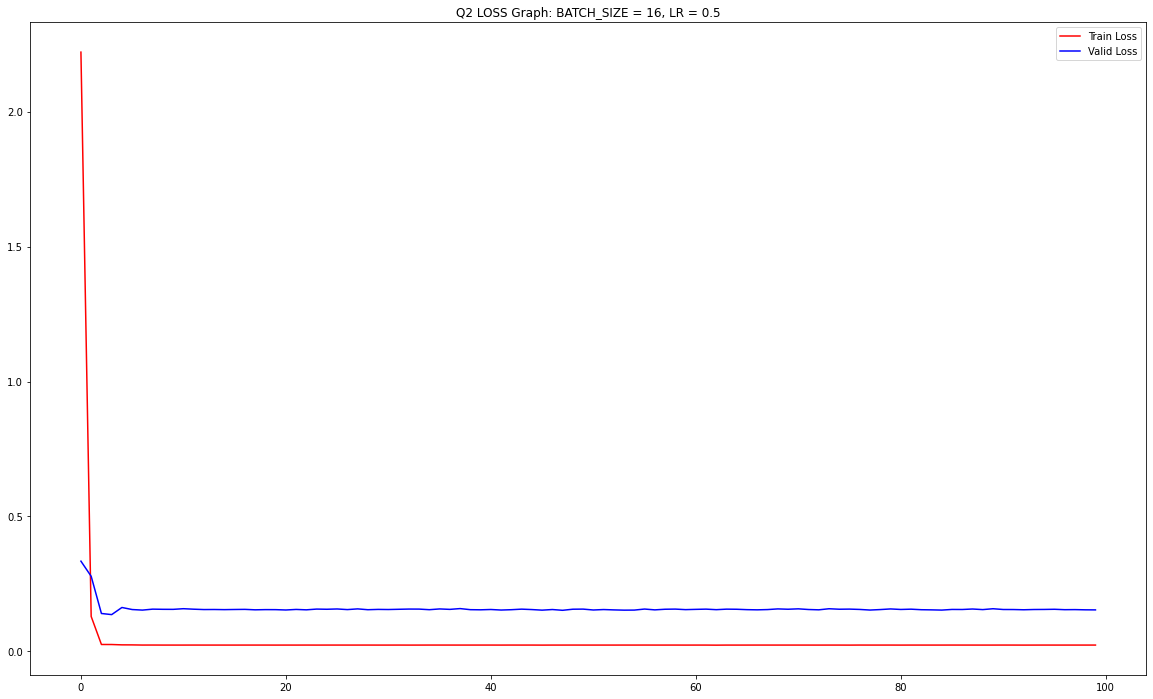

In [90]:
x = np.arange(len(train_loss))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss, color='r', label='Train Loss')
plt.plot(x, valid_loss, color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [91]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    truths, preds = [], []
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        truths.extend(y.view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            preds.extend(y_hat.view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    truths = truths * (test_max_tick_range[1] - test_max_tick_range[0]) + test_max_tick_range[0]
    preds = preds * (test_max_tick_range[1] - test_max_tick_range[0]) + test_max_tick_range[0]
    print('MAPE:', mape(truths, preds))
    print('MAE:', MAE(truths, preds))
    print('MSE:', MSE(truths, preds))
    print('R2 Score:', r2_score(truths, preds))
    
    return truths, preds

In [92]:
truths, preds = test(params, test_loader, 'model_max_2.pth')

LSTM(
  (lstm): LSTM(87, 32, num_layers=5, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


100%|██████████| 16/16 [00:00<00:00, 109.97it/s]

MAPE: 44.9001669883728
MAE: 11.793661
MSE: 269.21896
R2 Score: -0.7501703187254463


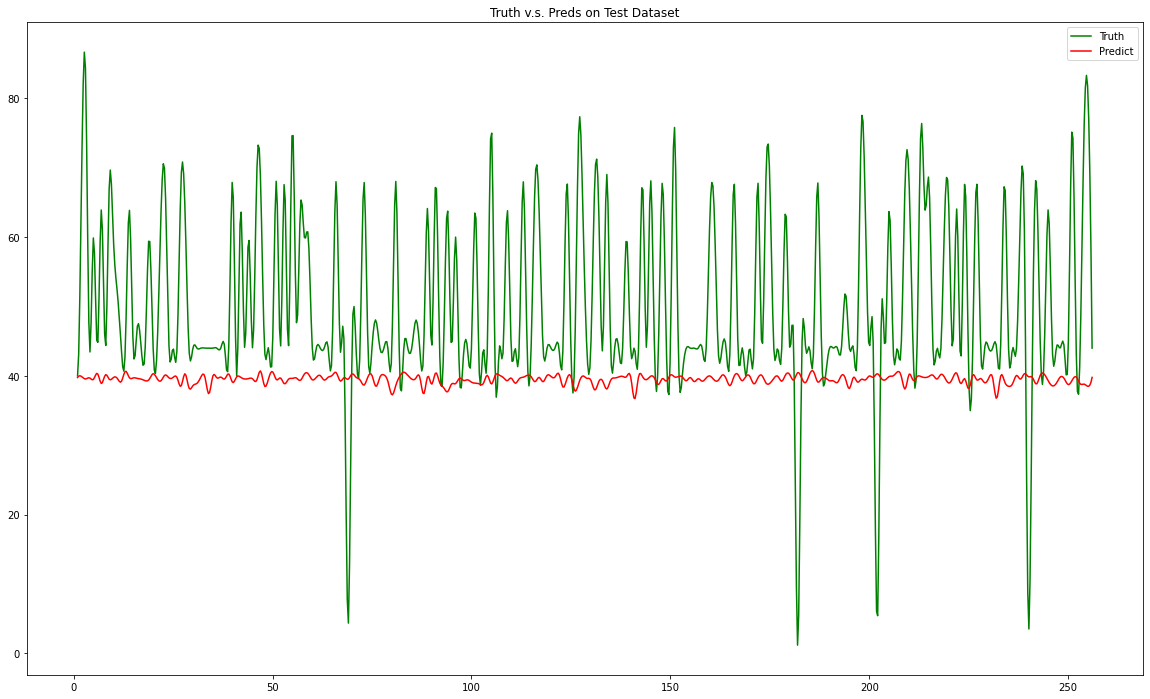

In [93]:
x = [i for i in range(1, len(truths) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths)(x_smth)
preds_smth = make_interp_spline(x, preds)(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Truth v.s. Preds on Test Dataset')
plt.show()

## 2.2 For Daily Min

In [94]:
def preprocessing(data, window_size, predict_size):
    X, y = [], []
    for i in range(len(data) - window_size - predict_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + predict_size, :2].reshape(2, -1))
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    return X, y

In [95]:
window_size, predict_size = 7, 1

X_train, y_train = preprocessing(train_min, window_size, predict_size)
X_valid, y_valid = preprocessing(valid_min, window_size, predict_size)
X_test, y_test = preprocessing(test_min, window_size, predict_size)

train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

In [96]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size * num_gpus,
                          shuffle=True, num_workers=2,
                          drop_last=True)

In [97]:
print('Train set:', X_train.shape, y_train.shape)
print('Valid set:', X_valid.shape, y_valid.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: torch.Size([929, 7, 87]) torch.Size([929, 2, 1])
Valid set: torch.Size([125, 7, 87]) torch.Size([125, 2, 1])
Test set: torch.Size([261, 7, 87]) torch.Size([261, 2, 1])


In [98]:
params = {'input_size': X_train.shape[2],
          'hidden_size': 512,
          'output_size': predict_size,
          'num_outputs': 2,
          'num_layers': 50, 
          'learning_rate': 0.5,
          'weight_decay': 1e-2,
          'step_size': 10,
          'gamma': 0.1,
          'epochs': 100}

In [99]:
def train(params, train_loader, valid_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    lr = params['learning_rate']
    wd = params['weight_decay']
    step_size = params['step_size']
    gamma = params['gamma']
    epochs = params['epochs']
    num_outputs = params['num_outputs']
    train_loss, valid_loss = [], []
    min_valid_loss = np.inf
    
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    
    loss = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,
                                                gamma=gamma)
    if MULTI_GPU:
        optimizer = nn.DataParallel(optimizer, device_ids=device_ids)
        scheduler = nn.DataParallel(scheduler, device_ids=device_ids)
        
    for epoch in tqdm(range(epochs)):
        train_ls, valid_ls = [], []
        
        model.train()
        for step, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            train_ls.append(l.item())
            l.backward()
            optimizer.step()
            if step % 10 == 0:
                print("Step {}, train loss {:.6f}".format(step, l.item()))
        train_loss.append(np.mean(train_ls))
        
        model.eval()
        for step, (X, y) in enumerate(valid_loader):
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                y_hat = model(X)
            l = 0
            for k in range(num_outputs):
                l += loss(y_hat[k, :, :], y[:, k, :])
            l /= num_outputs
            valid_ls.append(l.item())
        valid_loss.append(np.mean(valid_ls))
        if valid_loss[-1] < min_valid_loss:
            state = {'model': model.state_dict()}
            torch.save(state, path)
            min_valid_loss = valid_loss[-1]
        
        print('Epoch [{:d}/{:d}], train loss {:.6f}, valid loss {:.6f}. Now best: {:.6f}'.format(
                epoch + 1, epochs, train_loss[-1], valid_loss[-1], min_valid_loss))
        scheduler.step()
    
    return train_loss, valid_loss

In [100]:
train_loss, valid_loss = train(params, train_loader, valid_loader, 'model_min.pth')

LSTM_multi(
  (lstm): LSTM(87, 512, num_layers=50, batch_first=True)
  (linear_pred): Linear(in_features=512, out_features=1, bias=True)
  (linear_time): Linear(in_features=512, out_features=1, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Step 0, train loss 0.211157
Step 10, train loss 63.027100


  1%|          | 1/100 [00:03<05:06,  3.09s/it]

Epoch [1/100], train loss 56.975101, valid loss 55.326523. Now best: 55.326523
Step 0, train loss 39.700264
Step 10, train loss 44.154537


  2%|▏         | 2/100 [00:06<05:13,  3.20s/it]

Epoch [2/100], train loss 54.408537, valid loss 36.095680. Now best: 36.095680
Step 0, train loss 54.097427
Step 10, train loss 46.752598


  3%|▎         | 3/100 [00:09<05:27,  3.38s/it]

Epoch [3/100], train loss 47.007754, valid loss 35.676361. Now best: 35.676361
Step 0, train loss 54.099567
Step 10, train loss 42.746758


  4%|▍         | 4/100 [00:13<05:18,  3.32s/it]

Epoch [4/100], train loss 38.600398, valid loss 23.850567. Now best: 23.850567
Step 0, train loss 32.852314
Step 10, train loss 31.545052


  5%|▌         | 5/100 [00:16<05:20,  3.37s/it]

Epoch [5/100], train loss 30.680075, valid loss 20.917452. Now best: 20.917452
Step 0, train loss 22.714876
Step 10, train loss 21.907801


  6%|▌         | 6/100 [00:19<05:09,  3.29s/it]

Epoch [6/100], train loss 25.748256, valid loss 19.542034. Now best: 19.542034
Step 0, train loss 21.982925
Step 10, train loss 22.304913


  7%|▋         | 7/100 [00:21<04:19,  2.80s/it]

Epoch [7/100], train loss 22.634435, valid loss 22.799881. Now best: 19.542034
Step 0, train loss 18.726271
Step 10, train loss 21.076315


  8%|▊         | 8/100 [00:24<04:27,  2.91s/it]

Epoch [8/100], train loss 18.946913, valid loss 15.624582. Now best: 15.624582
Step 0, train loss 17.128063
Step 10, train loss 22.473045


  9%|▉         | 9/100 [00:26<03:54,  2.58s/it]

Epoch [9/100], train loss 18.984856, valid loss 17.480797. Now best: 15.624582
Step 0, train loss 18.754276
Step 10, train loss 15.451559


 10%|█         | 10/100 [00:28<03:29,  2.33s/it]

Epoch [10/100], train loss 19.062322, valid loss 22.684647. Now best: 15.624582
Step 0, train loss 17.533688
Step 10, train loss 18.399216


 11%|█         | 11/100 [00:31<03:53,  2.62s/it]

Epoch [11/100], train loss 18.027883, valid loss 13.348234. Now best: 13.348234
Step 0, train loss 13.576227
Step 10, train loss 9.562155


 12%|█▏        | 12/100 [00:34<04:09,  2.84s/it]

Epoch [12/100], train loss 9.744435, valid loss 5.604258. Now best: 5.604258
Step 0, train loss 4.608039
Step 10, train loss 2.579591


 13%|█▎        | 13/100 [00:38<04:21,  3.01s/it]

Epoch [13/100], train loss 4.161564, valid loss 2.183265. Now best: 2.183265
Step 0, train loss 2.661110
Step 10, train loss 1.061768


 14%|█▍        | 14/100 [00:41<04:24,  3.08s/it]

Epoch [14/100], train loss 1.844855, valid loss 1.457479. Now best: 1.457479
Step 0, train loss 1.355805
Step 10, train loss 0.780005


 15%|█▌        | 15/100 [00:44<04:24,  3.12s/it]

Epoch [15/100], train loss 0.879316, valid loss 0.510384. Now best: 0.510384
Step 0, train loss 0.571108
Step 10, train loss 0.215503


 16%|█▌        | 16/100 [00:48<04:29,  3.21s/it]

Epoch [16/100], train loss 0.382388, valid loss 0.254858. Now best: 0.254858
Step 0, train loss 0.322280
Step 10, train loss 0.153995


 17%|█▋        | 17/100 [00:52<04:52,  3.52s/it]

Epoch [17/100], train loss 0.166404, valid loss 0.207256. Now best: 0.207256
Step 0, train loss 0.073967
Step 10, train loss 0.057093


 18%|█▊        | 18/100 [00:56<05:02,  3.69s/it]

Epoch [18/100], train loss 0.082093, valid loss 0.126293. Now best: 0.126293
Step 0, train loss 0.068820
Step 10, train loss 0.048994


 19%|█▉        | 19/100 [00:59<04:51,  3.59s/it]

Epoch [19/100], train loss 0.054091, valid loss 0.098001. Now best: 0.098001
Step 0, train loss 0.042612
Step 10, train loss 0.033899


 20%|██        | 20/100 [01:01<04:04,  3.06s/it]

Epoch [20/100], train loss 0.037554, valid loss 0.111980. Now best: 0.098001
Step 0, train loss 0.033012
Step 10, train loss 0.030425


 21%|██        | 21/100 [01:03<03:31,  2.67s/it]

Epoch [21/100], train loss 0.031372, valid loss 0.110348. Now best: 0.098001
Step 0, train loss 0.028522
Step 10, train loss 0.038627


 22%|██▏       | 22/100 [01:06<03:44,  2.87s/it]

Epoch [22/100], train loss 0.032780, valid loss 0.093978. Now best: 0.093978
Step 0, train loss 0.034401
Step 10, train loss 0.030124


 23%|██▎       | 23/100 [01:08<03:15,  2.54s/it]

Epoch [23/100], train loss 0.030581, valid loss 0.098335. Now best: 0.093978
Step 0, train loss 0.031436
Step 10, train loss 0.029195


 24%|██▍       | 24/100 [01:11<03:29,  2.76s/it]

Epoch [24/100], train loss 0.029579, valid loss 0.091843. Now best: 0.091843
Step 0, train loss 0.027646
Step 10, train loss 0.023981


 25%|██▌       | 25/100 [01:15<03:36,  2.88s/it]

Epoch [25/100], train loss 0.029487, valid loss 0.089847. Now best: 0.089847
Step 0, train loss 0.036227
Step 10, train loss 0.024035


 26%|██▌       | 26/100 [01:16<03:08,  2.55s/it]

Epoch [26/100], train loss 0.027840, valid loss 0.091127. Now best: 0.089847
Step 0, train loss 0.026557
Step 10, train loss 0.030453


 27%|██▋       | 27/100 [01:19<03:19,  2.73s/it]

Epoch [27/100], train loss 0.027565, valid loss 0.083204. Now best: 0.083204
Step 0, train loss 0.026284
Step 10, train loss 0.027244


 28%|██▊       | 28/100 [01:21<02:57,  2.46s/it]

Epoch [28/100], train loss 0.027792, valid loss 0.086458. Now best: 0.083204
Step 0, train loss 0.030548
Step 10, train loss 0.023472


 29%|██▉       | 29/100 [01:23<02:39,  2.25s/it]

Epoch [29/100], train loss 0.026841, valid loss 0.086818. Now best: 0.083204
Step 0, train loss 0.020341
Step 10, train loss 0.032395


 30%|███       | 30/100 [01:25<02:26,  2.10s/it]

Epoch [30/100], train loss 0.026934, valid loss 0.093268. Now best: 0.083204
Step 0, train loss 0.026896
Step 10, train loss 0.035118


 31%|███       | 31/100 [01:27<02:17,  2.00s/it]

Epoch [31/100], train loss 0.025736, valid loss 0.083504. Now best: 0.083204
Step 0, train loss 0.033109
Step 10, train loss 0.040117


 32%|███▏      | 32/100 [01:28<02:11,  1.93s/it]

Epoch [32/100], train loss 0.026977, valid loss 0.084057. Now best: 0.083204
Step 0, train loss 0.028763
Step 10, train loss 0.030455


 33%|███▎      | 33/100 [01:30<02:05,  1.88s/it]

Epoch [33/100], train loss 0.025891, valid loss 0.091944. Now best: 0.083204
Step 0, train loss 0.025757
Step 10, train loss 0.027939


 34%|███▍      | 34/100 [01:32<02:04,  1.89s/it]

Epoch [34/100], train loss 0.026583, valid loss 0.091691. Now best: 0.083204
Step 0, train loss 0.024682
Step 10, train loss 0.021942


 35%|███▌      | 35/100 [01:34<02:00,  1.85s/it]

Epoch [35/100], train loss 0.025900, valid loss 0.086683. Now best: 0.083204
Step 0, train loss 0.029817
Step 10, train loss 0.023963


 36%|███▌      | 36/100 [01:36<01:59,  1.87s/it]

Epoch [36/100], train loss 0.026177, valid loss 0.099159. Now best: 0.083204
Step 0, train loss 0.021374
Step 10, train loss 0.023563


 37%|███▋      | 37/100 [01:38<01:57,  1.86s/it]

Epoch [37/100], train loss 0.025657, valid loss 0.085711. Now best: 0.083204
Step 0, train loss 0.028662
Step 10, train loss 0.027005


 38%|███▊      | 38/100 [01:39<01:53,  1.83s/it]

Epoch [38/100], train loss 0.025443, valid loss 0.092691. Now best: 0.083204
Step 0, train loss 0.029229
Step 10, train loss 0.037393


 39%|███▉      | 39/100 [01:43<02:17,  2.25s/it]

Epoch [39/100], train loss 0.025809, valid loss 0.079631. Now best: 0.079631
Step 0, train loss 0.025135
Step 10, train loss 0.032273


 40%|████      | 40/100 [01:46<02:32,  2.55s/it]

Epoch [40/100], train loss 0.025510, valid loss 0.072579. Now best: 0.072579
Step 0, train loss 0.022811
Step 10, train loss 0.026491


 41%|████      | 41/100 [01:48<02:16,  2.32s/it]

Epoch [41/100], train loss 0.026646, valid loss 0.093329. Now best: 0.072579
Step 0, train loss 0.026660
Step 10, train loss 0.026564


 42%|████▏     | 42/100 [01:49<02:05,  2.16s/it]

Epoch [42/100], train loss 0.025376, valid loss 0.089346. Now best: 0.072579
Step 0, train loss 0.021212
Step 10, train loss 0.026531


 43%|████▎     | 43/100 [01:51<01:55,  2.03s/it]

Epoch [43/100], train loss 0.025624, valid loss 0.086070. Now best: 0.072579
Step 0, train loss 0.024573
Step 10, train loss 0.025196


 44%|████▍     | 44/100 [01:53<01:49,  1.95s/it]

Epoch [44/100], train loss 0.024973, valid loss 0.086629. Now best: 0.072579
Step 0, train loss 0.021343
Step 10, train loss 0.026776


 45%|████▌     | 45/100 [01:55<01:45,  1.92s/it]

Epoch [45/100], train loss 0.026368, valid loss 0.085850. Now best: 0.072579
Step 0, train loss 0.020728
Step 10, train loss 0.020400


 46%|████▌     | 46/100 [01:56<01:40,  1.87s/it]

Epoch [46/100], train loss 0.025877, valid loss 0.079878. Now best: 0.072579
Step 0, train loss 0.022862
Step 10, train loss 0.020895


 47%|████▋     | 47/100 [01:58<01:37,  1.84s/it]

Epoch [47/100], train loss 0.025156, valid loss 0.094837. Now best: 0.072579
Step 0, train loss 0.021297
Step 10, train loss 0.031460


 48%|████▊     | 48/100 [02:00<01:34,  1.82s/it]

Epoch [48/100], train loss 0.025609, valid loss 0.082659. Now best: 0.072579
Step 0, train loss 0.036596
Step 10, train loss 0.023278


 49%|████▉     | 49/100 [02:02<01:33,  1.83s/it]

Epoch [49/100], train loss 0.025912, valid loss 0.088148. Now best: 0.072579
Step 0, train loss 0.019488
Step 10, train loss 0.021973


 50%|█████     | 50/100 [02:04<01:30,  1.82s/it]

Epoch [50/100], train loss 0.025312, valid loss 0.084895. Now best: 0.072579
Step 0, train loss 0.027100
Step 10, train loss 0.033002


 51%|█████     | 51/100 [02:05<01:29,  1.83s/it]

Epoch [51/100], train loss 0.025892, valid loss 0.092473. Now best: 0.072579
Step 0, train loss 0.022606
Step 10, train loss 0.025503


 52%|█████▏    | 52/100 [02:07<01:29,  1.87s/it]

Epoch [52/100], train loss 0.025514, valid loss 0.093622. Now best: 0.072579
Step 0, train loss 0.023624
Step 10, train loss 0.027516


 53%|█████▎    | 53/100 [02:09<01:27,  1.86s/it]

Epoch [53/100], train loss 0.026195, valid loss 0.085274. Now best: 0.072579
Step 0, train loss 0.029495
Step 10, train loss 0.023668


 54%|█████▍    | 54/100 [02:11<01:24,  1.83s/it]

Epoch [54/100], train loss 0.024948, valid loss 0.087338. Now best: 0.072579
Step 0, train loss 0.020703
Step 10, train loss 0.019665


 55%|█████▌    | 55/100 [02:13<01:21,  1.81s/it]

Epoch [55/100], train loss 0.025643, valid loss 0.092225. Now best: 0.072579
Step 0, train loss 0.027793
Step 10, train loss 0.022577


 56%|█████▌    | 56/100 [02:15<01:19,  1.80s/it]

Epoch [56/100], train loss 0.026281, valid loss 0.092003. Now best: 0.072579
Step 0, train loss 0.034630
Step 10, train loss 0.023920


 57%|█████▋    | 57/100 [02:16<01:17,  1.81s/it]

Epoch [57/100], train loss 0.025698, valid loss 0.087806. Now best: 0.072579
Step 0, train loss 0.031947
Step 10, train loss 0.037164


 58%|█████▊    | 58/100 [02:18<01:15,  1.79s/it]

Epoch [58/100], train loss 0.025636, valid loss 0.089565. Now best: 0.072579
Step 0, train loss 0.025844
Step 10, train loss 0.033159


 59%|█████▉    | 59/100 [02:20<01:13,  1.78s/it]

Epoch [59/100], train loss 0.025826, valid loss 0.077021. Now best: 0.072579
Step 0, train loss 0.023780
Step 10, train loss 0.029234


 60%|██████    | 60/100 [02:22<01:10,  1.77s/it]

Epoch [60/100], train loss 0.024983, valid loss 0.084095. Now best: 0.072579
Step 0, train loss 0.019205
Step 10, train loss 0.026425


 61%|██████    | 61/100 [02:23<01:09,  1.77s/it]

Epoch [61/100], train loss 0.025757, valid loss 0.092635. Now best: 0.072579
Step 0, train loss 0.020706
Step 10, train loss 0.026752


 62%|██████▏   | 62/100 [02:25<01:07,  1.77s/it]

Epoch [62/100], train loss 0.025876, valid loss 0.087873. Now best: 0.072579
Step 0, train loss 0.025039
Step 10, train loss 0.021791


 63%|██████▎   | 63/100 [02:27<01:06,  1.79s/it]

Epoch [63/100], train loss 0.026520, valid loss 0.092899. Now best: 0.072579
Step 0, train loss 0.022065
Step 10, train loss 0.025222


 64%|██████▍   | 64/100 [02:29<01:04,  1.78s/it]

Epoch [64/100], train loss 0.024785, valid loss 0.081271. Now best: 0.072579
Step 0, train loss 0.024147
Step 10, train loss 0.027762


 65%|██████▌   | 65/100 [02:31<01:02,  1.78s/it]

Epoch [65/100], train loss 0.025960, valid loss 0.091418. Now best: 0.072579
Step 0, train loss 0.022153
Step 10, train loss 0.021717


 66%|██████▌   | 66/100 [02:32<01:01,  1.80s/it]

Epoch [66/100], train loss 0.025755, valid loss 0.095249. Now best: 0.072579
Step 0, train loss 0.029766
Step 10, train loss 0.020412


 67%|██████▋   | 67/100 [02:34<00:59,  1.79s/it]

Epoch [67/100], train loss 0.025135, valid loss 0.086544. Now best: 0.072579
Step 0, train loss 0.029699
Step 10, train loss 0.022321


 68%|██████▊   | 68/100 [02:36<00:57,  1.78s/it]

Epoch [68/100], train loss 0.025852, valid loss 0.076831. Now best: 0.072579
Step 0, train loss 0.032276
Step 10, train loss 0.023213


 69%|██████▉   | 69/100 [02:38<00:55,  1.80s/it]

Epoch [69/100], train loss 0.025712, valid loss 0.081369. Now best: 0.072579
Step 0, train loss 0.023213
Step 10, train loss 0.020141


 70%|███████   | 70/100 [02:40<00:55,  1.84s/it]

Epoch [70/100], train loss 0.025869, valid loss 0.080396. Now best: 0.072579
Step 0, train loss 0.025979
Step 10, train loss 0.021090


 71%|███████   | 71/100 [02:41<00:52,  1.82s/it]

Epoch [71/100], train loss 0.025762, valid loss 0.087090. Now best: 0.072579
Step 0, train loss 0.026177
Step 10, train loss 0.028663


 72%|███████▏  | 72/100 [02:43<00:50,  1.80s/it]

Epoch [72/100], train loss 0.025334, valid loss 0.091948. Now best: 0.072579
Step 0, train loss 0.024854
Step 10, train loss 0.022311


 73%|███████▎  | 73/100 [02:45<00:48,  1.79s/it]

Epoch [73/100], train loss 0.026370, valid loss 0.089730. Now best: 0.072579
Step 0, train loss 0.022022
Step 10, train loss 0.031081


 74%|███████▍  | 74/100 [02:47<00:46,  1.78s/it]

Epoch [74/100], train loss 0.025311, valid loss 0.091571. Now best: 0.072579
Step 0, train loss 0.027299
Step 10, train loss 0.028456


 75%|███████▌  | 75/100 [02:49<00:45,  1.82s/it]

Epoch [75/100], train loss 0.025808, valid loss 0.083022. Now best: 0.072579
Step 0, train loss 0.023811
Step 10, train loss 0.028788


 76%|███████▌  | 76/100 [02:50<00:43,  1.81s/it]

Epoch [76/100], train loss 0.025299, valid loss 0.078106. Now best: 0.072579
Step 0, train loss 0.019432
Step 10, train loss 0.024563


 77%|███████▋  | 77/100 [02:52<00:41,  1.79s/it]

Epoch [77/100], train loss 0.026406, valid loss 0.091374. Now best: 0.072579
Step 0, train loss 0.031763
Step 10, train loss 0.020895


 78%|███████▊  | 78/100 [02:54<00:39,  1.79s/it]

Epoch [78/100], train loss 0.026307, valid loss 0.080434. Now best: 0.072579
Step 0, train loss 0.018995
Step 10, train loss 0.023924


 79%|███████▉  | 79/100 [02:56<00:37,  1.78s/it]

Epoch [79/100], train loss 0.025593, valid loss 0.089966. Now best: 0.072579
Step 0, train loss 0.029575
Step 10, train loss 0.024173


 80%|████████  | 80/100 [02:58<00:35,  1.78s/it]

Epoch [80/100], train loss 0.025251, valid loss 0.080586. Now best: 0.072579
Step 0, train loss 0.029324
Step 10, train loss 0.029393


 81%|████████  | 81/100 [02:59<00:34,  1.81s/it]

Epoch [81/100], train loss 0.026117, valid loss 0.099584. Now best: 0.072579
Step 0, train loss 0.019457
Step 10, train loss 0.023514


 82%|████████▏ | 82/100 [03:01<00:32,  1.81s/it]

Epoch [82/100], train loss 0.026073, valid loss 0.080685. Now best: 0.072579
Step 0, train loss 0.022433
Step 10, train loss 0.028796


 83%|████████▎ | 83/100 [03:03<00:31,  1.83s/it]

Epoch [83/100], train loss 0.024760, valid loss 0.091206. Now best: 0.072579
Step 0, train loss 0.022051
Step 10, train loss 0.032068


 84%|████████▍ | 84/100 [03:05<00:28,  1.81s/it]

Epoch [84/100], train loss 0.025436, valid loss 0.090903. Now best: 0.072579
Step 0, train loss 0.017447
Step 10, train loss 0.023579


 85%|████████▌ | 85/100 [03:07<00:26,  1.80s/it]

Epoch [85/100], train loss 0.024677, valid loss 0.091139. Now best: 0.072579
Step 0, train loss 0.022588
Step 10, train loss 0.027891


 86%|████████▌ | 86/100 [03:08<00:25,  1.79s/it]

Epoch [86/100], train loss 0.025579, valid loss 0.092868. Now best: 0.072579
Step 0, train loss 0.022425
Step 10, train loss 0.022193


 87%|████████▋ | 87/100 [03:10<00:23,  1.83s/it]

Epoch [87/100], train loss 0.025198, valid loss 0.092572. Now best: 0.072579
Step 0, train loss 0.032044
Step 10, train loss 0.029172


 88%|████████▊ | 88/100 [03:13<00:23,  1.96s/it]

Epoch [88/100], train loss 0.025327, valid loss 0.089665. Now best: 0.072579
Step 0, train loss 0.027244
Step 10, train loss 0.028678


 89%|████████▉ | 89/100 [03:14<00:20,  1.90s/it]

Epoch [89/100], train loss 0.025831, valid loss 0.089051. Now best: 0.072579
Step 0, train loss 0.027109
Step 10, train loss 0.033452


 90%|█████████ | 90/100 [03:16<00:18,  1.86s/it]

Epoch [90/100], train loss 0.025914, valid loss 0.085160. Now best: 0.072579
Step 0, train loss 0.018535
Step 10, train loss 0.027278


 91%|█████████ | 91/100 [03:18<00:16,  1.83s/it]

Epoch [91/100], train loss 0.024981, valid loss 0.094586. Now best: 0.072579
Step 0, train loss 0.022298
Step 10, train loss 0.022767


 92%|█████████▏| 92/100 [03:20<00:14,  1.81s/it]

Epoch [92/100], train loss 0.025565, valid loss 0.081527. Now best: 0.072579
Step 0, train loss 0.021999
Step 10, train loss 0.032952


 93%|█████████▎| 93/100 [03:22<00:12,  1.83s/it]

Epoch [93/100], train loss 0.026015, valid loss 0.090106. Now best: 0.072579
Step 0, train loss 0.038736
Step 10, train loss 0.021821


 94%|█████████▍| 94/100 [03:23<00:10,  1.82s/it]

Epoch [94/100], train loss 0.025351, valid loss 0.088809. Now best: 0.072579
Step 0, train loss 0.025313
Step 10, train loss 0.026138


 95%|█████████▌| 95/100 [03:25<00:09,  1.81s/it]

Epoch [95/100], train loss 0.025827, valid loss 0.094575. Now best: 0.072579
Step 0, train loss 0.031234
Step 10, train loss 0.027534


 96%|█████████▌| 96/100 [03:27<00:07,  1.80s/it]

Epoch [96/100], train loss 0.025561, valid loss 0.082304. Now best: 0.072579
Step 0, train loss 0.026644
Step 10, train loss 0.024022


 97%|█████████▋| 97/100 [03:29<00:05,  1.79s/it]

Epoch [97/100], train loss 0.024880, valid loss 0.078660. Now best: 0.072579
Step 0, train loss 0.032457
Step 10, train loss 0.026967


 98%|█████████▊| 98/100 [03:30<00:03,  1.78s/it]

Epoch [98/100], train loss 0.025015, valid loss 0.087149. Now best: 0.072579
Step 0, train loss 0.031127
Step 10, train loss 0.022912


 99%|█████████▉| 99/100 [03:32<00:01,  1.81s/it]

Epoch [99/100], train loss 0.026182, valid loss 0.080266. Now best: 0.072579
Step 0, train loss 0.025762
Step 10, train loss 0.025448


100%|██████████| 100/100 [03:34<00:00,  2.15s/it]

Epoch [100/100], train loss 0.025856, valid loss 0.095095. Now best: 0.072579


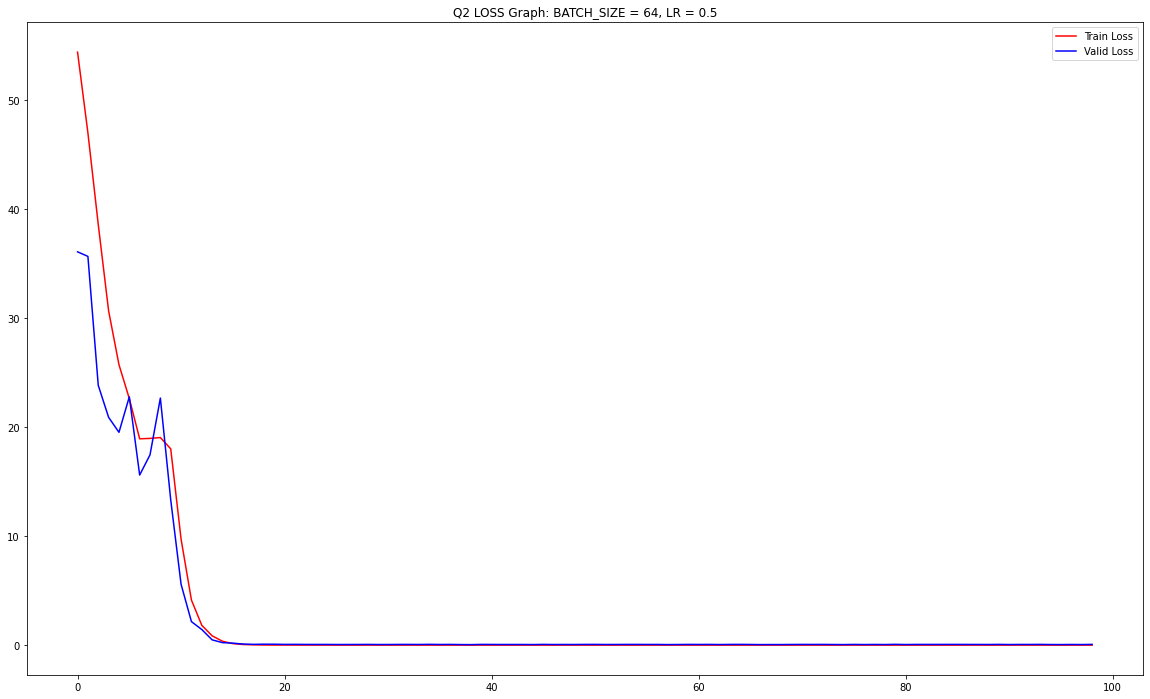

In [101]:
x = np.arange(len(train_loss[1:]))
plt.figure(figsize=(20, 12))
plt.plot(x, train_loss[1:], color='r', label='Train Loss')
plt.plot(x, valid_loss[1:], color='b', label='Valid Loss')
plt.title(f"Q2 LOSS Graph: BATCH_SIZE = {batch_size}, LR = {params['learning_rate']}")
plt.legend()
plt.show()

In [102]:
def test(params, test_loader, path):
    input_size = params['input_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    output_size = params['output_size']
    num_outputs = params['num_outputs']
    truths, preds = [[], []], [[], []]
    model = LSTM_multi(input_size, hidden_size, num_layers, output_size, batch_size)
    print(model)
    if MULTI_GPU:
        model = nn.DataParallel(model, device_ids=device_ids)
    model.load_state_dict(torch.load(path)['model'])
    model.to(device)
    
    model.eval()
    for X, y in tqdm(test_loader):
        X = X.to(device)
        for k in range(num_outputs):
            truths[k].extend(y[:, k, :].view(-1).cpu().numpy())
        with torch.no_grad():
            y_hat = model(X)
            for k in range(num_outputs):
                preds[k].extend(y_hat[k, :, :].view(-1).cpu().numpy())
    truths, preds = np.array(truths), np.array(preds)
    for vals in [truths, preds]:
        vals[0] = vals[0] * (test_min_power_range[1] - test_min_power_range[0]) + test_min_power_range[0]
        vals[1] = vals[1] * (test_min_tick_range[1] - test_min_tick_range[0]) + test_min_tick_range[0]
    scores = pd.DataFrame(columns=['MAPE', 'MAE', 'MSE', 'R2 Score'])
    for k in range(num_outputs):
        scores.loc[k, 'MAPE'] = mape(truths[k], preds[k])
        scores.loc[k, 'MAE'] = MAE(truths[k], preds[k])
        scores.loc[k, 'MSE'] = MSE(truths[k], preds[k])
        scores.loc[k, 'R2 Score'] = r2_score(truths[k], preds[k])
    return truths, preds, scores


In [103]:
truths, preds, scores = test(params, test_loader, 'model_min.pth')

LSTM_multi(
  (lstm): LSTM(87, 512, num_layers=50, batch_first=True)
  (linear_pred): Linear(in_features=512, out_features=1, bias=True)
  (linear_time): Linear(in_features=512, out_features=1, bias=True)
)


100%|██████████| 4/4 [00:00<00:00, 12.98it/s]


In [104]:
scores

MAPE           MAE           MSE  R2 Score
0  51.111251  58122.515625  3969431040.0 -2.257027
1  55.412173     11.120763    241.206024 -0.373278

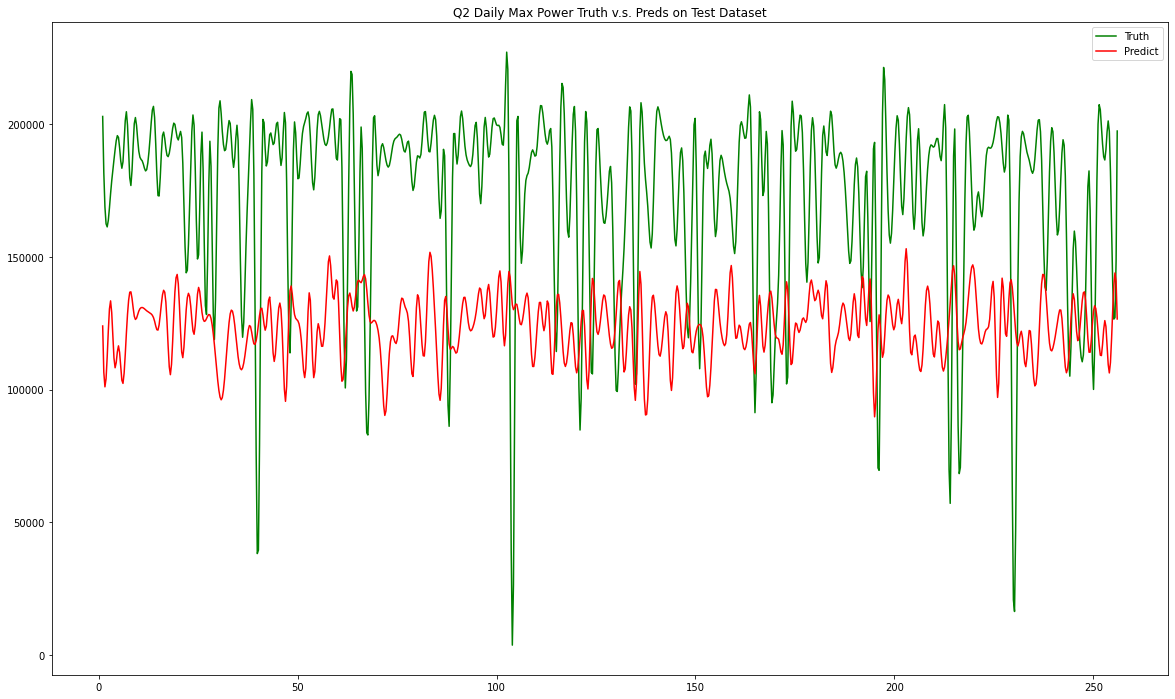

In [105]:
x = [i for i in range(1, len(truths[0]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[0])(x_smth)
preds_smth = make_interp_spline(x, preds[0])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Power Truth v.s. Preds on Test Dataset')
plt.show()

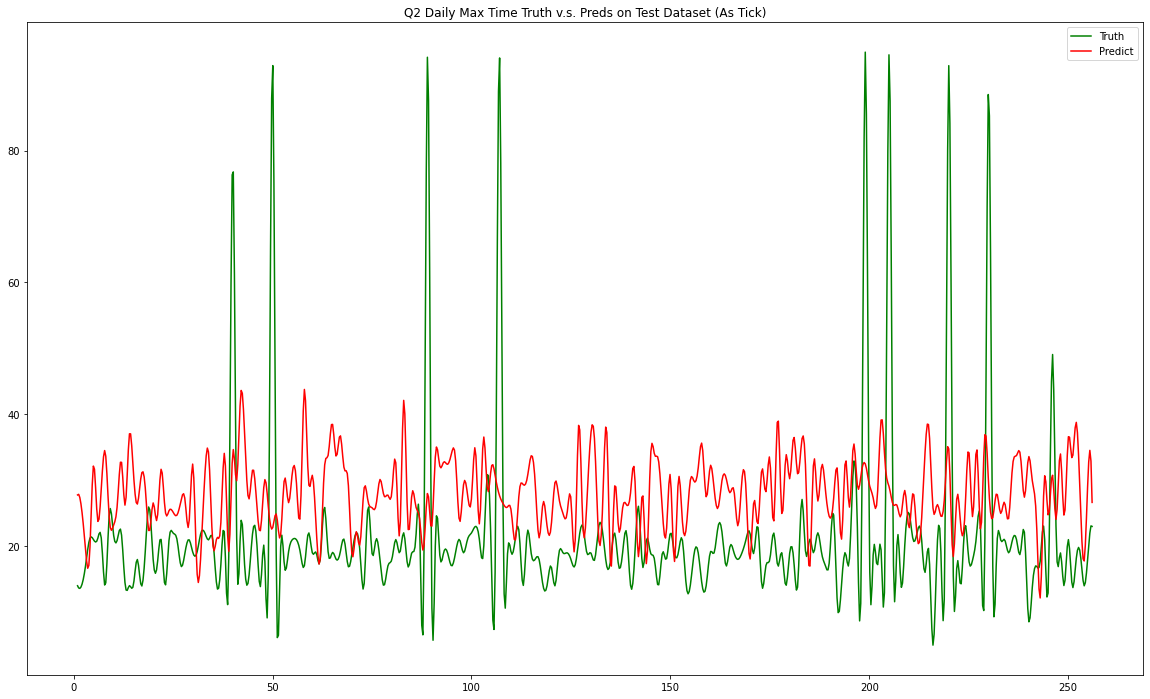

In [106]:
x = [i for i in range(1, len(truths[1]) + 1)]
x_smth = np.linspace(np.min(x), np.max(x), 900)
truths_smth = make_interp_spline(x, truths[1])(x_smth)
preds_smth = make_interp_spline(x, preds[1])(x_smth)
plt.figure(figsize=(20, 12))
plt.plot(x_smth, truths_smth, color='g', label='Truth')
plt.plot(x_smth, preds_smth, color='r', label='Predict')
plt.legend()
plt.title('Q2 Daily Max Time Truth v.s. Preds on Test Dataset (As Tick)')
plt.show()

# Q3

In [107]:
cat_data = pd.read_csv('../input/electrical-energy-load/train/2.csv')
cat_data.head()

行业类型        数据时间  有功功率最大值（kw）  有功功率最小值（kw）
0  大工业用电  2019-01-01  117888.3300   51526.5690
1  大工业用电  2019-01-02  126843.7914   63638.4294
2  大工业用电  2019-01-03  130286.1294  102048.2754
3  大工业用电  2019-01-04  133018.6344  104466.0762
4  大工业用电  2019-01-05  133504.4784   99507.3528

In [108]:
cat_data.columns = ['Category', 'Date', 'MaxPower', 'MinPower']
cat_data['Date'] = pd.to_datetime(cat_data['Date'])
cat_data['Category'].value_counts()

大工业用电    973
普通工业     973
商业       973
非普工业     691
Name: Category, dtype: int64

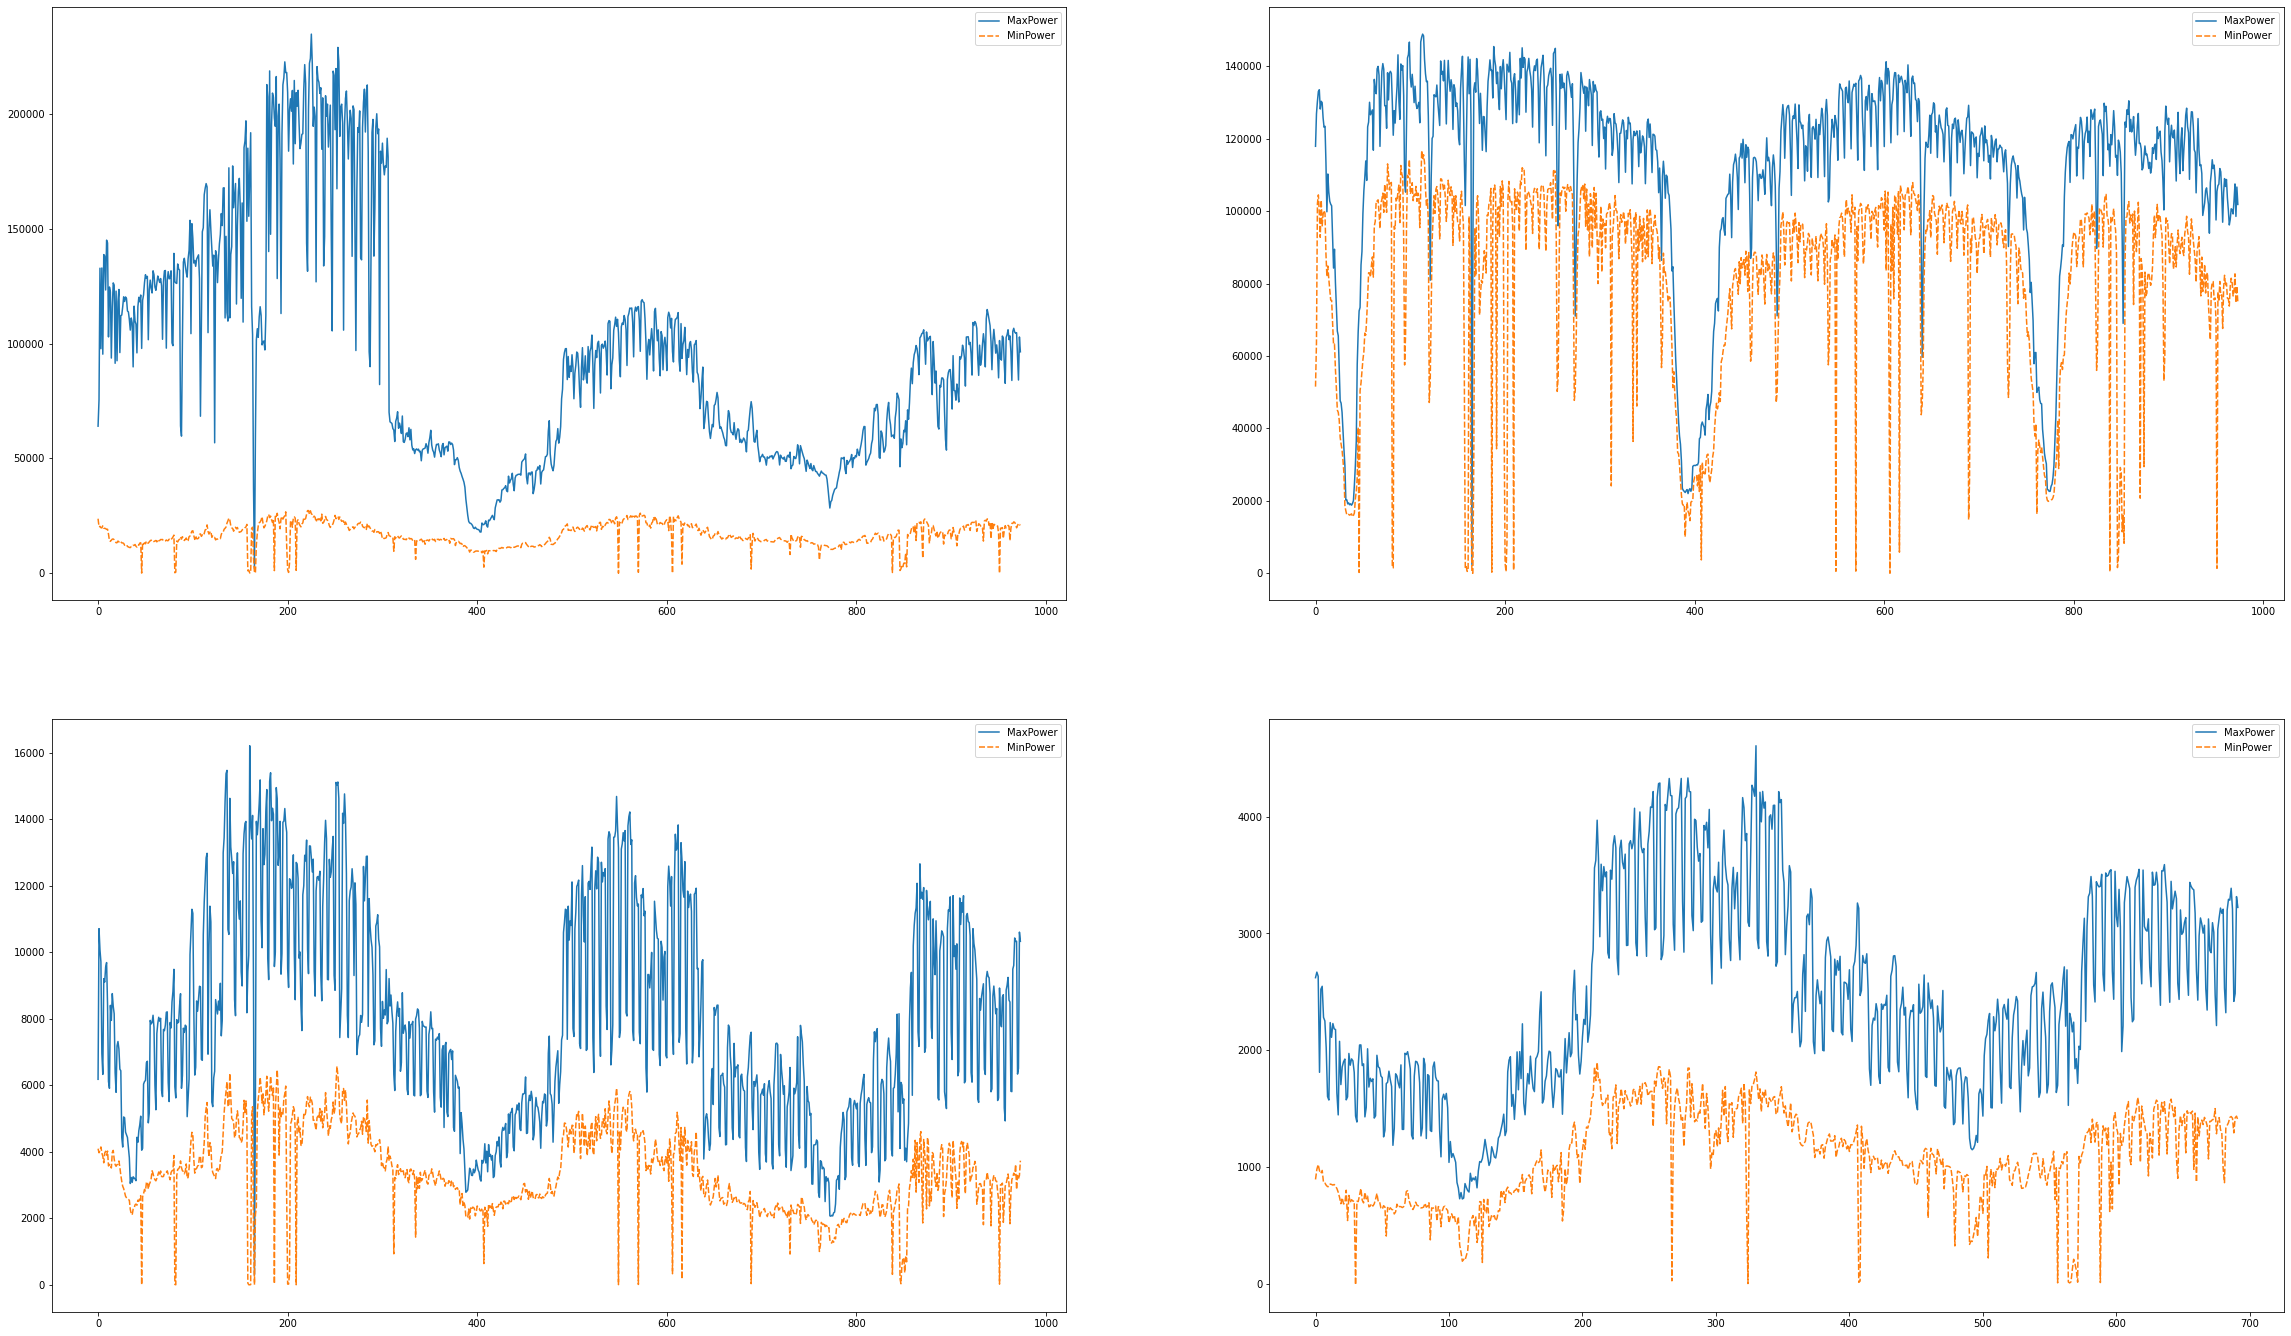

In [109]:
groups = cat_data.groupby(['Category'], as_index=False)
fig, axes = plt.subplots(2, 2, figsize=(40, 24))
all_data = pd.DataFrame(columns=['Category', 'Date', 'MaxPower', 'MinPower'])
for i, group in enumerate(groups):
    x, y = i // 2, i % 2
    category, df = group
    grouper = pd.Grouper(key='Date', freq='D')
    res = df.groupby(grouper).first().reset_index()
    res = res[['Category', 'Date', 'MaxPower', 'MinPower']]
    all_data = pd.concat([all_data, res], ignore_index=True)
    res['MaxPower'] = res['MaxPower'].interpolate()
    res['MinPower'] = res['MinPower'].interpolate()
    res.to_csv(f'{category}.csv', index=False)
    sns.lineplot(data=res[['MaxPower', 'MinPower']], ax=axes[x][y])
all_data.to_csv('处理后数据.csv', index=False)

## Q3.1

In [110]:
all_data.head()

Category       Date     MaxPower    MinPower
0       商业 2019-01-01   64027.8582  23758.7970
1       商业 2019-01-02   75467.2143  20231.6265
2       商业 2019-01-03  132776.9442  20443.6182
3       商业 2019-01-04   97731.1308  19858.1592
4       商业 2019-01-05  132883.1868  19766.6994

In [111]:
def MK(inputdata):
    inputdata = np.array(inputdata)
    n=inputdata.shape[0]
    # 正序列计算---------------------------------
    # 定义累计量序列Sk，初始值=0
    Sk             = [0]
    # 定义统计量UFk，初始值 =0
    UFk            = [0]
    # 定义Sk序列元素s，初始值 =0
    s              =  0
    Exp_value      = [0]
    Var_value      = [0]
    # i从1开始，因为根据统计量UFk公式，i=0时，Sk(0)、E(0)、Var(0)均为0
    # 此时UFk无意义，因此公式中，令UFk(0)=0
    for i in range(1,n):
        for j in range(i):
            if inputdata[i] > inputdata[j]:
                s = s+1
            else:
                s = s+0
        Sk.append(s)
        Exp_value.append((i+1)*(i+2)/4 )                     # Sk[i]的均值
        Var_value.append((i+1)*i*(2*(i+1)+5)/72 )            # Sk[i]的方差
        UFk.append((Sk[i]-Exp_value[i])/np.sqrt(Var_value[i]))
    # ------------------------------正序列计算
    # 逆序列计算---------------------------------
    # 定义逆序累计量序列Sk2，长度与inputdata一致，初始值=0
    Sk2             = [0]
    # 定义逆序统计量UBk，长度与inputdata一致，初始值=0
    UBk             = [0]
    UBk2            = [0]
    # s归0
    s2              =  0
    Exp_value2      = [0]
    Var_value2      = [0]
    # 按时间序列逆转样本y
    inputdataT = list(reversed(inputdata))
    # i从2开始，因为根据统计量UBk公式，i=1时，Sk2(1)、E(1)、Var(1)均为0
    # 此时UBk无意义，因此公式中，令UBk(1)=0
    for i in range(1,n):
        for j in range(i):
            if inputdataT[i] > inputdataT[j]:
                s2 = s2+1
            else:
                s2 = s2+0
        Sk2.append(s2)
        Exp_value2.append((i+1)*(i+2)/4 )                     # Sk[i]的均值
        Var_value2.append((i+1)*i*(2*(i+1)+5)/72 )            # Sk[i]的方差
        UBk.append((Sk2[i]-Exp_value2[i])/np.sqrt(Var_value2[i]))
        UBk2.append(-UBk[i])
    # 由于对逆序序列的累计量Sk2的构建中，依然用的是累加法，即后者大于前者时s加1，
    # 则s的大小表征了一种上升的趋势的大小，而序列逆序以后，应当表现出与原序列相反
    # 的趋势表现，因此，用累加法统计Sk2序列，统计量公式(S(i)-E(i))/sqrt(Var(i))
    #也不应改变，但统计量UBk应取相反数以表征正确的逆序序列的趋势
    #  UBk(i)=0-(Sk2(i)-E)/sqrt(Var)
    # ------------------------------逆序列计算
    # 此时上一步的到UBk表现的是逆序列在逆序时间上的趋势统计量
    # 与UFk做图寻找突变点时，2条曲线应具有同样的时间轴，因此
    # 再按时间序列逆转结果统计量UBk，得到时间正序的UBkT，
    UBkT = list(reversed(UBk2))
    diff = np.array(UFk) - np.array(UBkT)
    K    = list()
    # 找出交叉点
    for k in range(1,n):
        if diff[k-1]*diff[k]<0:
            K.append(k)
    # 做突变检测图时，使用UFk和UBkT
    plt.figure(figsize=(20, 12))
    plt.plot(range(1,n+1) ,UFk  ,label='UFk') # UFk
    plt.plot(range(1,n+1) ,UBkT ,label='UBk') # UBk
    plt.ylabel('UFk-UBk Graph')
    x_lim = plt.xlim()
    plt.plot(x_lim,[-1.96,-1.96],'m--',color='r')
    plt.plot(x_lim,[  0  ,  0  ],'m--')
    plt.plot(x_lim,[+1.96,+1.96],'m--',color='r')
    plt.legend(loc=2) # 图例
    plt.title('UFk-UBk')
    plt.show()
    return K

==================商业====================


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "m--" (-> color='m'). The keyword argument will take precedence.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "m--" (-> color='m'). The keyword argument will take precedence.


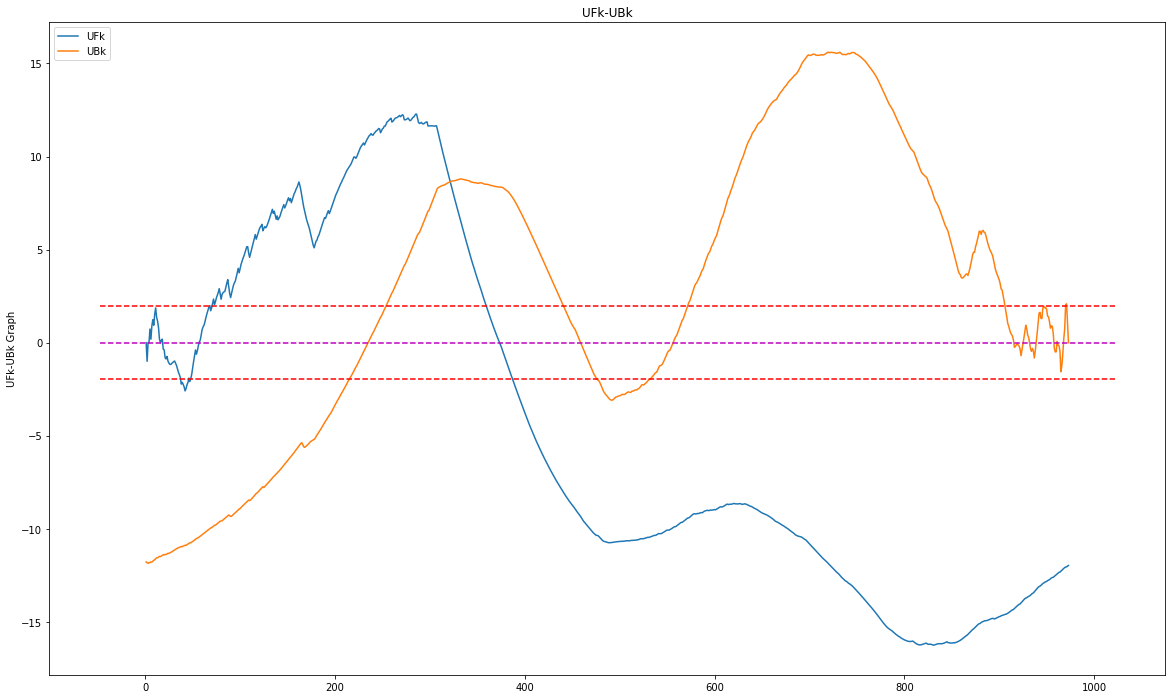

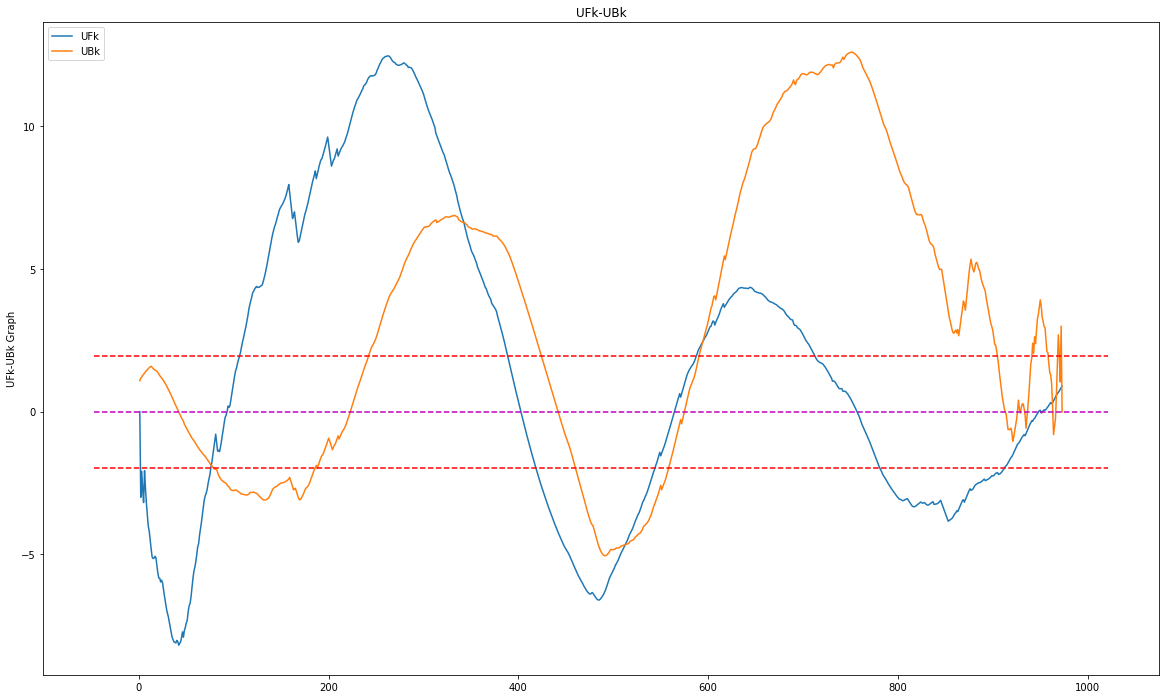

Category 商业 max: [321]
Category 商业 min: [76, 342, 512, 594, 962, 966, 972]


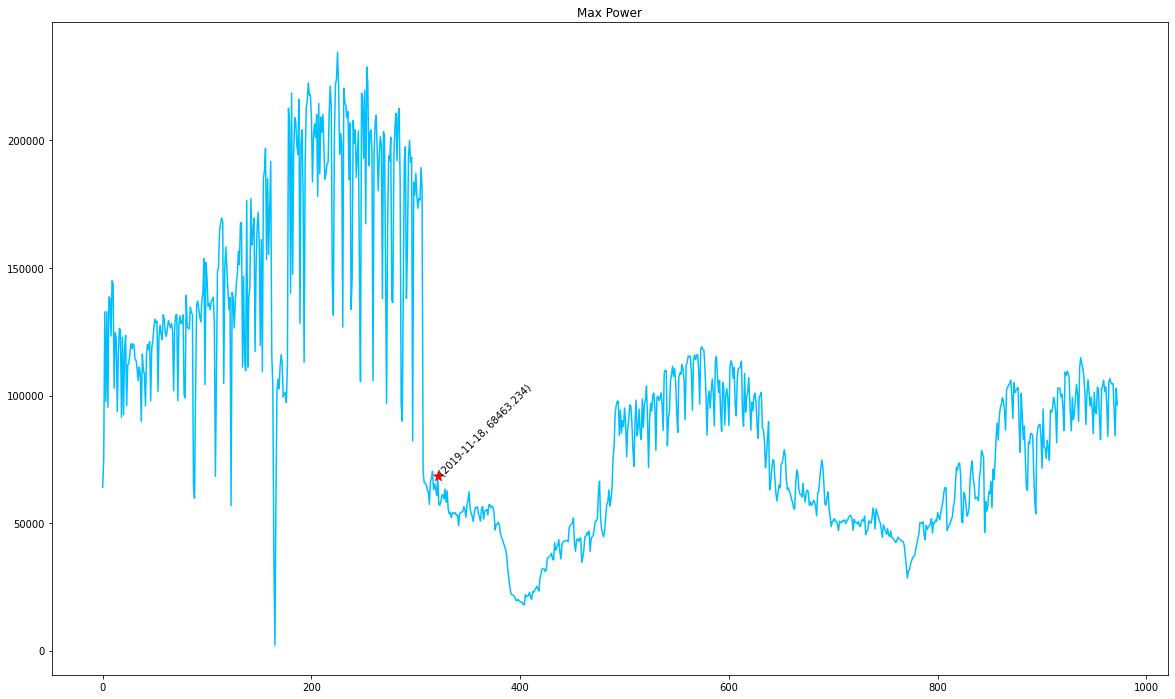

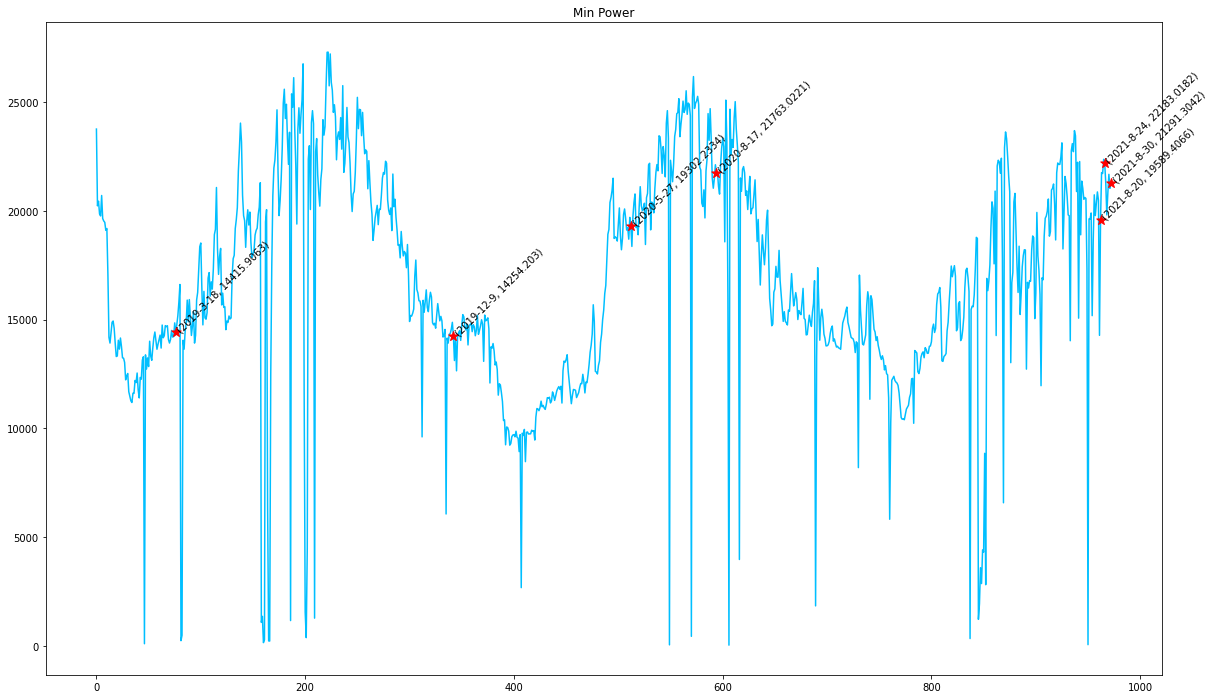

==================大工业用电====================


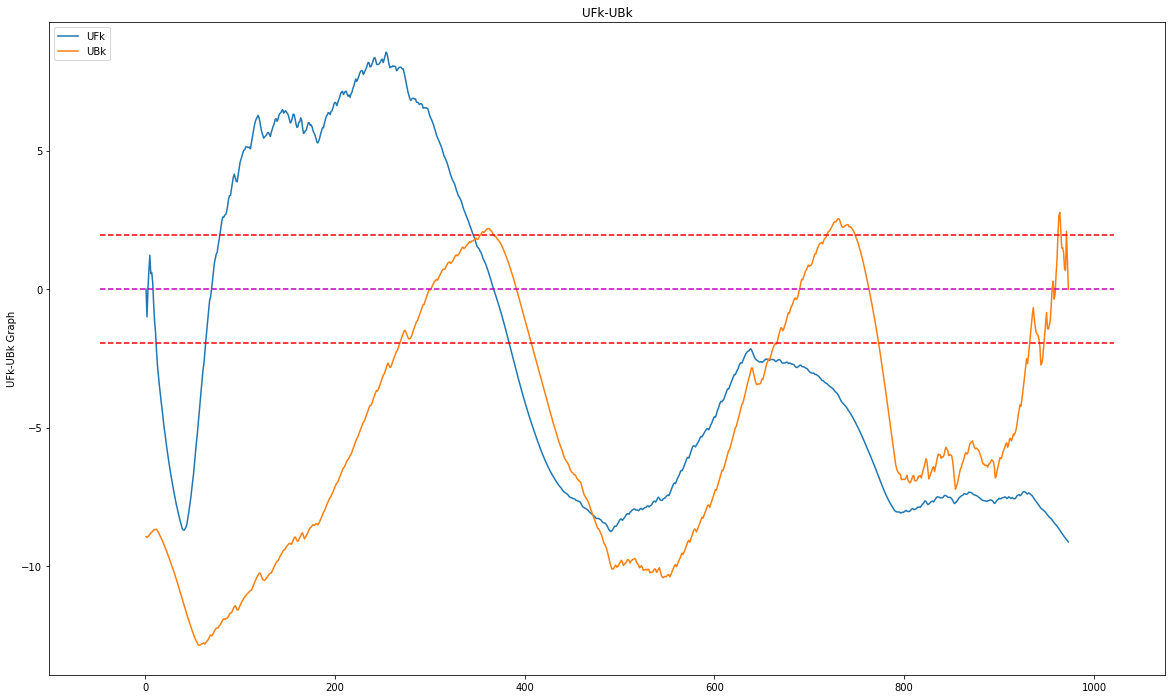

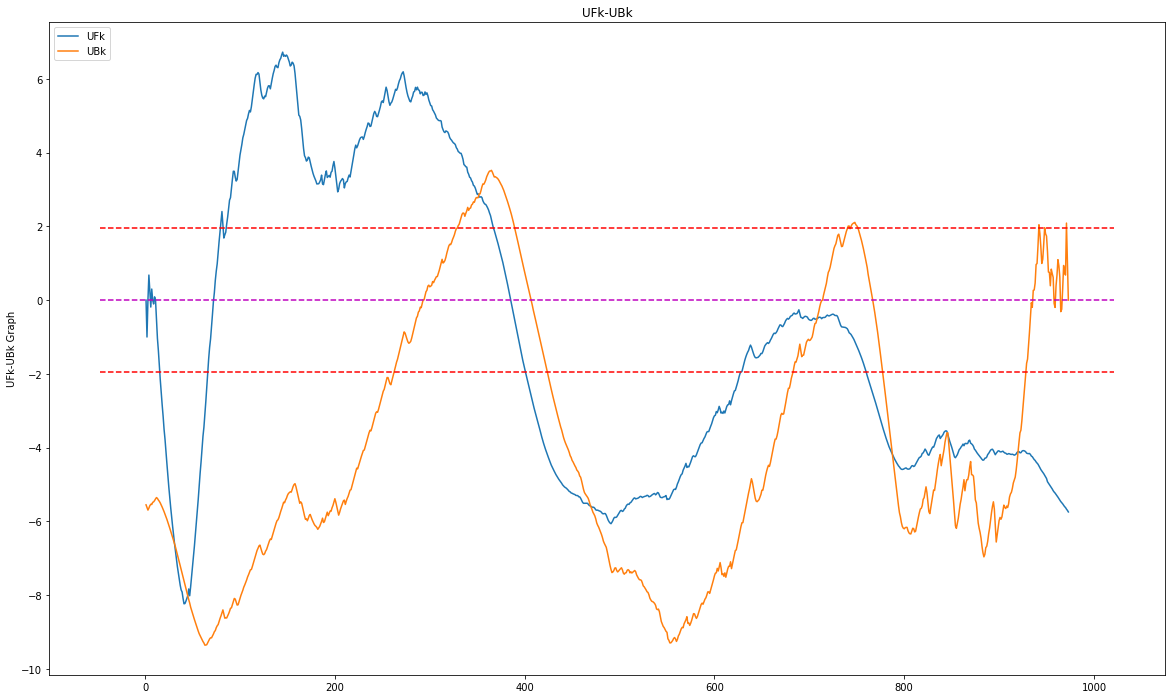

Category 大工业用电 max: [347, 471, 656]
Category 大工业用电 min: [31, 44, 351, 469, 708, 787, 845, 846, 919]


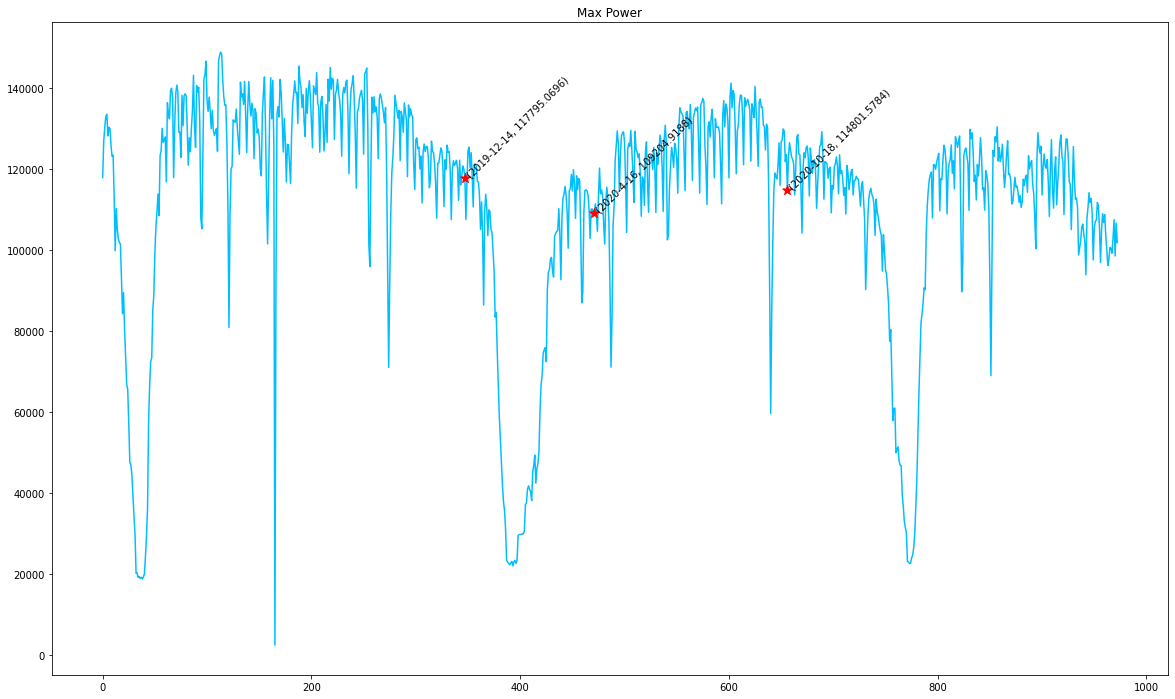

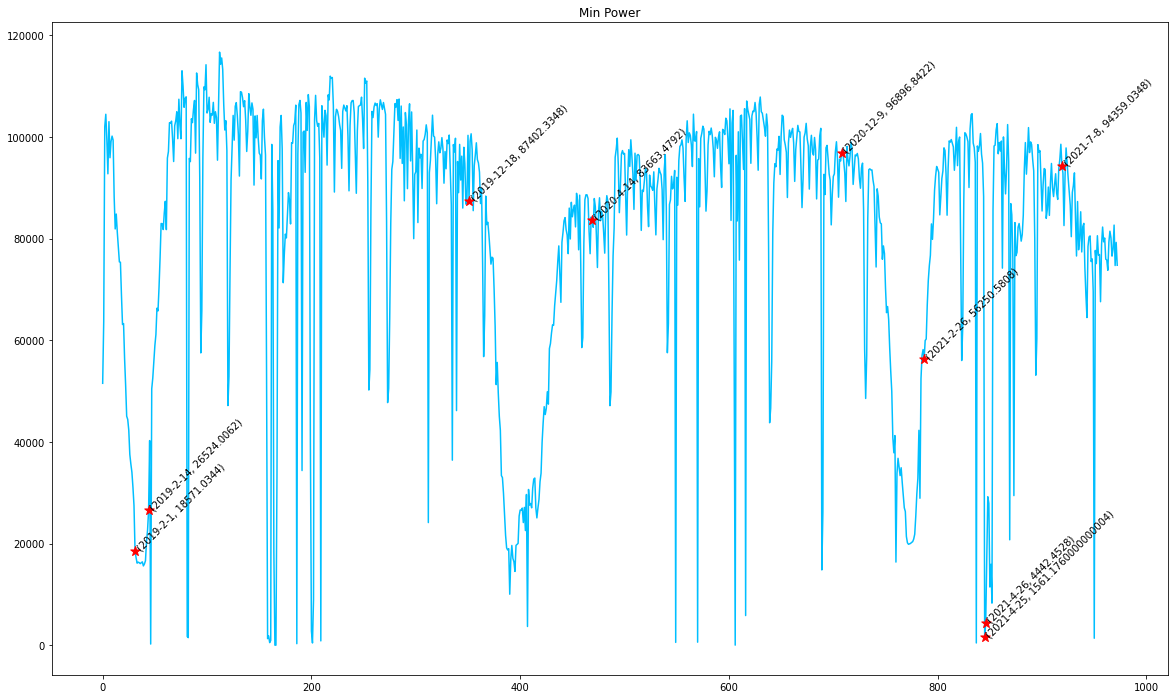

==================普通工业====================


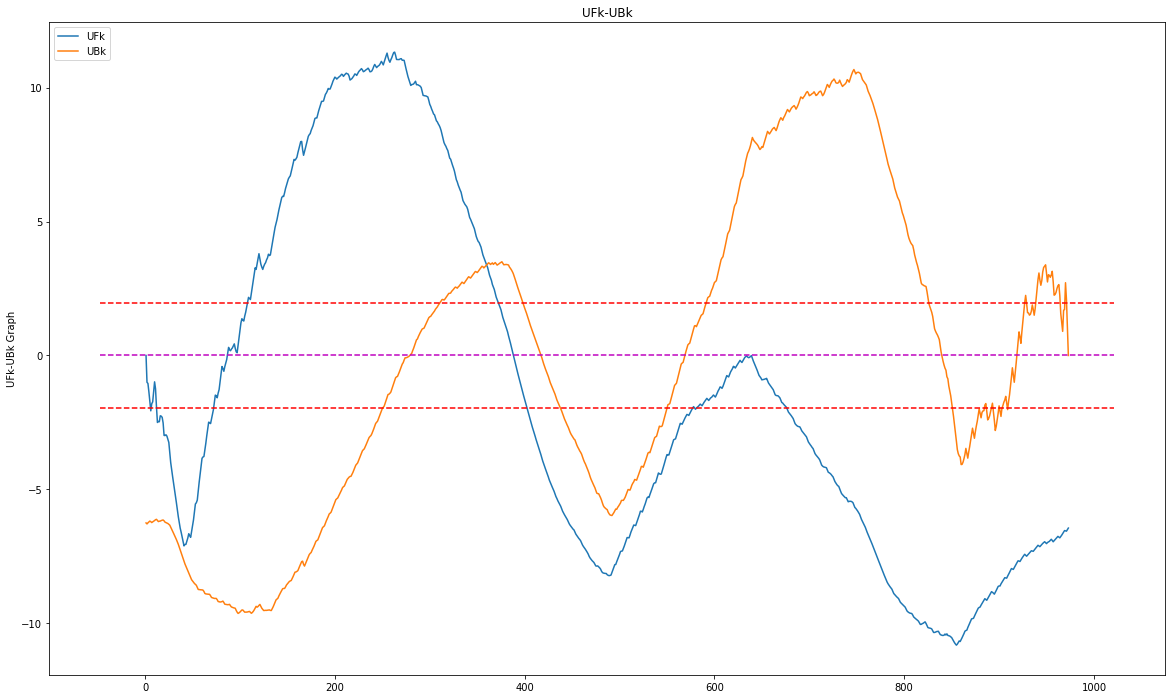

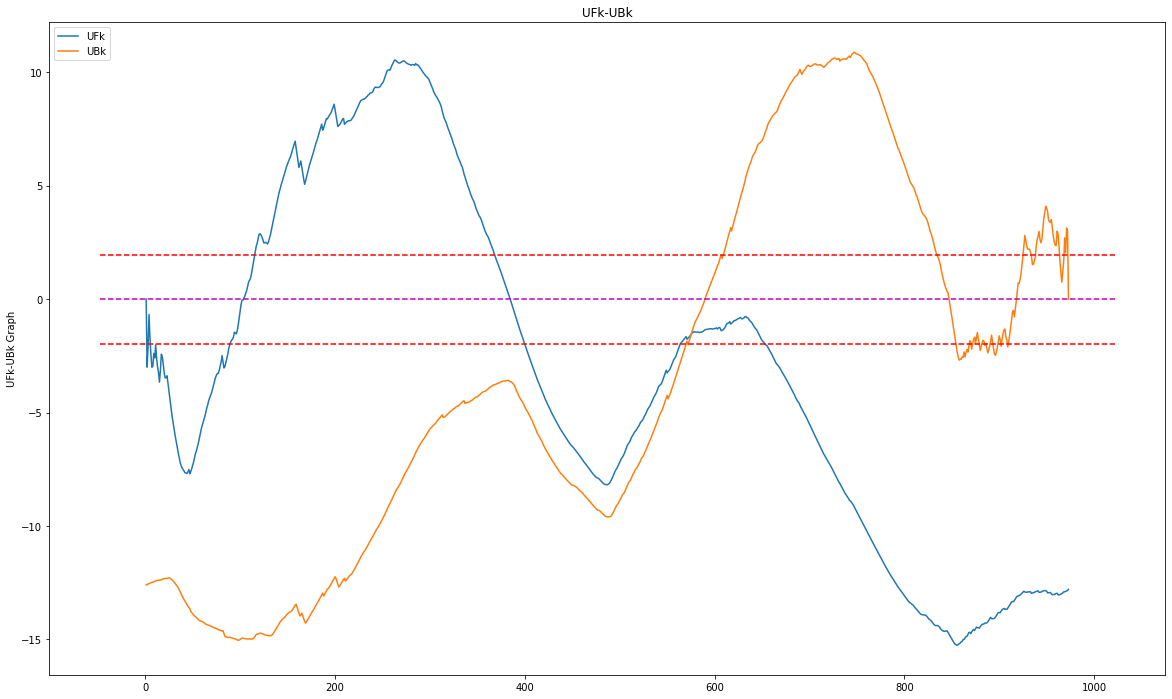

Category 普通工业 max: [359]
Category 普通工业 min: [575]


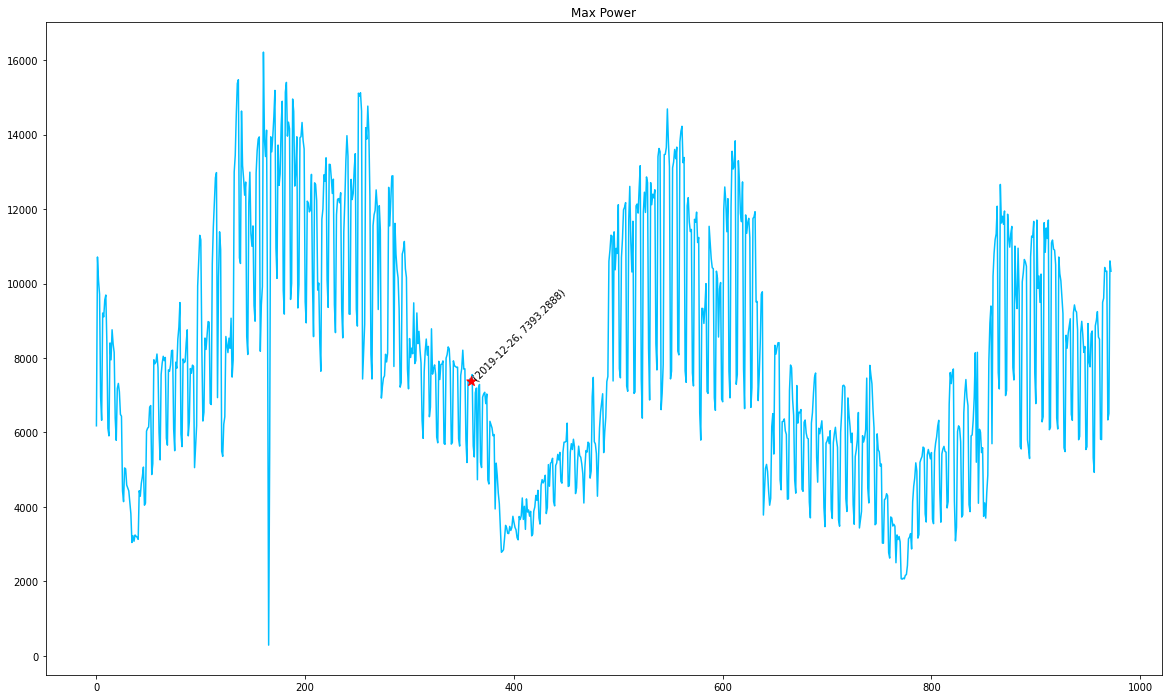

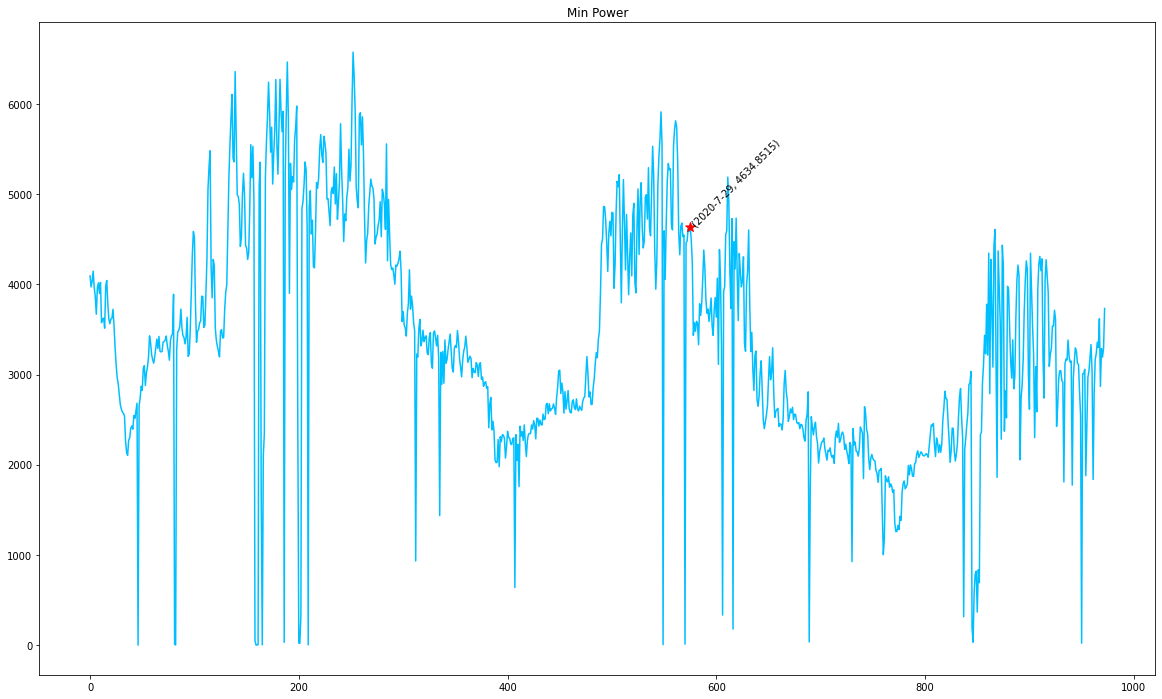

==================非普工业====================


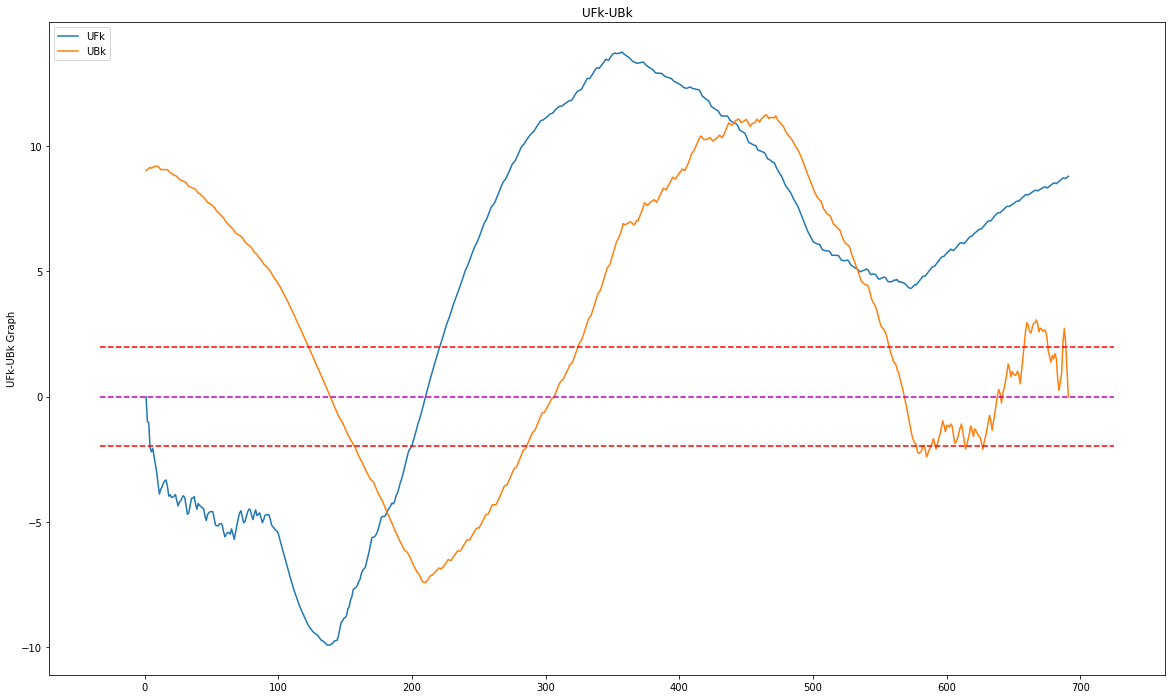

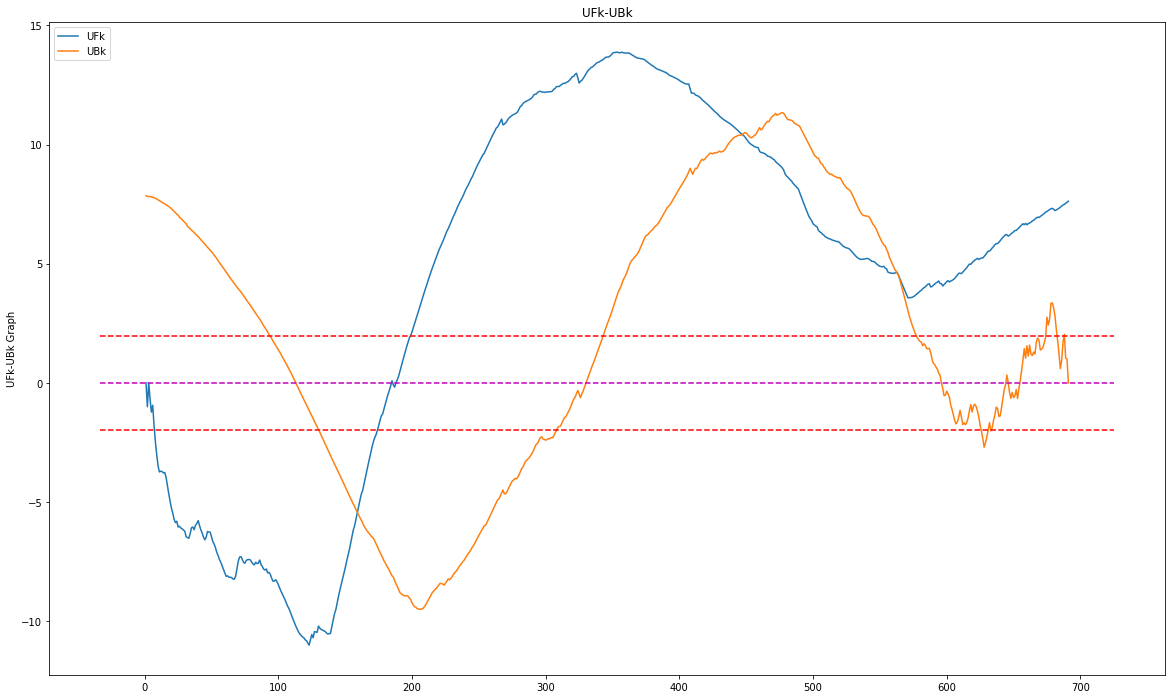

Category 非普工业 max: [181, 441, 532]
Category 非普工业 min: [159, 447, 562, 563, 564]


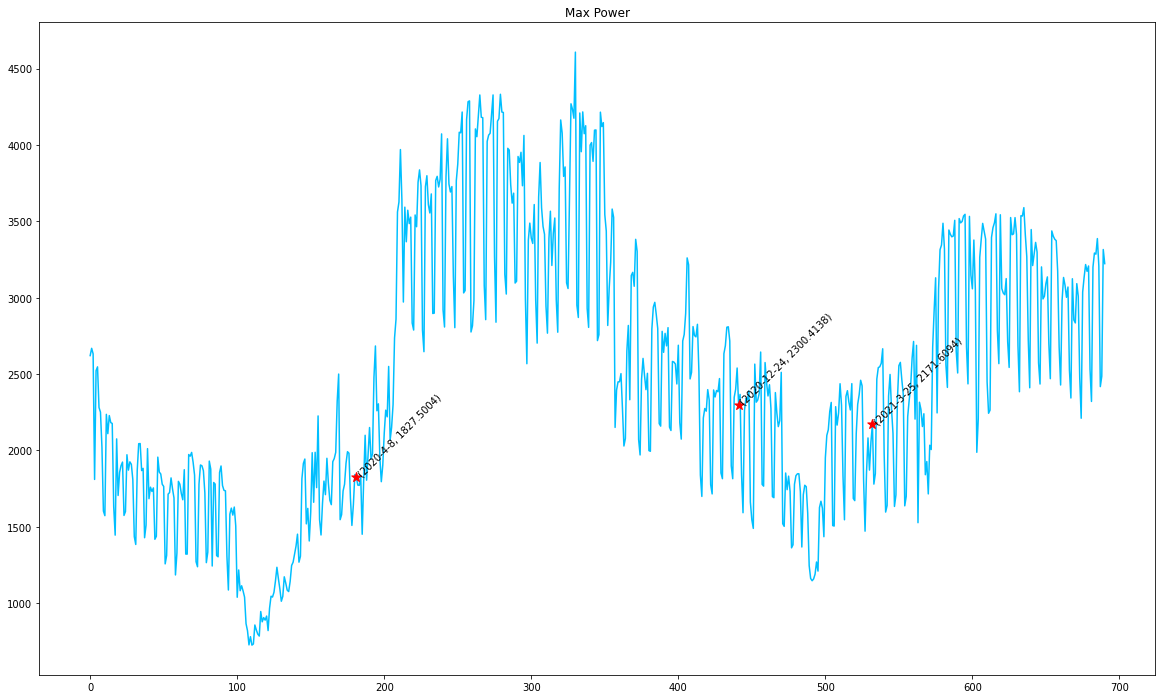

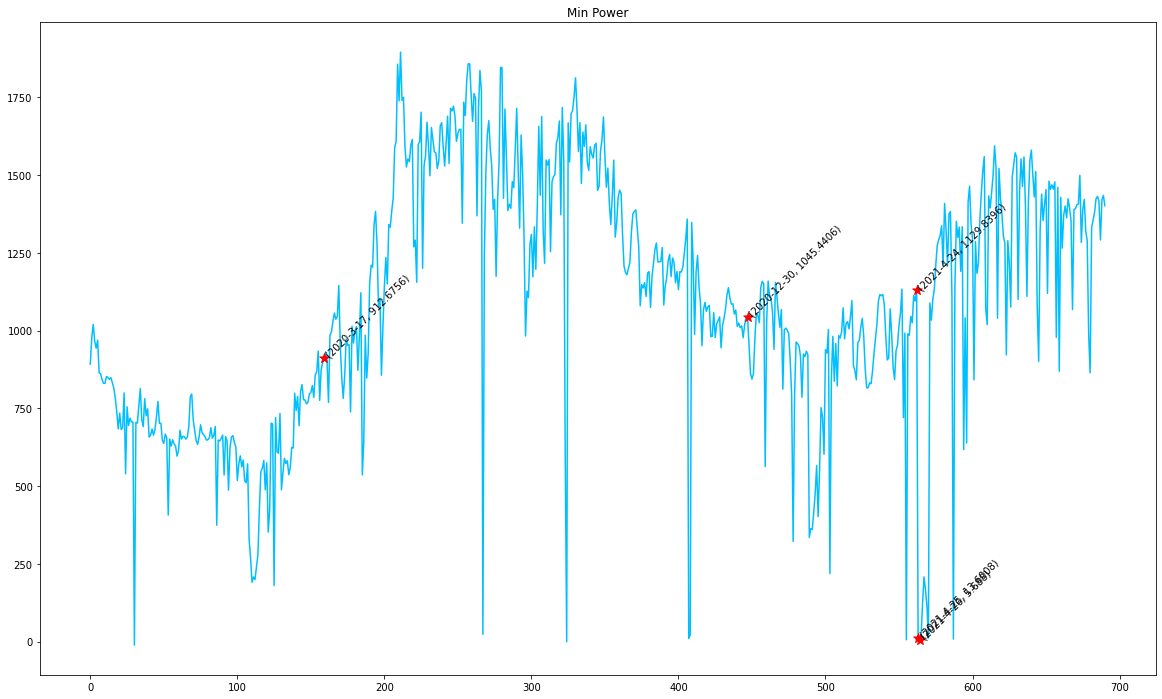

In [112]:
categories = all_data.groupby(['Category'], as_index=False)
for category in categories:
    name, df = category
    print(f'=================={name}====================')
    maxMK, minMK = MK(df['MaxPower']), MK(df['MinPower'])
    print(f'Category {name} max:', maxMK)
    print(f'Category {name} min:', minMK)
    
    min_date = df['Date'].min()
    
    plt.figure(figsize=(20, 12))
    x = np.arange(len(df))
    plt.plot(x, df['MaxPower'], c='deepskyblue')
    y = df.iloc[maxMK]['MaxPower'].to_list()
    plt.scatter(maxMK, y, c='r', marker='*', s=100, zorder=2)
    for i in range(len(y)):
        px = maxMK[i]
        py = y[i]
        cur_date = min_date + pd.Timedelta(f'{px}D')
        yy, m, d = cur_date.year, cur_date.month, cur_date.day
        label = f'({yy}-{m}-{d}, {py})'
        plt.annotate(label, (px, py), rotation=45)
    plt.title('Max Power')
    plt.show()
    
    plt.figure(figsize=(20, 12))
    x = np.arange(len(df))
    plt.plot(x, df['MinPower'], c='deepskyblue')
    y = df.iloc[minMK]['MinPower'].to_list()
    plt.scatter(minMK, y, c='r', marker='*', s=100, zorder=2)
    assert len(y) == len(minMK)
    for i in range(len(y)):
        px = minMK[i]
        py = y[i]
        cur_date = min_date + pd.Timedelta(f'{px}D')
        yy, m, d = cur_date.year, cur_date.month, cur_date.day
        label = f'({yy}-{m}-{d}, {py})'
        plt.annotate(label, (px, py), rotation=45)
    plt.title('Min Power')
    plt.show()

## Q3.2